# NYC Motor Vehicle Collisions

This project analyzes vehicle collisions in New York City. The data was collected from [NYC Open Data](https://opendata.cityofnewyork.us). The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. The police report (MV104-AN) is required to be filled out for collisions where someone is injured or killed, or where there is at least $1000 worth of damage. 

It includes data from 3 tables: 
* Vehicles - which contains details on each vehicle involved in the crash.
* Crashes - which contains details on the crash event.
* Person - contains details for people involved in the crash.

The tables were merged into a single table and filtered to remove repeated features, and null values from some key features. The filtered table has been imported into this jupyter environment for cleaning, analysis and determination of the project goal.

**Project Goal**

The goal of this project is to determine which factors contribute to the severity of road accidents in NYC and make recommendations on how to reduce them. 

We'll be using statistical analysis and Machine Learning to resolve to the project goal and make recommendations for policy directives. 

### Load the Workspace

In [1]:
import re
import datetime as dt
import time
from zipfile import ZipFile
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud

import bisect
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

### Load the dataset

In [2]:
with ZipFile('nyc_collisions.csv.zip', 'r') as zip_file:
    with zip_file.open('nyc_collisions.csv') as file:
        df = pd.read_csv(file, low_memory=False)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.assign(
    borough=lambda x: x.borough.str.title(),
    crash_datetime=lambda x: pd.to_datetime(x.crash_datetime),
    zip_code=lambda x: x.zip_code.str.strip(),
    person_sex=lambda x: x.person_sex.fillna('U'),
    state_registration=lambda x: x.state_registration.fillna(x.state_registration.mode().iloc[0]).str.upper(),
    vehicle_type=lambda x: x.vehicle_type.str.title(),
    travel_direction=lambda x: x.travel_direction.map({
        'N':'North', 'S':'South', 'E':'East', 'W':'West',
        '-':'Unknown', 'U':'Unknown'
    }).fillna(x.travel_direction).fillna('Unknown')
)
    
df = df.drop(
    index=list(df.loc[df.zip_code==''].index)
).assign(
    zip_code=lambda x: x.zip_code.astype(int)
)

df.head()

collision_id   borough      crash_datetime  zip_code  latitude  longitude  \
0       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
1       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
2       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
3       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   
4       4136992  Brooklyn 2019-05-21 22:50:00     11201  40.69754  -73.98312   

  person_type person_sex person_injury  person_age  ...  \
0    Occupant          M   Unspecified          32  ...   
1    Occupant          M   Unspecified          34  ...   
2    Occupant          M   Unspecified          31  ...   
3    Occupant          M   Unspecified          32  ...   
4    Occupant          M   Unspecified          34  ...   

  number_of_pedestrians_injured number_of_pedestrians_killed  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   number_of_cyclist_injured number_of_cyclist_killed  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   

   number_of_motorist_injured number_of_motorist_killed     ejection  \
0                           0                         0  Not Ejected   
1                           0                         0  Not Ejected   
2                           0                         0  Not Ejected   
3                           0                         0  Not Ejected   
4                           0                         0  Not Ejected   

  emotional_status   bodily_injury  \
0   Does Not Apply  Does Not Apply   
1   Does Not Apply  Does Not Apply   
2   Does Not Apply  Does Not Apply   
3   Does Not Apply  Does Not Apply   
4   Does Not Apply  Does Not Apply   

                                 position_in_vehicle  
0                                             Driver  
1                                             Driver  
2  Front passenger, if two or more persons, inclu...  
3                                             Driver  
4                                             Driver  

[5 rows x 41 columns]

### Data Cleaning

**Map Values**

In [4]:
vehicle_type_map = [
    (['Sport Utility / Station Wagon', 'Multi-Wheeled Vehicle', 'Wagon', 'Suv', 'Subur', 'Subn', 'Subn/', 'Jeep'], 'Station Wagon/Sport Utility Vehicle'),
    (['Tractor Truck Gasoline', 'Tractor Truck Diesel', 'Bulk Agriculture', 'Tract', 'Trac', 'Tractor', 'Tractor Tr', 'Ems', 'Emt'], 'Tractor Truck'),
    (['4 Dr Sedan', '2 Dr Sedan', 'Motor', 'Stree', 'Self', '4Dr', '3-Door', '3 Whe', '4Ds', '4D'], 'Sedan'), 
    (['E-Sco', 'Electric S', 'E Sco', 'Escooter', 'E Scooter'], 'E-Scooter'),
    (['E-Bik', 'Elect', 'E Bik', 'Ebike', 'Elec'], 'E-bike'),
    (['Limo', 'Limou'], 'Limousine'),
    (['Schoo'], 'School Bus'),
    (['Firet', 'Firetruck', 'Fire', 'Fdny', 'Fdny Truck', 'Fdny Fire', 'Fdny Engin', 'Fdny Ambul', 'Fd Truck', 'Nyc F', 'Fdny Ems', 'Fdny Ladde', 'Fd Tr', 'Fire Engin', 'Ladder Tru', 'Nyfd', 'Firtruck', 'Fdny #226', 'Fdny Firet', 'Fdny Rig', 'Ladder'], 'Fire Truck'),
    (['Bike', 'Minibike', 'Minicycle'], 'Bicycle'),
    (['Ambul', 'Ambu', 'Amb', 'Ambulence', 'Nys Ambula', 'Nyc Ambula', 'Nyc A', 'Ambulace', 'Embulance'], 'Ambulance'),
    (['Pk', 'Pick', 'Picku', 'Ford', 'Pick Up', 'Pickup', 'Pick Up Tr', 'Pickup', 'Pick-', 'Pickup Tru', 'Pick-Up Tr'], 'Pick-Up Truck'),
    (['Dump', 'Garbage Or Refuse', 'Dump Truck', 'Sanit', 'Garba', 'Dumps', 'Garbage Tr', 'Sanitation', 'G Tow', 'Dumpt', 'Nyc Sanita'], 'Garbage Truck'),
    (['Flat Bed', 'Stake Or Rack', 'Open Body', 'Flat Rack', 'Flat', 'Flatbed', 'Flatb'], 'Flatbed Truck'),
    (['Livery Vehicle', 'Pedicab'], 'Taxi'),
    (['Tow Truck / Wrecker', 'Tow T', 'Tow', 'Tower'], 'Tow Truck'),
    (['Small Com Veh(4 Tires)', 'Chassis Cab', 'Usps', 'Deliv', 'Comme', 'Com', 'Comm', 'Delv', 'Utili', 'Pickup With Mounted Camper', 'Util', 'Posta', 'Us Po', 'Mail', 'Usps Truck', 'Glass Rack', 'Livestock Rack', 'Postal Tru', 'Nyc D', 'Delivery T', 'Mail Truck', 'Us Postal', 'Delivery', 'Fedex', 'Commercial', 'Utility Tr', 'Com T', 'Comer', 'Usps Mail', 'Fedex Truc', 'Usp M', 'Ups'], 'Medium Duty Commercial Truck'),
    (['Large Com Veh(6 Or More Tires)', 'Forkl', 'Mack', 'Power', 'Freig', 'Fork','Cargo', 'Forklift', 'Uhaul', 'Power Shov', 'Semi', 'Semi-', 'U-Hau', 'Fork Lift', '18 Wh', '8X20', 'Movin', 'Uhual', 'Semitraile'], 'Heavy Duty Commercial Truck'),
    (['Trail', 'Trailer', 'Trl', 'Trlr', 'Trailor', 'Tlr'], 'Trailer Truck'),
    (['Lift Boom', 'Boom'], 'Boom Lift'),
    (['Scoot', 'Pallet', 'Scoo', 'Scotter', 'Gas Scoote'], 'Scooter'),
    (['Box T', 'Box', 'Boxtr'], 'Box Truck'),
    (['Pas', 'Pass', 'Pas V', 'Passe'], 'Passenger Vehicle'),
    (['Tanker', 'Tank'], 'Tanker Truck'),
    (['Beverage Truck', 'Lunch Wagon', 'Food', 'Food Cart'], 'Food Truck'),
    (['Trk', 'Tk', 'Vehicle Tr', 'Truck Van', 'Track'], 'Truck'),
    (['Rv', 'Motorized Home', 'Motor Home'], 'RV'),
    (['Van T', 'Miniv', 'Refrigerated Van', 'Van Camper', 'Refg', 'Vanette', 'Van/T', 'Refri', 'Work Van', 'Vav', 'Van Ford', 'Van Truck', 'Van F', 'Cargo Van', 'Transit Va', 'School Van', 'Vam', 'Mini Van'], 'Van'),
    (['Mta B', 'Mta Bus', 'Omnib', 'Ems Bus'], 'Bus'),
    (['Cemen', 'Cmix', 'Cement Tru', 'Cmixer', 'Concrete M'], 'Concrete Mixer'),
    (['Mopd', 'Mopet'], 'Moped')
]

def map_vehicle_type(x):
    for key_list, value in vehicle_type_map:
        if x in key_list:
            return value
    return x

vehicle_types = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type)
).vehicle_type.value_counts(dropna=False).iloc[:40].index.tolist()

In [5]:
df = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type),
    vehicle_year=lambda x: np.where(
        x.vehicle_year > 2021, x.crash_datetime.dt.year, x.vehicle_year
    ),
    number_of_persons_injured=lambda x: x.number_of_persons_injured.fillna(0),
    number_of_persons_killed=lambda x: x.number_of_persons_killed.fillna(0),
).assign(
    vehicle_type=lambda x: np.where(
        x.vehicle_type.isin(vehicle_types),
        x.vehicle_type, 'Other'
    )
).assign(
    vehicle_type=lambda x:  x.vehicle_type.str.replace('Unknown', 'Other').str.replace('Unkno', 'Other')
).map(lambda x: x.strip().title() if isinstance(x, str) else x)

**Handle Duplicates & Missing Values**

In [6]:
# Drop duplicate records:
drop_index = df.loc[df.duplicated(keep='first')].index
df = df.drop(index=drop_index)

# Drop records with latitude and longitide as 0 or na:
drop_index = df.loc[df.longitude == 0].index
df = df.drop(index=drop_index).reset_index(drop=True)

drop_index = df.loc[df.longitude.isna()].index
df = df.drop(index=drop_index).reset_index(drop=True)

# Drop records with Vehicle Occupants Over 100 (outliers)
drop_index = df.loc[df.vehicle_occupants > 100].index
df = df.drop(index=drop_index).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744550 entries, 0 to 2744549
Data columns (total 41 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   collision_id                   int64         
 1   borough                        object        
 2   crash_datetime                 datetime64[ns]
 3   zip_code                       int64         
 4   latitude                       float64       
 5   longitude                      float64       
 6   person_type                    object        
 7   person_sex                     object        
 8   person_injury                  object        
 9   person_age                     int64         
 10  state_registration             object        
 11  vehicle_type                   object        
 12  vehicle_year                   float64       
 13  travel_direction               object        
 14  vehicle_occupants              float64       
 15  driver_sex     

In [7]:
df.isnull().sum()

collision_id                           0
borough                                0
crash_datetime                         0
zip_code                               0
latitude                               0
longitude                              0
person_type                            0
person_sex                             0
person_injury                          0
person_age                             0
state_registration                     0
vehicle_type                           0
vehicle_year                      319605
travel_direction                       0
vehicle_occupants                 250482
driver_sex                        466232
driver_license_status             559516
driver_license_jurisdiction       540720
pre_crash                         130851
point_of_impact                   234682
vehicle_damage                    241100
vehicle_damage_1                 1135831
vehicle_damage_2                 1573055
vehicle_damage_3                 1868861
public_property_

In [8]:
df = df.set_index('crash_datetime').sort_index()
df.head()

collision_id    borough  zip_code   latitude  longitude  \
crash_datetime                                                                 
2012-07-01 00:30:00          5292  Manhattan     10007  40.714678 -74.005887   
2012-07-01 00:30:00          5292  Manhattan     10007  40.714678 -74.005887   
2012-07-01 00:37:00         37633  Manhattan     10017  40.755924 -73.974889   
2012-07-01 00:37:00         37633  Manhattan     10017  40.755924 -73.974889   
2012-07-01 01:00:00         85161      Bronx     10456  40.828729 -73.914723   

                    person_type person_sex person_injury  person_age  \
crash_datetime                                                         
2012-07-01 00:30:00    Occupant          U       Injured          31   
2012-07-01 00:30:00    Occupant          U       Injured          31   
2012-07-01 00:37:00    Occupant          U       Injured          36   
2012-07-01 00:37:00    Occupant          U       Injured          36   
2012-07-01 01:00:00    Occupant          U       Injured          36   

                    state_registration  ... number_of_pedestrians_injured  \
crash_datetime                          ...                                 
2012-07-01 00:30:00                 Nj  ...                             0   
2012-07-01 00:30:00                 Ny  ...                             0   
2012-07-01 00:37:00                 Nj  ...                             0   
2012-07-01 00:37:00                 Ny  ...                             0   
2012-07-01 01:00:00                 Ny  ...                             0   

                     number_of_pedestrians_killed number_of_cyclist_injured  \
crash_datetime                                                                
2012-07-01 00:30:00                             0                         0   
2012-07-01 00:30:00                             0                         0   
2012-07-01 00:37:00                             0                         0   
2012-07-01 00:37:00                             0                         0   
2012-07-01 01:00:00                             0                         0   

                     number_of_cyclist_killed number_of_motorist_injured  \
crash_datetime                                                             
2012-07-01 00:30:00                         0                          1   
2012-07-01 00:30:00                         0                          1   
2012-07-01 00:37:00                         0                          1   
2012-07-01 00:37:00                         0                          1   
2012-07-01 01:00:00                         0                          1   

                    number_of_motorist_killed ejection emotional_status  \
crash_datetime                                                            
2012-07-01 00:30:00                         0      NaN              NaN   
2012-07-01 00:30:00                         0      NaN              NaN   
2012-07-01 00:37:00                         0      NaN              NaN   
2012-07-01 00:37:00                         0      NaN              NaN   
2012-07-01 01:00:00                         0      NaN              NaN   

                    bodily_injury position_in_vehicle  
crash_datetime                                         
2012-07-01 00:30:00           NaN                 NaN  
2012-07-01 00:30:00           NaN                 NaN  
2012-07-01 00:37:00           NaN                 NaN  
2012-07-01 00:37:00           NaN                 NaN  
2012-07-01 01:00:00           NaN                 NaN  

[5 rows x 40 columns]

### Exploratory Analysis

We'll respond to the following questions:
1. Which location has the most accidents?
2. Which time has the most accidents?
3. Which day of the week has the most accidents?
4. Accident Trends over time
5. How many victims on average per accident?
6. Registration Year for cars in accidents.
7. Using vehicle year, what is the likelihood that an accident will result in injury or death?
8. Reasons for accidents.
9. Which street corner / intersection is prone to accidents?
10. Gender split for Accidents.
11. Which vehicles contribute the most to accidents?
12. Driver Licence jurisdictions and accidents
13. Travel Direction and Accidents
14. Person Injury and Accidents
15. Injured vs Killed stats
16. Relationship between Complainant and person injured
17. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction
18. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role
19. Provide recommendations to reduce the occurrence of accidents

Plotting Colors:

In [9]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

**Location-Based Analysis**
1. Which location has the most accidents?

We have a number of location-based features:
* Longitude & Latitude
* on street name & cross street name

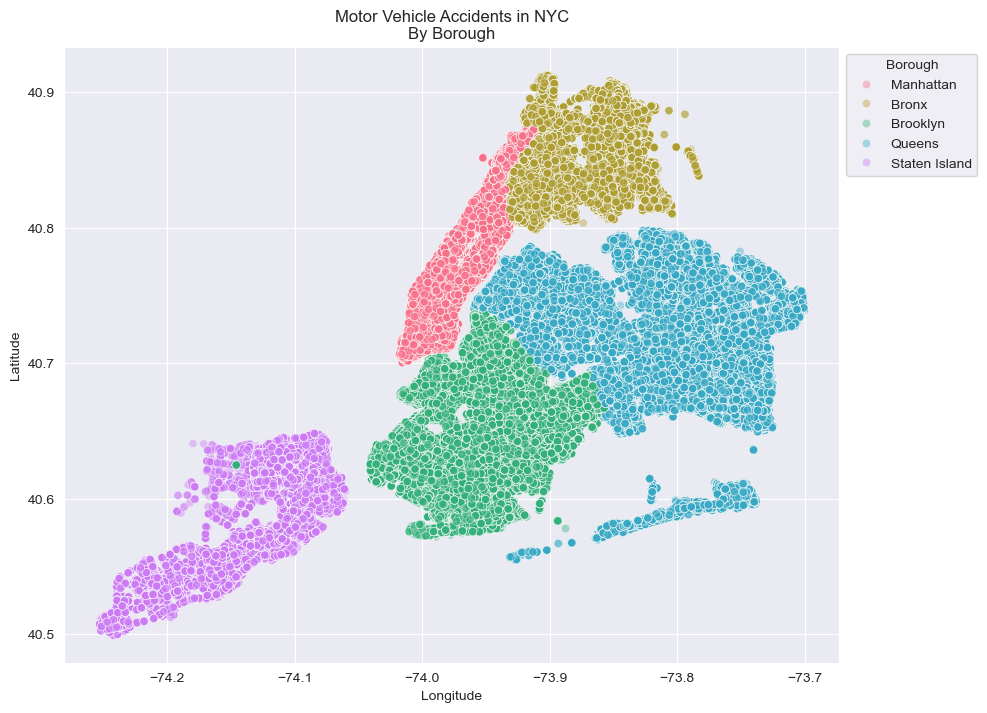

In [10]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='borough', alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Motor Vehicle Accidents in NYC\nBy Borough')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Borough")
plt.show()

More accidents are involve licensed drivers and male drivers.

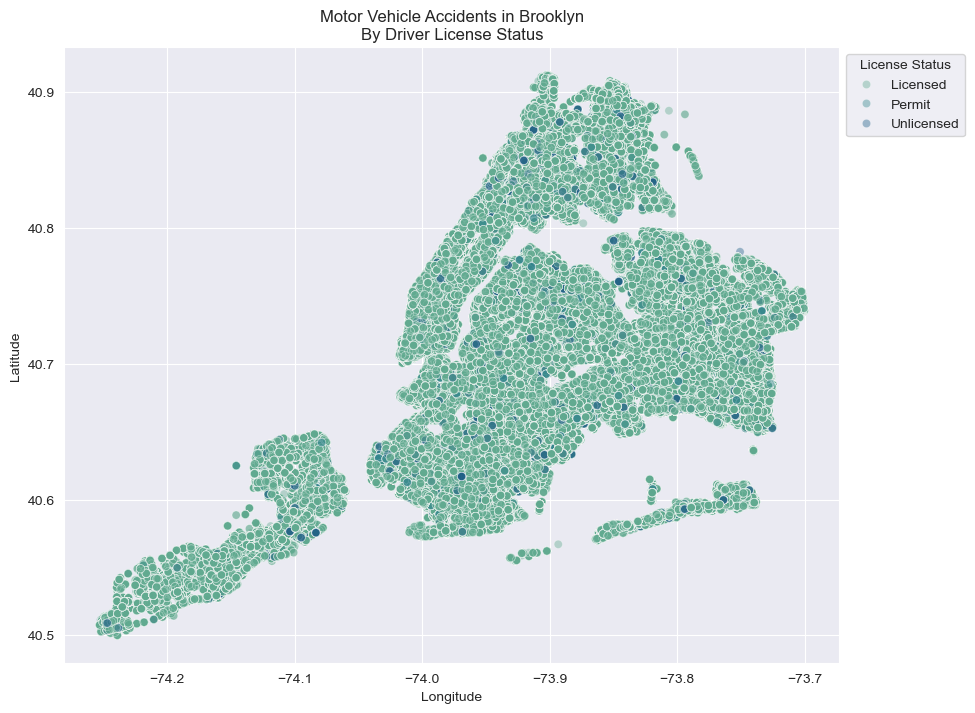

In [11]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_license_status', palette='crest', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Motor Vehicle Accidents in Brooklyn\nBy Driver License Status')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="License Status")
plt.show()

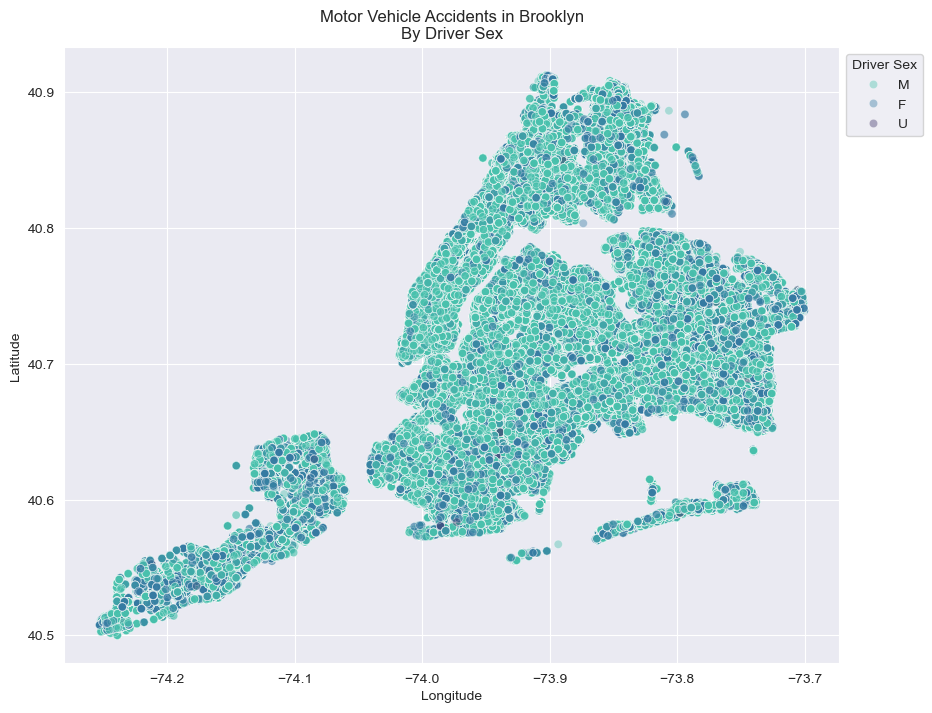

In [12]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_sex', palette='mako_r', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Motor Vehicle Accidents in Brooklyn\nBy Driver Sex')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Driver Sex")
plt.show()

The chart of Boroughs and accidents count is identical to Borough and population.

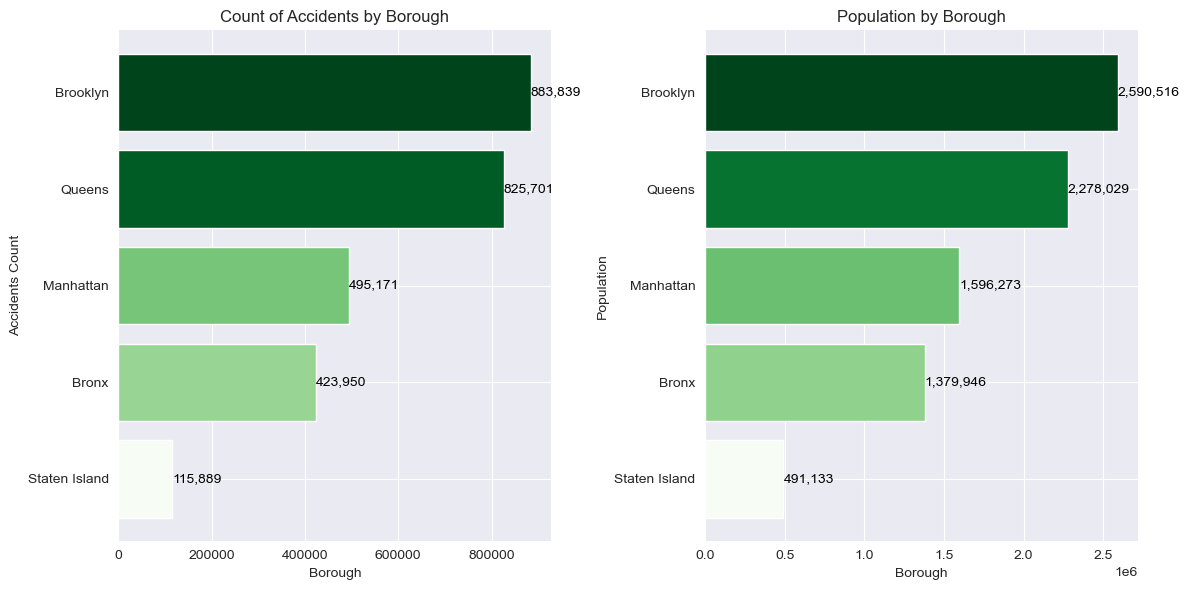

In [13]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.subplot(121)

data = df.borough.value_counts()
cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data.values), max(data.values))

plt.barh(
    data.index,
    data.values,
    color=cmap(normalize(data.values)), edgecolor='white'
)
for i, v in enumerate(data.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')

# Remove chart outline
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(False)

sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.xlabel('Borough')
plt.ylabel('Accidents Count')
plt.title('Count of Accidents by Borough')
plt.gca().invert_yaxis()

plt.subplot(122)

data = pd.DataFrame({
        'borough': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
        'population': [1379946, 2590516, 1596273, 2278029, 491133]
 }).sort_values(by='population', ascending=False)
cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data.population), max(data.population))

plt.barh(
    data.borough,
    data.population,
    color=cmap(normalize(data.population)), edgecolor='white'
)
for i, v in enumerate(data.population.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(False)
sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.xlabel('Borough')
plt.ylabel('Population')
plt.title('Population by Borough')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

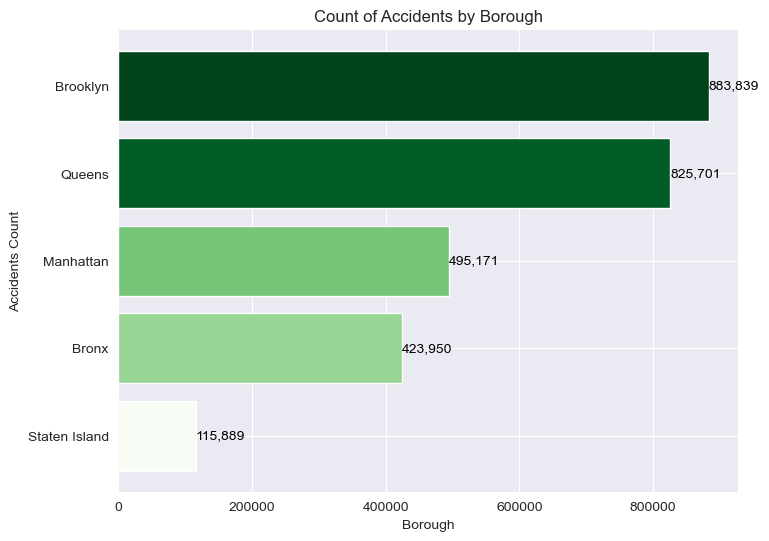

In [14]:
data = df.borough.value_counts()
cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data.values), max(data.values))

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
plt.barh(
    data.index,
    data.values,
    color=cmap(normalize(data.values)), edgecolor='white'
)
for i, v in enumerate(data.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')

# Remove chart outline
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(False)

sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.xlabel('Borough')
plt.ylabel('Accidents Count')
plt.title('Count of Accidents by Borough')
plt.gca().invert_yaxis()
plt.show()

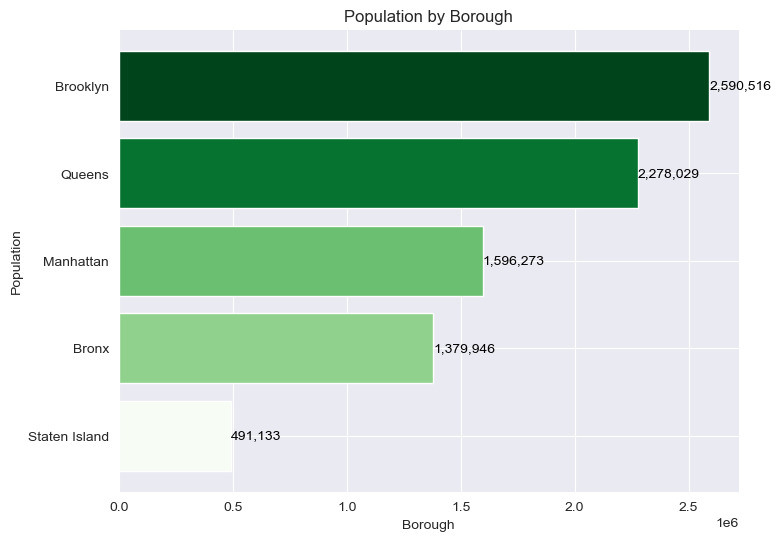

In [15]:
data = pd.DataFrame(
    {
        'borough': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
        'population': [1379946, 2590516, 1596273, 2278029, 491133]
 }
).sort_values(by='population', ascending=False)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data.population), max(data.population))

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
plt.barh(
    data.borough,
    data.population,
    color=cmap(normalize(data.population)), edgecolor='white'
)
for i, v in enumerate(data.population.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')

# Remove chart outline
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(False)

sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.xlabel('Borough')
plt.ylabel('Population')
plt.title('Population by Borough')
plt.gca().invert_yaxis()
plt.show()

The severity of accidents by Borough when summed also follows this pattern. However, when averaged, the picture is different:

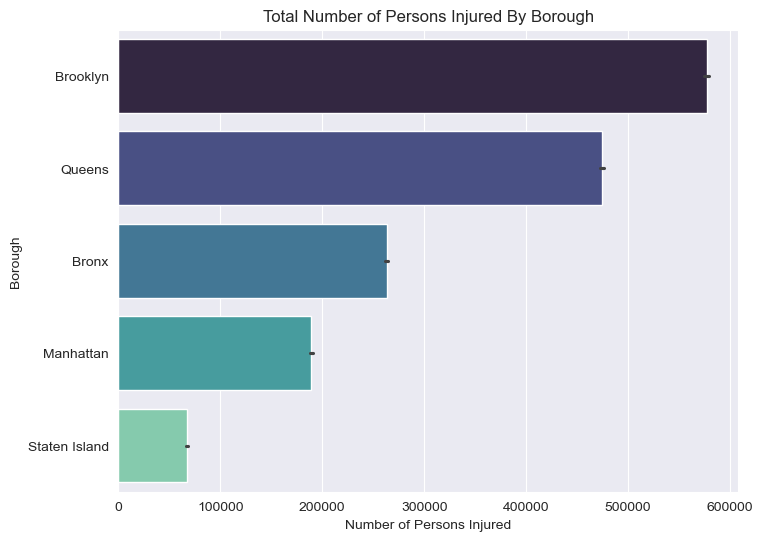

In [16]:
count_data = df.groupby('borough').sum(numeric_only=True).number_of_persons_injured.sort_values(ascending=False).reset_index()
num_bars = len(count_data)
custom_palette = sns.color_palette("mako", n_colors=num_bars)
sns.set_palette(custom_palette)

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
sns.barplot(
    data=df, y='borough', x='number_of_persons_injured', 
    orient='h', order=count_data.borough, estimator='sum',
    hue='borough', hue_order=count_data.borough, legend=False
    )
plt.xlabel('Number of Persons Injured')
plt.ylabel('Borough')
plt.title('Total Number of Persons Injured By Borough')
plt.show()

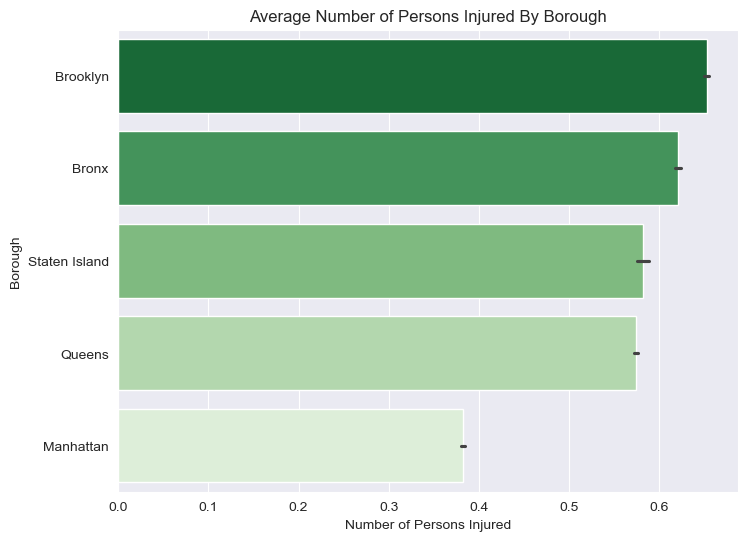

In [17]:
count_data = df.groupby('borough').mean(numeric_only=True).number_of_persons_injured.sort_values(ascending=False).reset_index()
num_bars = len(count_data)
custom_palette = sns.color_palette("Greens_r", n_colors=num_bars)
sns.set_palette(custom_palette)

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
sns.barplot(
    data=df, y='borough', x='number_of_persons_injured', 
    orient='h', order=count_data.borough, 
    hue_order=count_data.borough, hue='borough', legend=False
    )
plt.xlabel('Number of Persons Injured')
plt.ylabel('Borough')
plt.title('Average Number of Persons Injured By Borough')
plt.show()

When we use a bar plot to determine why the averages are different, there's not much to decipher. This might be a negligible difference.

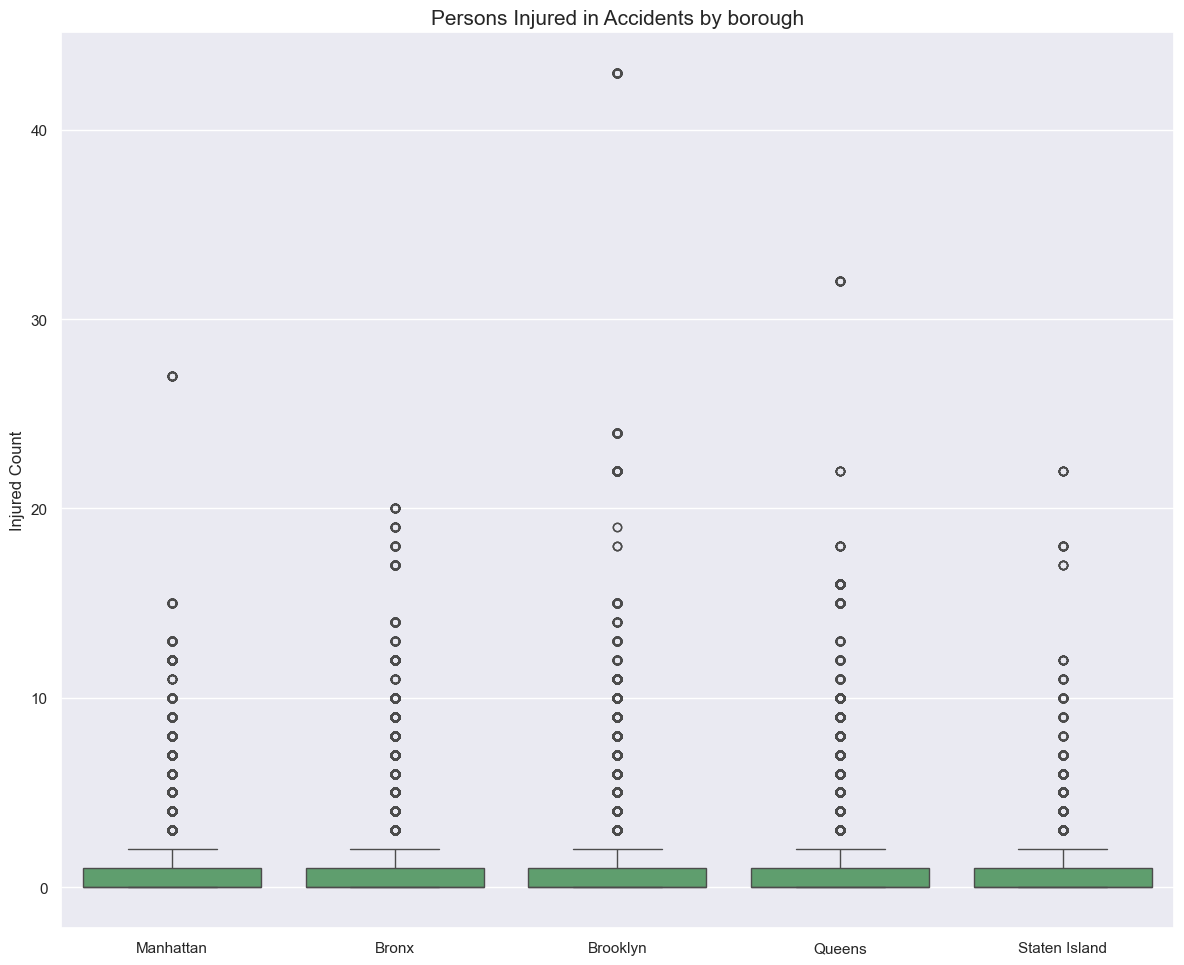

In [18]:
plt.figure(figsize=(12, 10))
sns.set() # reset palette

sns.set_style("darkgrid", {"grid.alpha": 0.2})
sns.boxplot(data=df, x='borough', y='number_of_persons_injured', 
            linewidth=1, color=deep_colors[1])

plt.xlabel('')
plt.ylabel('Injured Count')
plt.title('Persons Injured in Accidents by borough', size=15)
plt.suptitle('')
plt.tight_layout()
plt.show()

When we test the strength of the relationship between severity and location, date and hour, we find that severity is not strongly correlated to either variable.

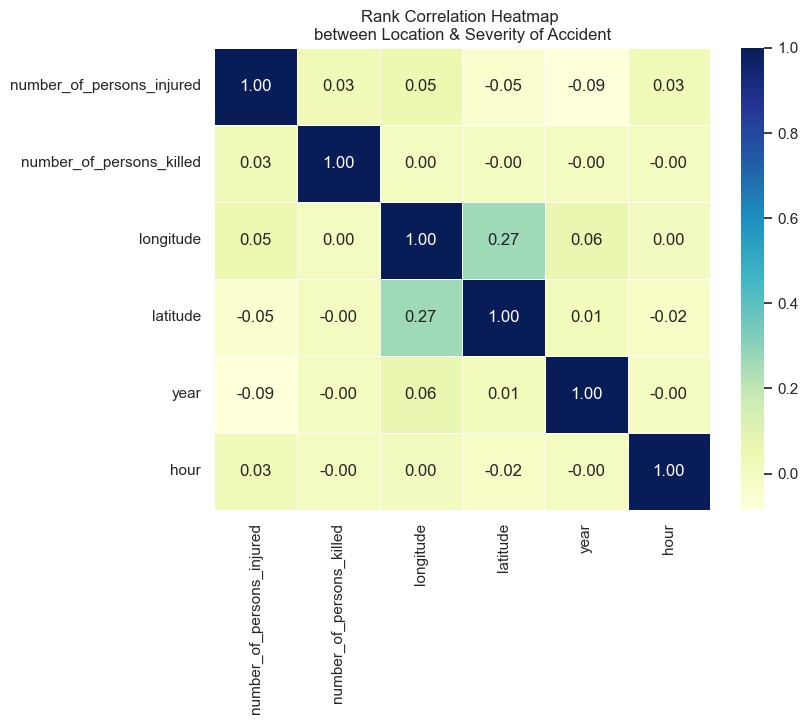

In [19]:
corr_cols = ['number_of_persons_injured', 'number_of_persons_killed', 'longitude', 'latitude', 'year', 'hour']
data = df.assign(
    year= lambda x: x.index.year,
    hour= lambda x: x.index.hour
    ).dropna(subset=corr_cols)

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
sns.heatmap(
    data[corr_cols].corr(method='spearman'), 
    annot=True,
    linewidths=0.5,
    fmt= ".2f",
    cmap="YlGnBu"
    )
plt.title('Rank Correlation Heatmap \nbetween Location & Severity of Accident')
plt.show()

This is further confirmed by our linear model using those features to explain the variance in the `number of persons` injured feature. Only 3% of the variance in that feature is explainable by those predictors with any statistical significance.

In [20]:
data = df.assign(
    year= lambda x: x.index.year,
    hour= lambda x: x.index.hour,
    )
formula = 'number_of_persons_injured ~ borough + longitude + latitude + year + hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.031
Model:                                   OLS   Adj. R-squared:                  0.031
Method:                        Least Squares   F-statistic:                 1.103e+04
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                               20:46:37   Log-Likelihood:            -4.1662e+06
No. Observations:                    2744550   AIC:                         8.333e+06
Df Residuals:                        2744541   BIC:                         8.333e+06
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

If we expand the model to include `driver license status` and `driver sex`, the model performs even more poorly.

In [21]:
data = df.query('driver_license_status.notna() & driver_sex.notna()').assign(
    year= lambda x: x.index.year,
    hour= lambda x: x.index.hour,
    )
formula = 'number_of_persons_injured ~ borough + longitude + latitude + year + hour + driver_license_status + driver_sex'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.023
Model:                                   OLS   Adj. R-squared:                  0.023
Method:                        Least Squares   F-statistic:                     4262.
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                               20:47:03   Log-Likelihood:            -3.0307e+06
No. Observations:                    2185026   AIC:                         6.061e+06
Df Residuals:                        2185013   BIC:                         6.062e+06
Df Model:                                 12                                         
Covariance Type:                   nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

The model's results imply the existence of multicollinearity. Multicollinearity is a statistical phenomenon in which two or more independent variables in a regression model are highly correlated, making it challenging to disentangle their individual effects on the dependent variable. In other words, it is a situation where there is a high degree of linear relationship among the predictor variables.

We used a Variance Inflation Factor (VIF) to detect the multicollinearity. VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. A high VIF (typically above 5 or 10) is an indicator of multicollinearity.

There is a high correlation between Brooklyn & Queens boroughs in the model.

In [22]:
vif = pd.DataFrame()
vif["Variable"] = model.exog_names
vif["VIF"] = [variance_inflation_factor(model.exog, i) for i in range(model.exog.shape[1])]

vif

Variable           VIF
0                             Intercept  6.307389e+06
1                   borough[T.Brooklyn]  8.726764e+00
2                  borough[T.Manhattan]  3.232042e+00
3                     borough[T.Queens]  5.437252e+00
4              borough[T.Staten Island]  4.535079e+00
5       driver_license_status[T.Permit]  1.002043e+00
6   driver_license_status[T.Unlicensed]  1.003171e+00
7                       driver_sex[T.M]  1.029417e+00
8                       driver_sex[T.U]  1.004711e+00
9                             longitude  3.932529e+00
10                             latitude  4.880538e+00
11                                 year  1.008455e+00
12                                 hour  1.001352e+00

**Analysis of Location & Severity of Accidents**

The scatter plot of longitude and latitude data colored by borough, shows the map of accient records across NYC. Even with the alpha parameter activated to show areas od accident intensity, the number of accidents were consistent across all boroughs of the city.

We used a horizontal bar chart to more clearly visualize the spread of accidents across the city. The bar chart showed that Brooklyn & Queens have significantly higher number of accidents than the other 3 boroughs. This seems to be related to borough population statistics, which mirrors the accidents count plot. 

This raised the hypothesis that accidents are more severe in high population boroughs. To determine this hypothesis, we plotted the total and average number of persons injured by Borough. The plot of total injured by borough followed the trend of initial chart of accidents by Borough. However, for average accidents by Borough, Bronx & Staten Island have higher accidents on average than Queens. 

We therefore tested the hypothesis by building an ordinary least squares (linear regression) model by using `borough` to explain the variance in `number of persons injured`. To build a more robust model, we also added `longitude`, `latitude`, `accident year` and `accident hour as predictor variables`. However, the model was only able to explain about 3% of the variance in `number of persons injured` with some statistical significance.

The model also implied the presence of strong multicollinearity due to a large condition number, so we built a variance inflation factor (VIF) table for each predictor variable. All predictor variables had low to moderate VIF. However, the intercept had a high VIF.

We also tested for correlation between the features and found that year, hour and location were only slightly correlated with number of injured persons. 

In essence, location does not strongly explain the severity of accidents in NYC, although it may be useful in explaining the number of accidents, i.e. more accidents occur in more population-dense boroughs (although on average, this is not the case). 

**Time Series Analysis on Accidents**

2. Which time has the most accidents?
3. Which day of the week has the most accidents?
4. Anomaly Detection—to determine when accidents are out of the ordinary

The timeframe of the dataset is between 2012 and 2021.

In [23]:
df.index.year.min(), df.index.year.max()

(2012, 2021)

In [24]:
df.index.value_counts().describe()

count    372542.000000
mean          7.367089
std           7.553939
min           1.000000
25%           2.000000
50%           6.000000
75%           9.000000
max         726.000000
Name: count, dtype: float64

In [25]:
df.index.value_counts().head()

crash_datetime
2020-06-30 13:20:00    726
2021-01-15 18:07:00    450
2021-01-21 17:00:00    182
2018-10-17 18:10:00    182
2017-09-04 22:45:00    144
Name: count, dtype: int64

Most dates have accident counts under 10. However, there are significant outliers within the over 75th percentile.

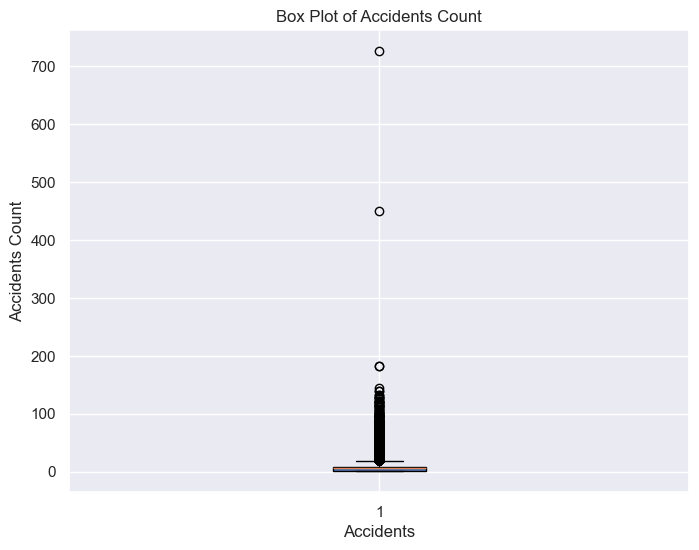

In [26]:
data = df.index.value_counts()

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})

boxprops = dict(facecolor=deep_colors[0])
plt.boxplot(data, patch_artist=True, boxprops=boxprops)
plt.xlabel('Accidents')
plt.ylabel('Accidents Count')
plt.title('Box Plot of Accidents Count')

plt.show()

When distributing accident severity according to year, we find that for most years, accidents result in under 20 injured persons. However, years 2013, 2015, 2017 and 2018 have outliers in excess of 20 injured people.

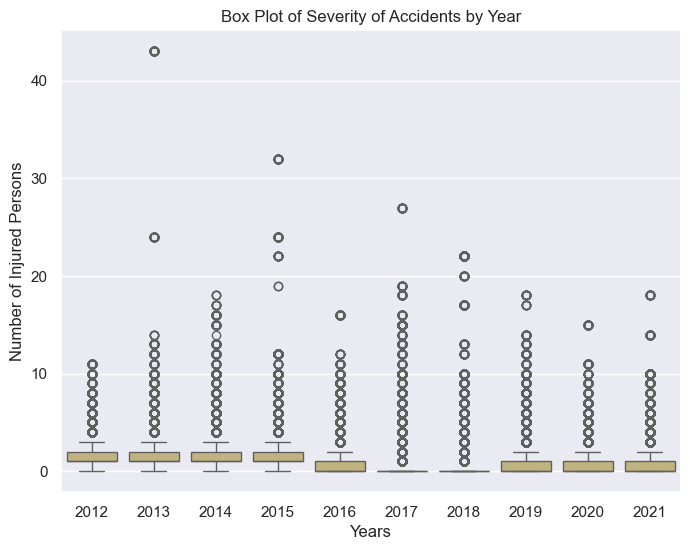

In [27]:
data = df.assign(
    year=lambda x: x.index.year
)

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.alpha": 0.2})
sns.boxplot(
    x='year', y='number_of_persons_injured', data=data, color=deep_colors[4]
)

plt.xlabel('Years')
plt.ylabel('Number of Injured Persons')
plt.title('Box Plot of Severity of Accidents by Year')

plt.show()

**Drilling Down into Severity Outliers**

When we examine records with the count of injured people being over 20, we find that:
* There are only 300 records falling within this category
* Most of these accidents occured in the Prospect Leffert Neighbourhood of Brooklyn, on the intersection of Norstrand Ave and Rutland Rd.
* 1/3 of the vehicles involved were buses
* Most of the accidents occured around 7 a.m. indicating morning rush hour.
* Most of the accidents occured in 2018
* Most of the accidents occured in the month of April

In [28]:
df.query('number_of_persons_injured > 20').shape

(300, 40)

                      accident_intersection        borough  Count
0            Nostrand Avenue - Rutland Road       Brooklyn    110
1           Herkimer Street - Albany Avenue       Brooklyn     50
2             Utica Avenue - Clarendon Road       Brooklyn     42
3           Dekalb Avenue - Tompkins Avenue       Brooklyn     30
4  Hillside Avenue - Hollis Court Boulevard         Queens     27
5                 7 Avenue - West 42 Street      Manhattan     23
6       Henderson Avenue - Lafayette Avenue  Staten Island     10
7            Northern Boulevard - 42 Street         Queens      8


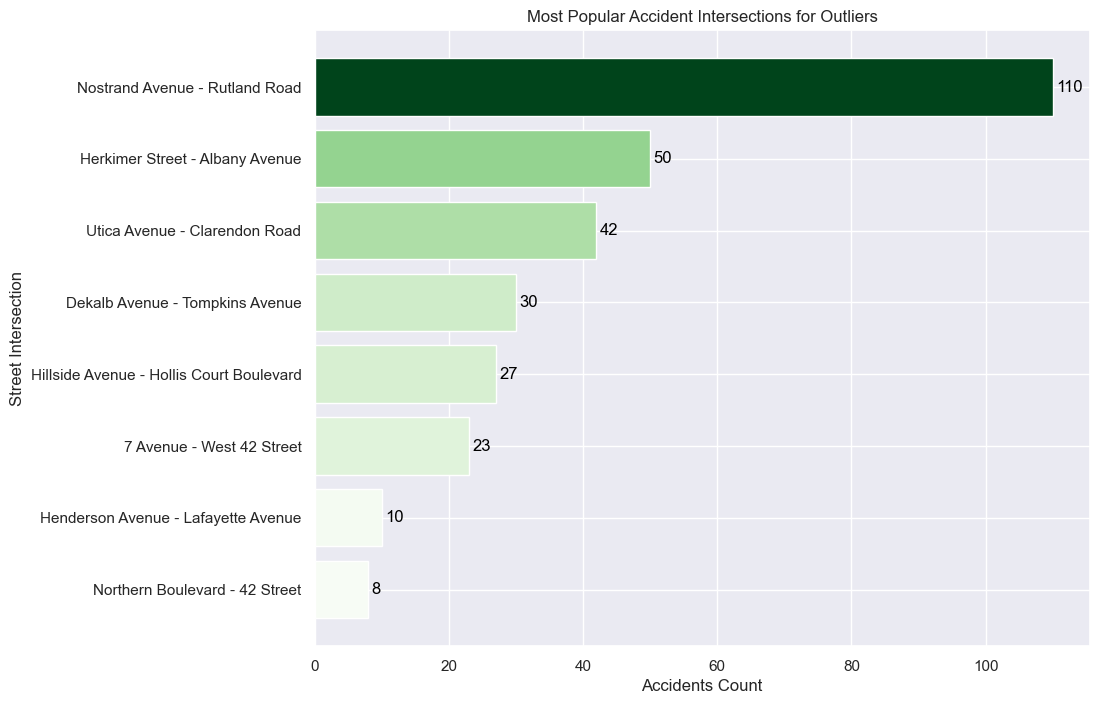

In [29]:
combinations = df.query('number_of_persons_injured > 20').groupby(['on_street_name', 'cross_street_name', 'borough']).size().reset_index(name='Count')

most_common = combinations.sort_values(
    by='Count', ascending=False
).assign(
    accident_intersection=lambda x: x.on_street_name + " - " +  x.cross_street_name,
).reset_index(drop=True)[
    ['accident_intersection', 'borough', 'Count']
]

top10 = most_common.head(10)
print(top10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.figure(figsize=(10, 8))
plt.barh(
    top10.accident_intersection,
    top10.Count,
    color=cmap(normalize(top10.Count)), edgecolor='white'
)
for i, v in enumerate(top10.Count.tolist()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Street Intersection')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections for Outliers')
plt.gca().invert_yaxis()
plt.show()

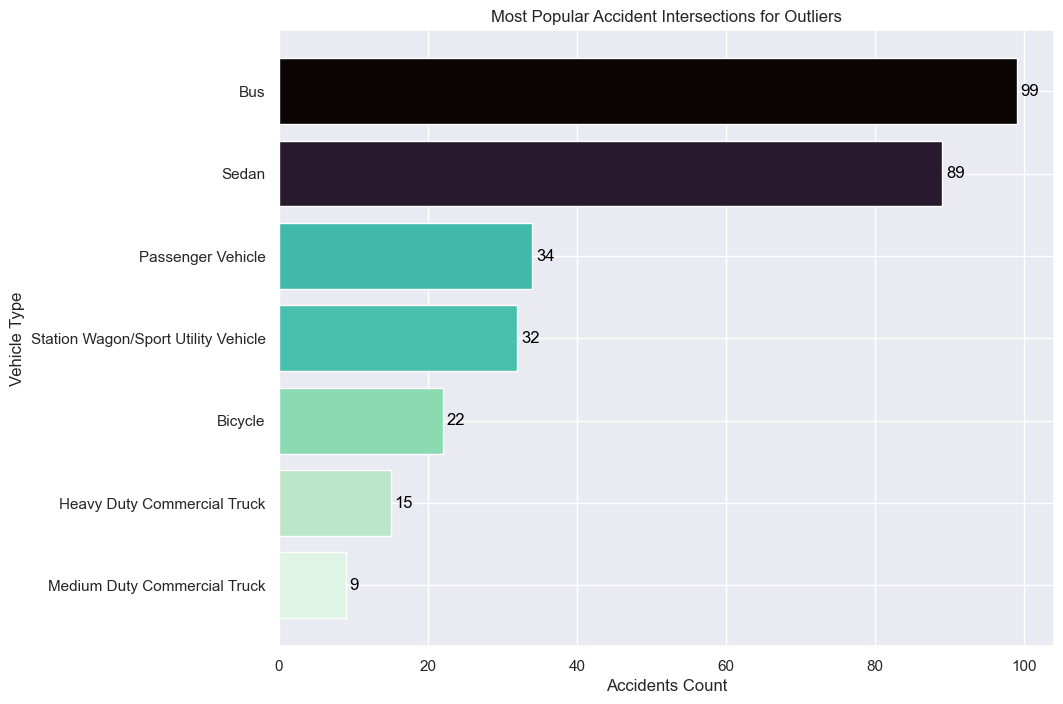

In [30]:
top10 = df.query('number_of_persons_injured > 20').vehicle_type.value_counts().reset_index(name='Count').head(10)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.figure(figsize=(10, 8))
plt.barh(
    top10.vehicle_type,
    top10.Count,
    color=cmap(normalize(top10.Count)), edgecolor='white'
)
for i, v in enumerate(top10.Count.tolist()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Vehicle Type')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections for Outliers')
plt.gca().invert_yaxis()
plt.show()

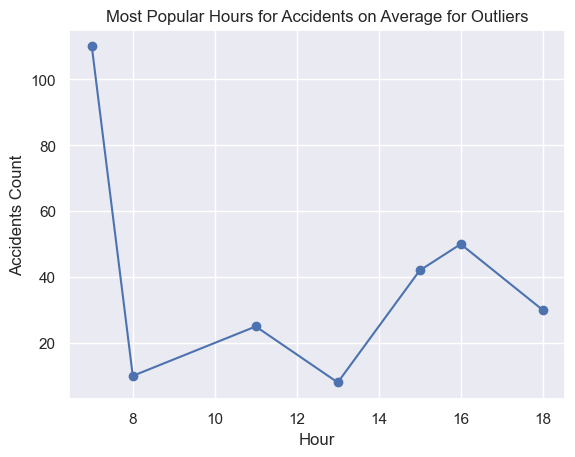

In [31]:
data = df.query('number_of_persons_injured > 20').index.value_counts(dropna=False)
data_mean = data.groupby(data.index.hour).mean()

data_mean.plot(
    marker='o', linestyle='-', color=deep_colors[0],
    xlabel='Hour', ylabel='Accidents Count',
    title='Most Popular Hours for Accidents on Average for Outliers'
)
plt.show()

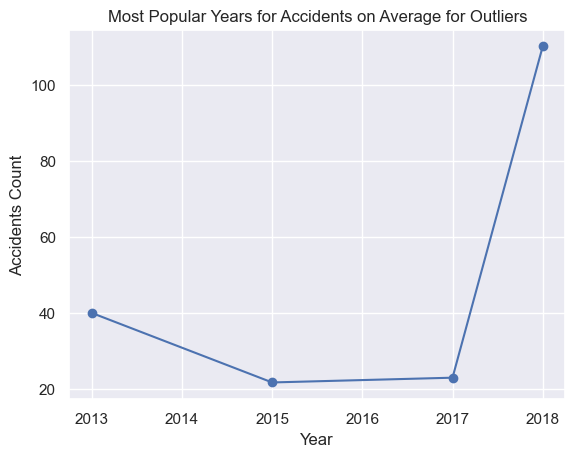

In [32]:
data = df.query('number_of_persons_injured > 20').index.value_counts(dropna=False)
data_mean = data.groupby(data.index.year).mean()

data_mean.plot(
    marker='o', linestyle='-', color=deep_colors[0],
    xlabel='Year', ylabel='Accidents Count',
    title='Most Popular Years for Accidents on Average for Outliers'
)
plt.show()

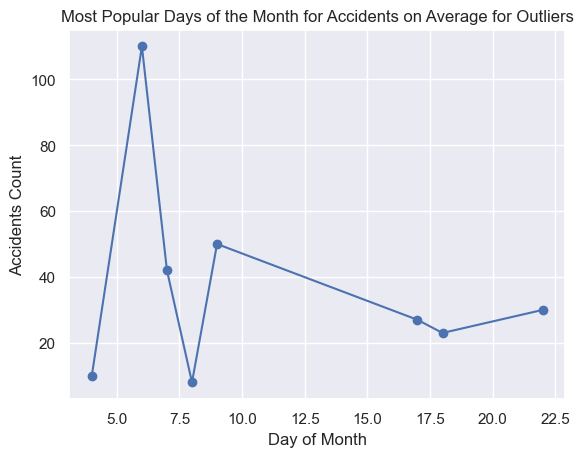

In [33]:
data = df.query('number_of_persons_injured > 20').index.value_counts(dropna=False)
data_mean = data.groupby(data.index.day).mean()

data_mean.plot(
    marker='o', linestyle='-', color=deep_colors[0],
    xlabel='Day of Month', ylabel='Accidents Count',
    title='Most Popular Days of the Month for Accidents on Average for Outliers'
)
plt.show()

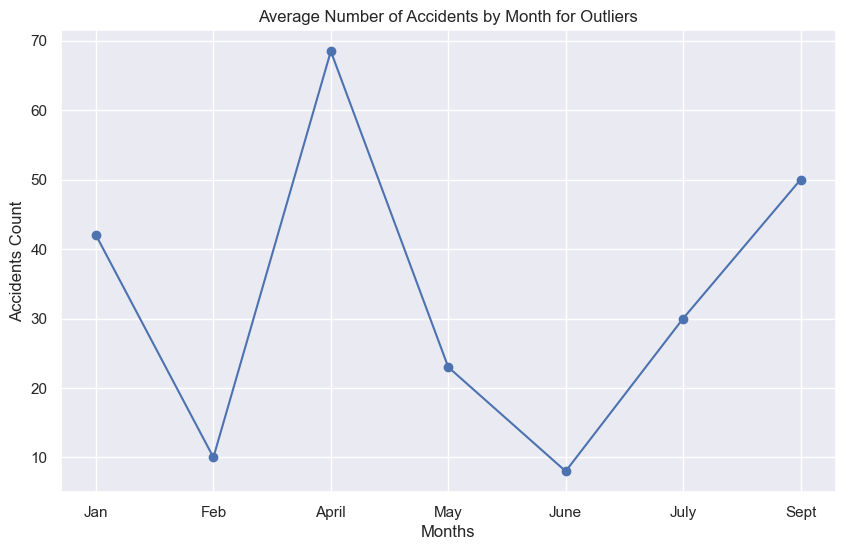

In [34]:
data = df.query('number_of_persons_injured > 20').index.value_counts()
data_mean = data.groupby(data.index.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data_mean.index = data_mean.index.map(month_mapping)

plt.figure(figsize=(10, 6))
plt.plot(
    data_mean.index, data_mean, marker='o', 
    linestyle='-', color=deep_colors[0]
    )
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Month for Outliers')
plt.show()

**Time Analysis for Complete Dataset**

On average, the months with the highest number of accidents are May & June. However, generally, each month experiences on average 7 - 8 accidents.

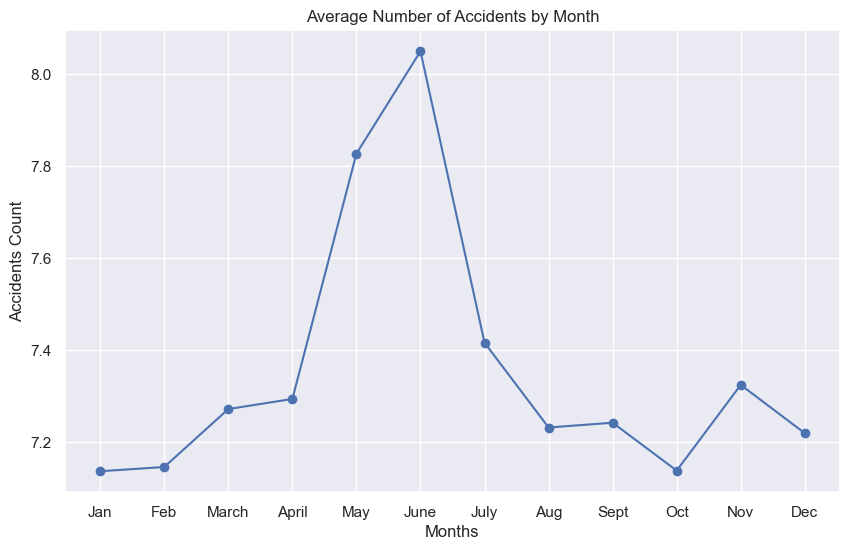

In [35]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data_mean.index = data_mean.index.map(month_mapping)

plt.figure(figsize=(10, 6))
plt.plot(
    data_mean.index, data_mean, marker='o', 
    linestyle='-', color=deep_colors[0]
    )
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Month')
plt.show()

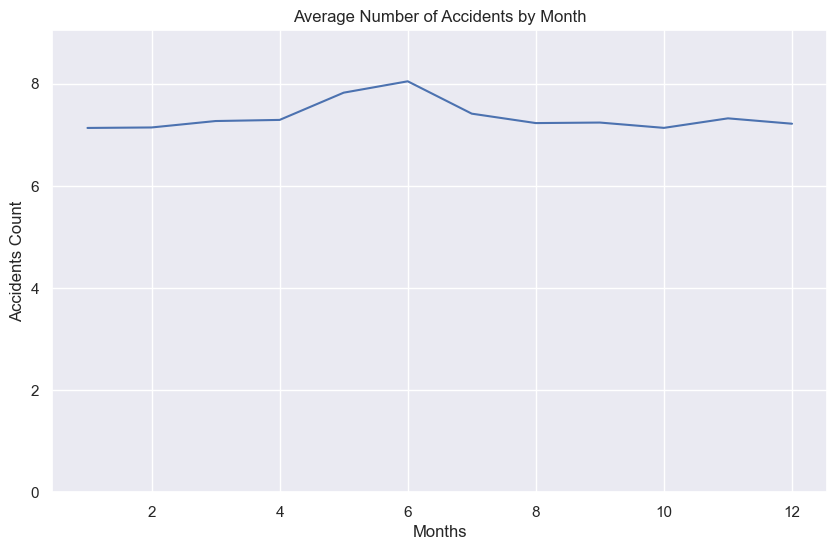

In [36]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.month).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, linestyle='-', color=deep_colors[0])
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.ylim(0, data_mean.max()+1)
plt.title('Average Number of Accidents by Month')
plt.show()

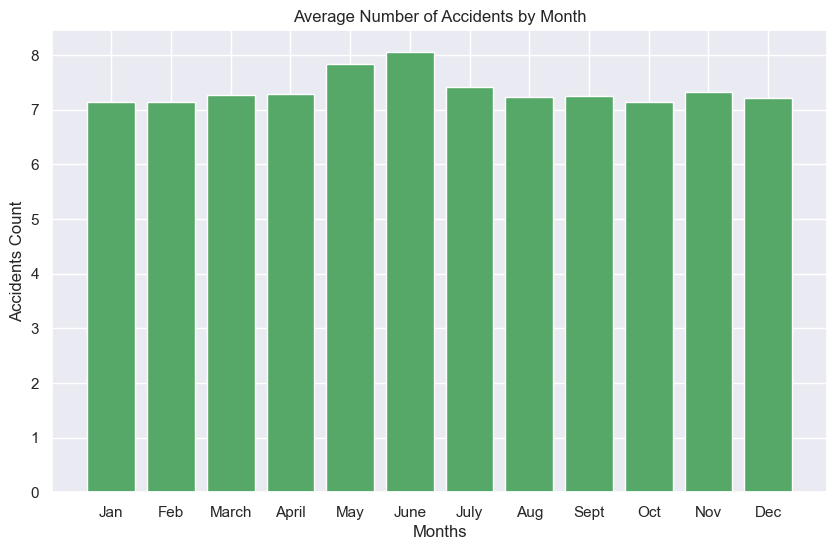

In [37]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data_mean.index = data_mean.index.map(month_mapping)

plt.figure(figsize=(10, 6))
plt.bar(data_mean.index, data_mean, color=deep_colors[1])
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Month')
plt.show()

There is a significant spike in the number of recorded accidents from 2016 which peaked in 2017. There's been a steady decline in recorded accidents year-on-year since then.

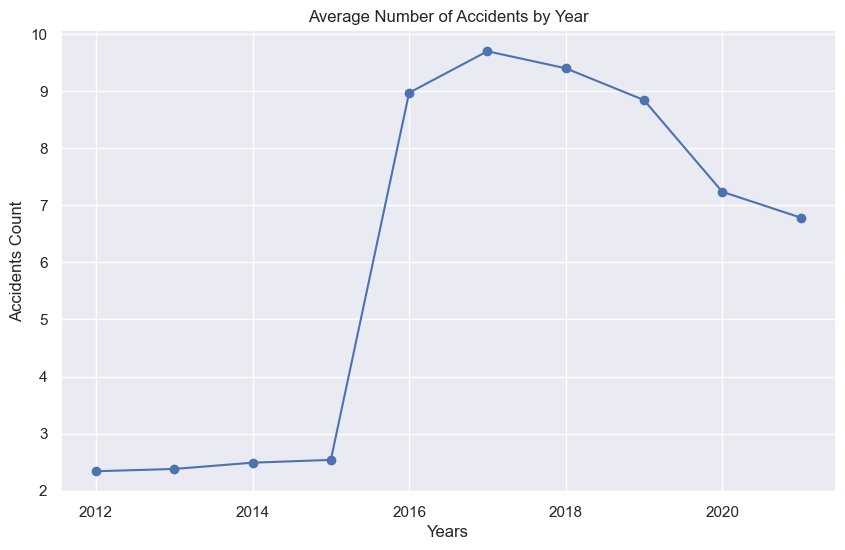

In [38]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.year).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-', color=deep_colors[0])
plt.xlabel('Years')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Year')
plt.show()

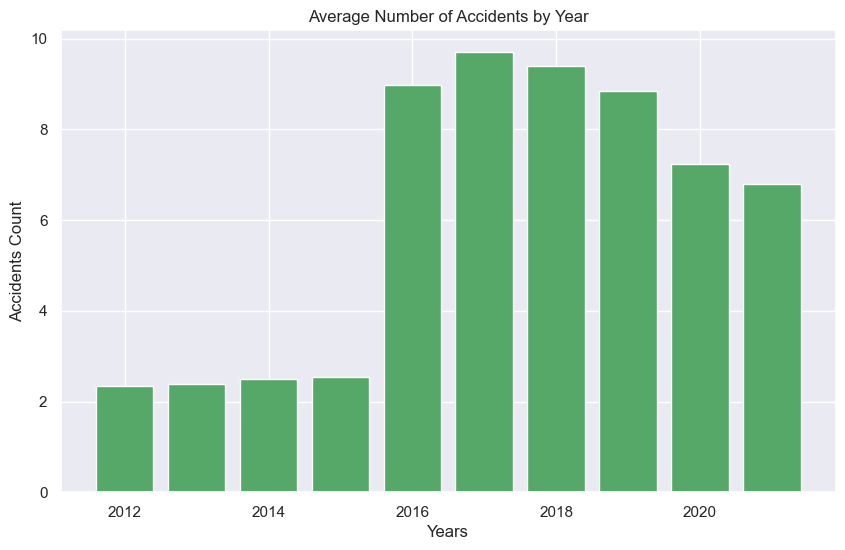

In [39]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.year).mean()

plt.figure(figsize=(10, 6))
plt.bar(data_mean.index, data_mean, color=deep_colors[1])
plt.xlabel('Years')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Year')
plt.show()

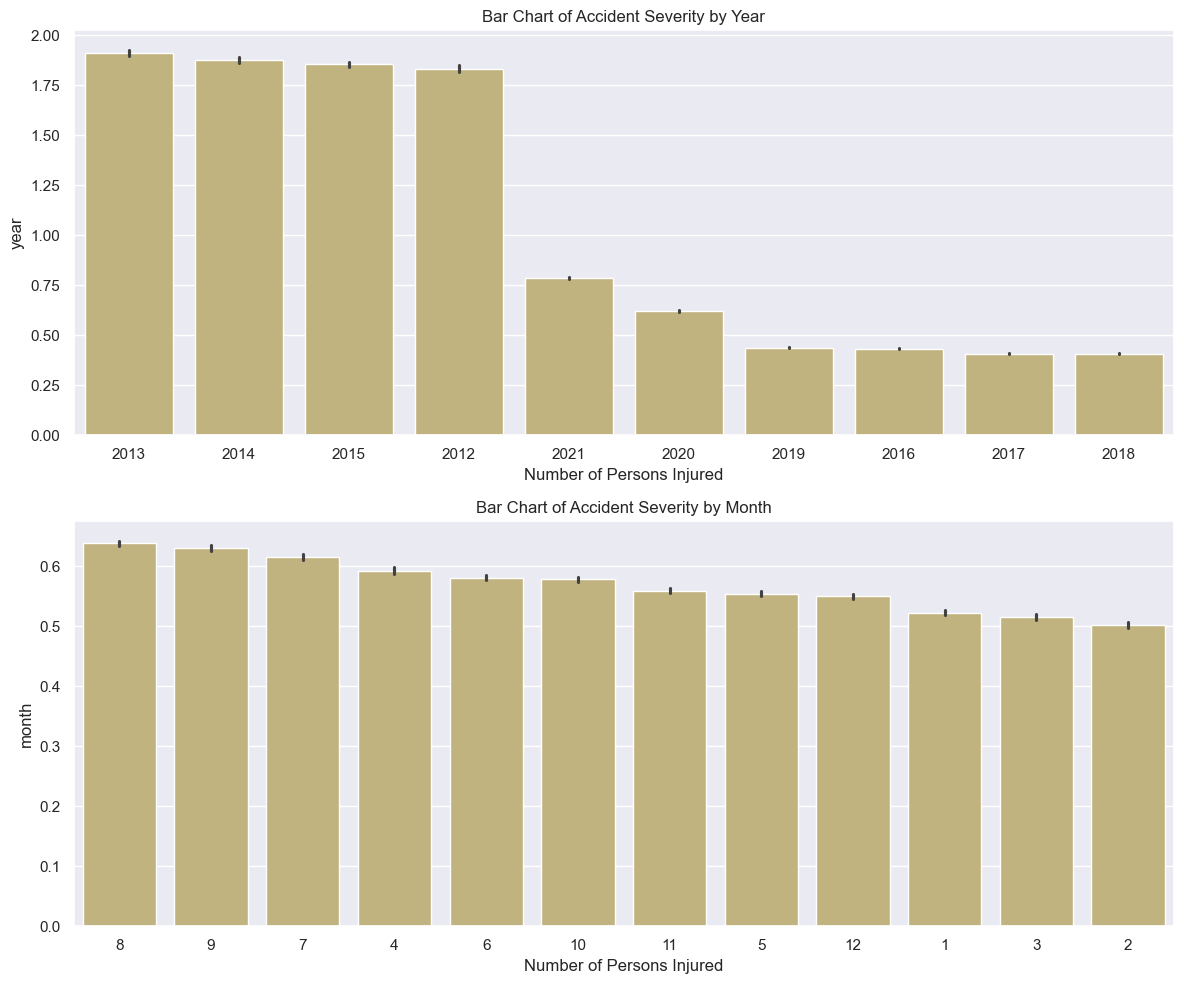

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

cols_plot = ['year', 'month']
for col, ax in zip(cols_plot, axes.ravel()):
    count_data = df.assign(
        year=lambda x: x.index.year,
        month=lambda x: x.index.month
    ).groupby(col).agg(
    {'number_of_persons_injured':'mean'}
    ).sort_values(by='number_of_persons_injured', ascending=False).reset_index()
    num_bars = len(count_data)

    sns.barplot(
        y='number_of_persons_injured', x=col, 
        data=df.assign(
            year=lambda x: x.index.year,
            month=lambda x: x.index.month
            ), 
        color=deep_colors[4], ax=ax,
        # orient='h',
        order=count_data[col],
    )
    ax.set_xlabel('Number of Persons Injured')
    ax.set_ylabel(col)
    ax.set_title(f'Bar Chart of Accident Severity by {col.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

On average, there is negligible difference in the number of accidents when distributed according to days of the month. 

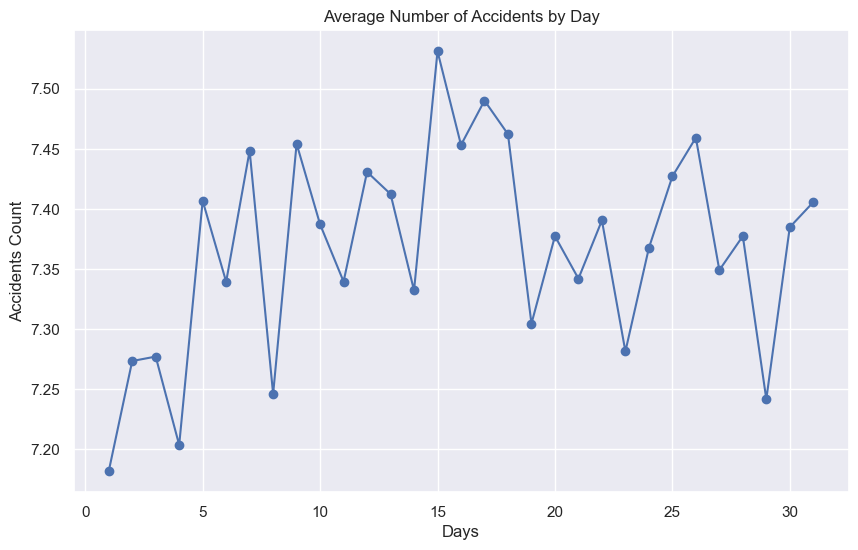

In [45]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.day).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-', color=deep_colors[0])
plt.xlabel('Days')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Day')
plt.show()

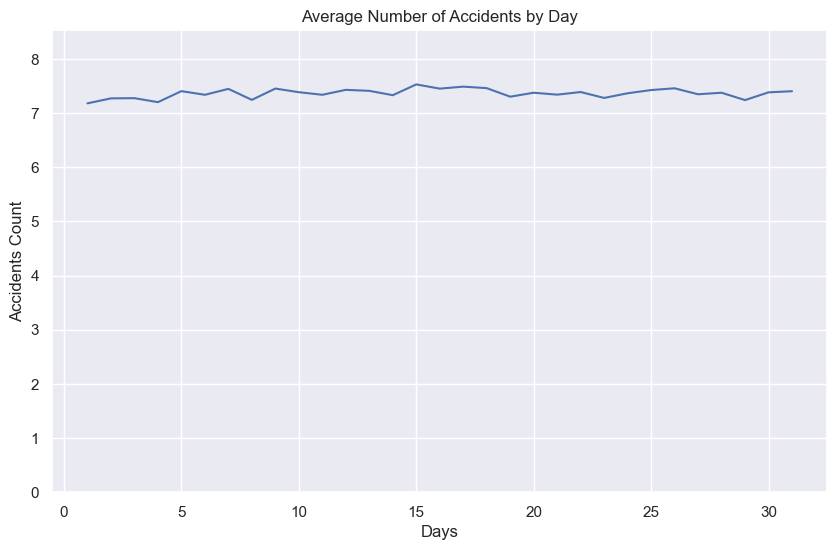

In [46]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.day).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, linestyle='-', color=deep_colors[0])
plt.xlabel('Days')
plt.ylabel('Accidents Count')
plt.ylim(0, data_mean.max()+1)
plt.title('Average Number of Accidents by Day')
plt.show()

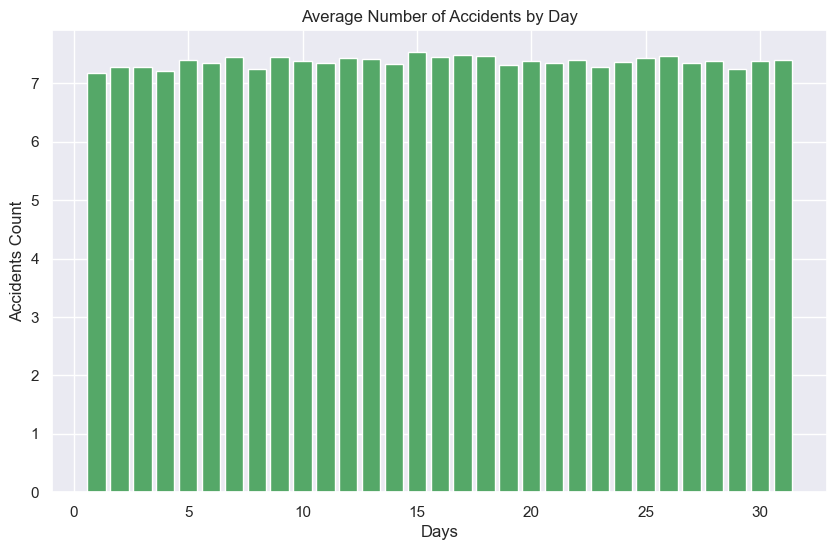

In [47]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.day).mean()

plt.figure(figsize=(10, 6))
plt.bar(data_mean.index, data_mean, color=deep_colors[1])
plt.xlabel('Days')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Day')
plt.show()

When we test whether there is a relationship between severity of the accidents and day of month, we find that no linear or rank-based relationship exists. 

<Figure size 800x600 with 0 Axes>

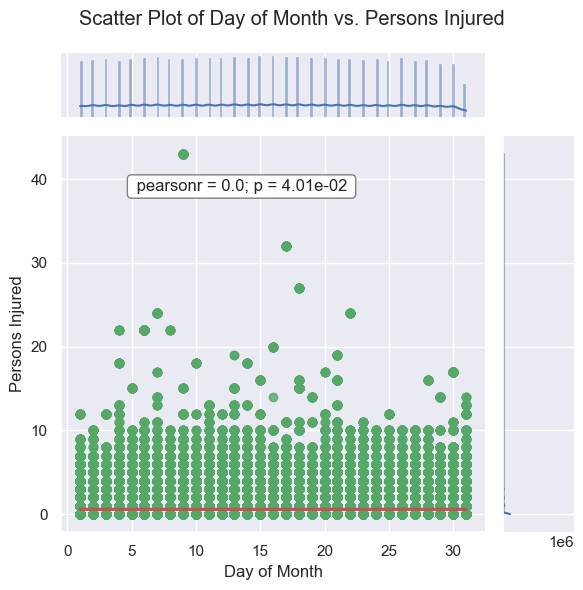

In [48]:
pearson, p = stats.pearsonr(
    df.index.day,
    df.number_of_persons_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x=df.index.day,
    y='number_of_persons_injured', data=df, kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=40,
    bbox={
        'boxstyle':'round','pad':0.25,'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Day of Month')
plt.ylabel('Persons Injured')
plt.suptitle('Scatter Plot of Day of Month vs. Persons Injured')

plt.tight_layout()
plt.show()

In [49]:
df.assign(
    day_of_month=lambda x: x.index.day
)[['day_of_month', 'number_of_persons_injured', 'number_of_persons_killed']].corr(method='spearman')

day_of_month  number_of_persons_injured  \
day_of_month                   1.000000                   0.001745   
number_of_persons_injured      0.001745                   1.000000   
number_of_persons_killed      -0.000978                   0.027428   

                           number_of_persons_killed  
day_of_month                              -0.000978  
number_of_persons_injured                  0.027428  
number_of_persons_killed                   1.000000

In [50]:
data = df.assign(day_of_month=lambda x: x.index.day)
formula = 'number_of_persons_injured ~ day_of_month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     4.213
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):             0.0401
Time:                               21:06:13   Log-Likelihood:            -4.2097e+06
No. Observations:                    2744550   AIC:                         8.419e+06
Df Residuals:                        2744548   BIC:                         8.419e+06
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

Accidents mostly occur around morning and evening rush our with peak accidents occurring at midnight:

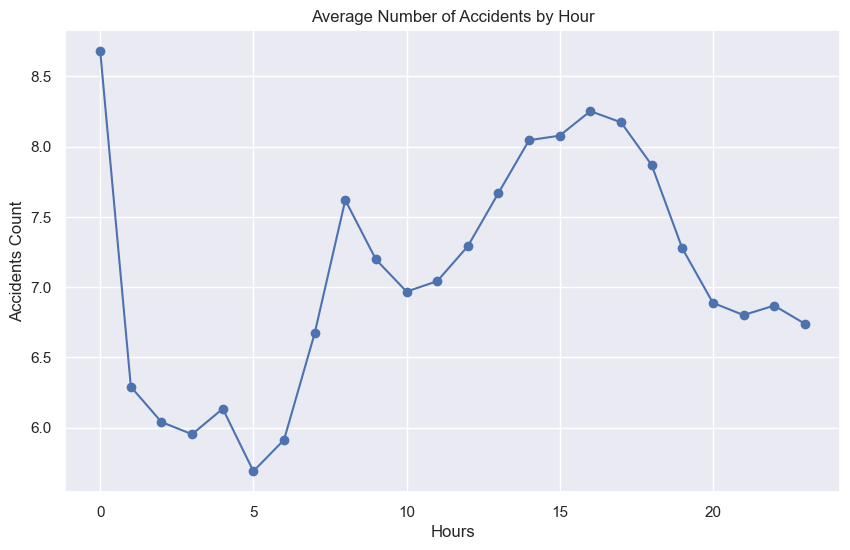

In [51]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.hour).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Hours')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Hour')
plt.show()

**Anomaly Detection**

Anomaly detection in time series data is the process of identifying data points or patterns that deviate significantly from the expected or normal behavior. Anomalies, also known as outliers, can indicate errors, unusual events, or important insights.

We'll be using the following techniques to perform anomaly detection on our data:
* Seasonal Decomposition
* Statistical Methods (Z-Score)
* Moving Average
* Exponential Smoothing

Seasonal Decomposition: 

Here, we'll decompose the time series into trend, seasonality, and residual components. Anomalies might appear as extreme values in the residual component.

In [52]:
data = df.index.value_counts()
data.head()

crash_datetime
2020-06-30 13:20:00    726
2021-01-15 18:07:00    450
2021-01-21 17:00:00    182
2018-10-17 18:10:00    182
2017-09-04 22:45:00    144
Name: count, dtype: int64

Time Series Plot:

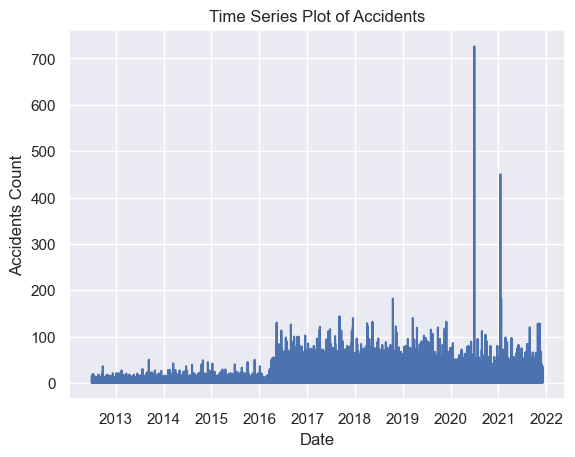

In [53]:
sns.lineplot(x='crash_datetime', y='count', data=data.reset_index())
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.title('Time Series Plot of Accidents')
plt.show()

Decompose the time series into its trend, seasonality, and residual components:

In [54]:
data = data.asfreq('D').bfill()

decomposition = seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

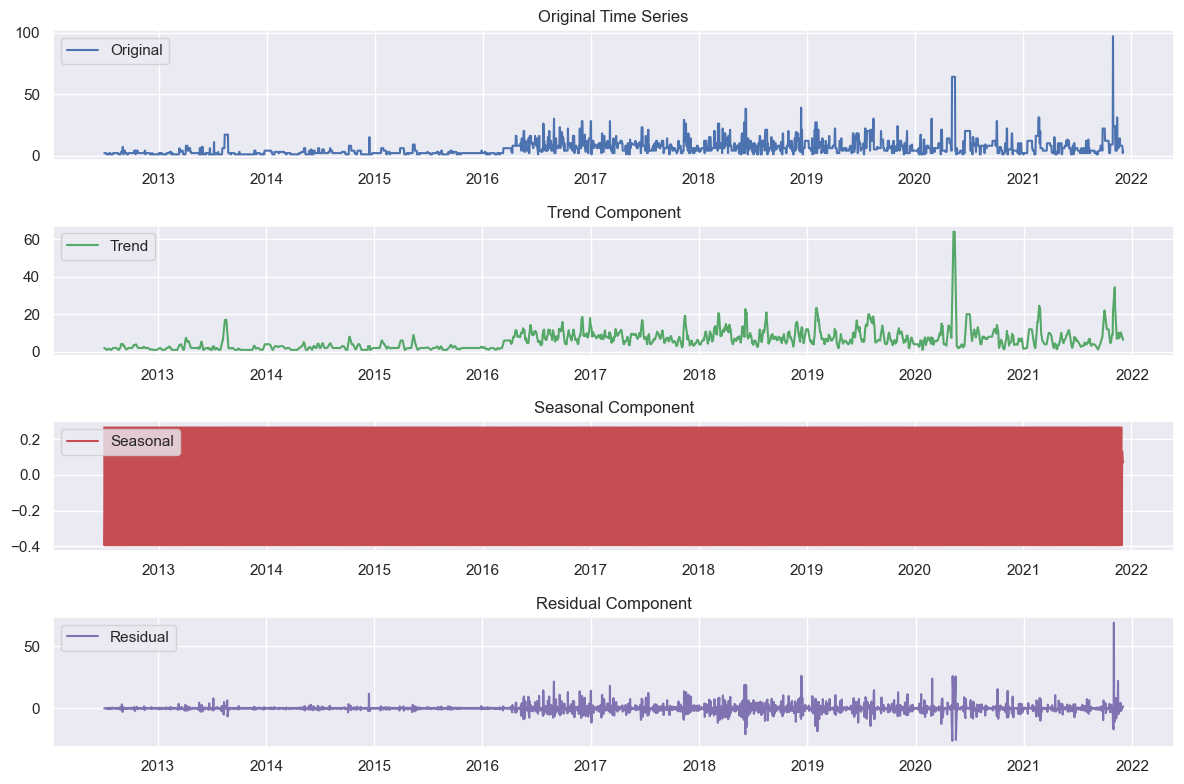

In [55]:
# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Deep dive into seasonality:

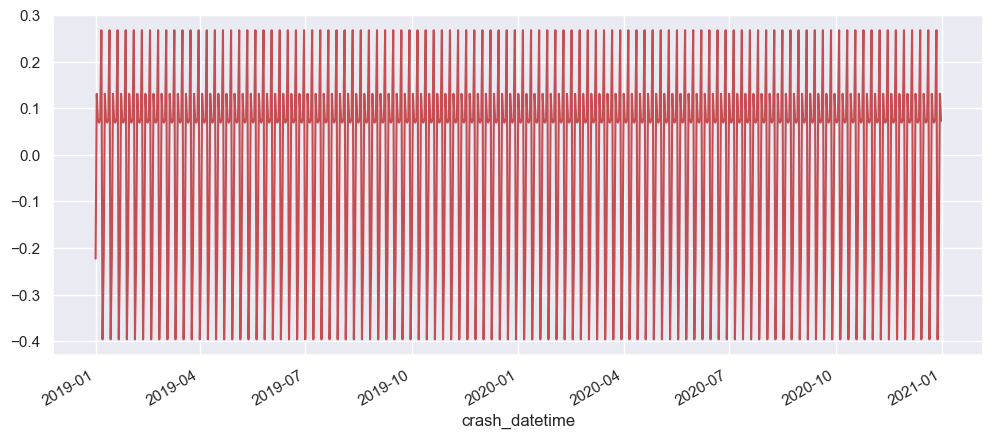

In [56]:
plt.figure(figsize=(12, 5))
decomposition.seasonal["2019":"2020"].plot(color=deep_colors[2]);

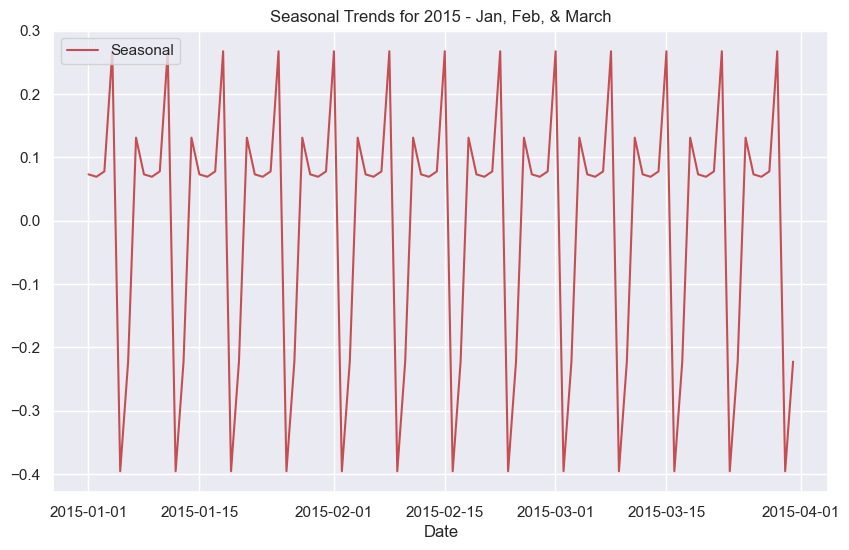

In [57]:
year = 2015
months_to_select = [1, 2, 3]  

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal', color=deep_colors[2])
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - Jan, Feb, & March')
plt.legend(loc='upper left')
plt.show()

When the seasonal plot is reduced to its lowest form, it shows a weekly spike and subsequent drop in accidents:

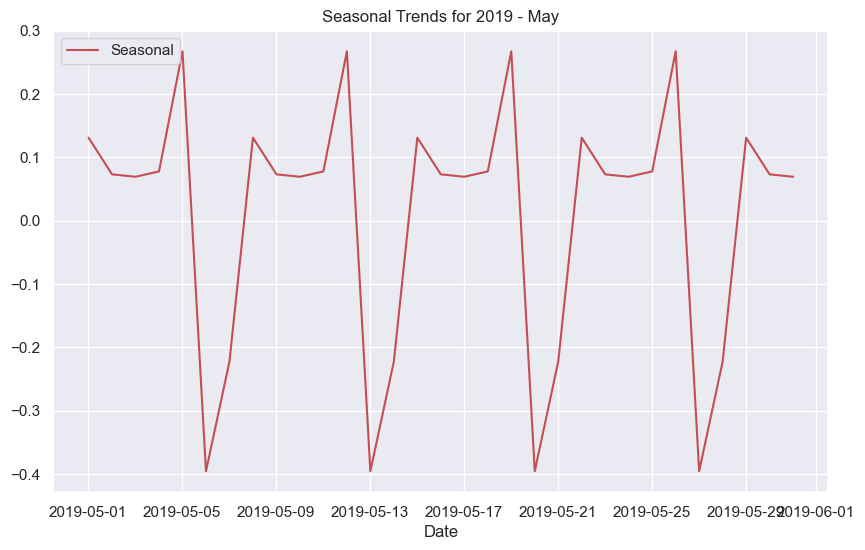

In [58]:
year = 2019
months_to_select = [5]

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal', color=deep_colors[2])
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - May')
plt.legend(loc='upper left')
plt.show()

Let's compute decomposition by Borough:

In [59]:
print(df.loc[df.borough=='Brooklyn'].index.value_counts().shape, df.loc[df.borough=='Bronx'].index.value_counts().shape, df.loc[df.borough=='Staten Island'].index.value_counts().shape)

(142948,) (70882,) (20093,)


In [60]:
seasonality_dict = dict()
trend_dict = dict()
resid_dict = dict()

for bor in df.borough.unique():
    data = df.loc[df.borough==bor].index.value_counts().asfreq(freq='D').bfill().sort_index()
    
    decomposition = seasonal_decompose(data.dropna())
    seasonality_dict[bor] = decomposition.seasonal
    trend_dict[bor] = decomposition.trend
    resid_dict[bor] = decomposition.resid

Let's plot the seasonality by Borough:

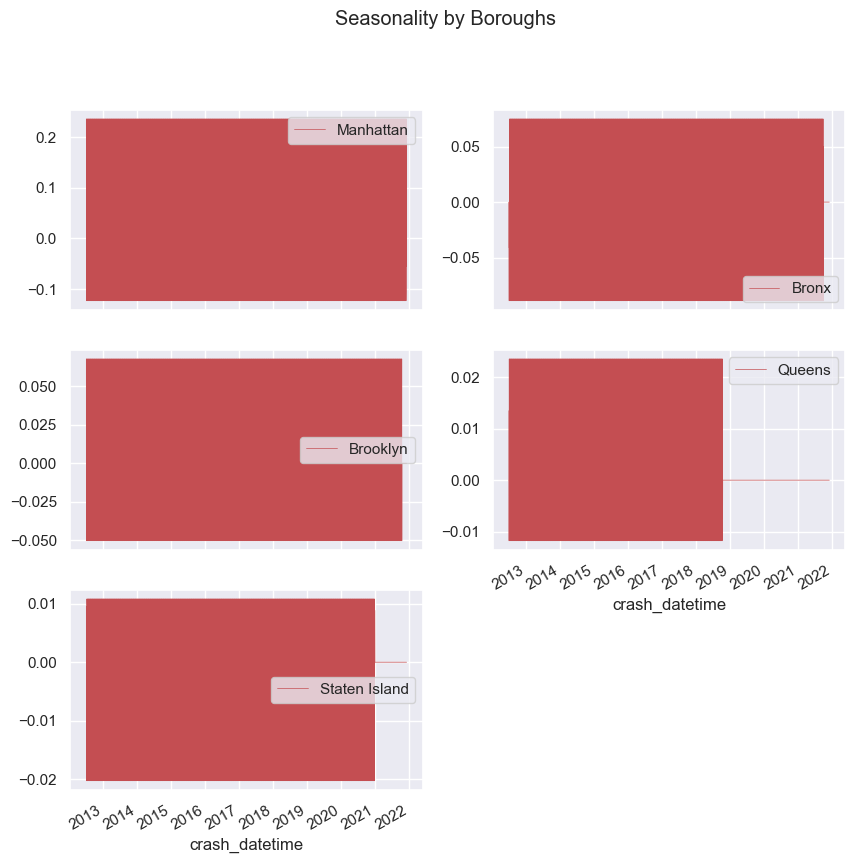

In [61]:
pd.DataFrame(seasonality_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, 
    figsize=(10, 10), title='Seasonality by Boroughs', 
    color=deep_colors[2]
);

Let's plot the trend by Borough:

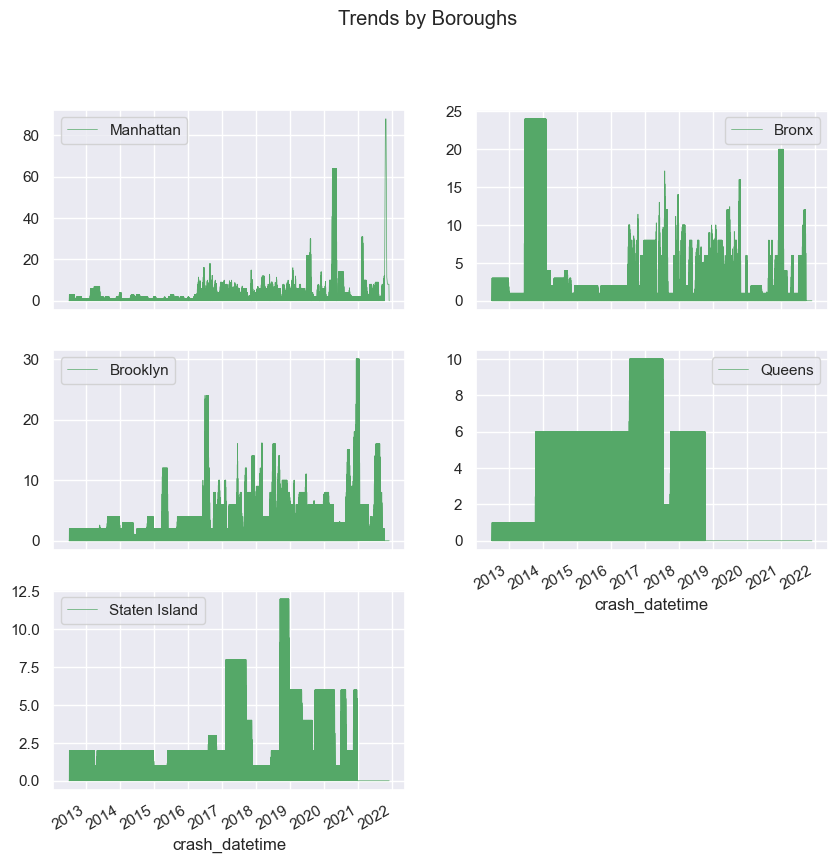

In [62]:
pd.DataFrame(trend_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, figsize=(10, 10), 
    title='Trends by Boroughs', color=deep_colors[1]
);

Let's plot the noise by Borough:

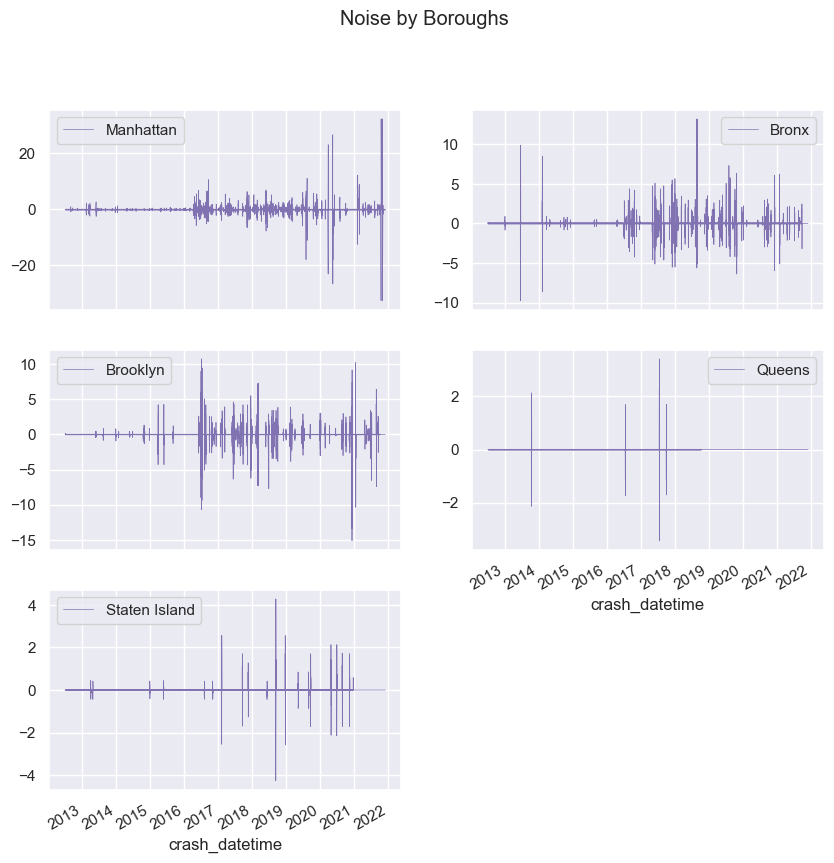

In [63]:
pd.DataFrame(resid_dict).fillna(0).plot(
    subplots=True, layout=(3, 2), linewidth=.5, 
    figsize=(10, 10), title='Noise by Boroughs', 
    color=deep_colors[3]
);

Anomaly Detection Using Statistical Methods:

We'll calculate the z-score for each data point and identify anomalies by setting a z-score threshold.

In [64]:
data = pd.DataFrame({'accidents_count': df.index.value_counts(), 'z_score':stats.zscore(df.index.value_counts().values)})
data.head()

accidents_count    z_score
crash_datetime                                 
2020-06-30 13:20:00              726  95.133657
2021-01-15 18:07:00              450  58.596381
2021-01-21 17:00:00              182  23.118156
2018-10-17 18:10:00              182  23.118156
2017-09-04 22:45:00              144  18.087661

<Figure size 1200x600 with 0 Axes>

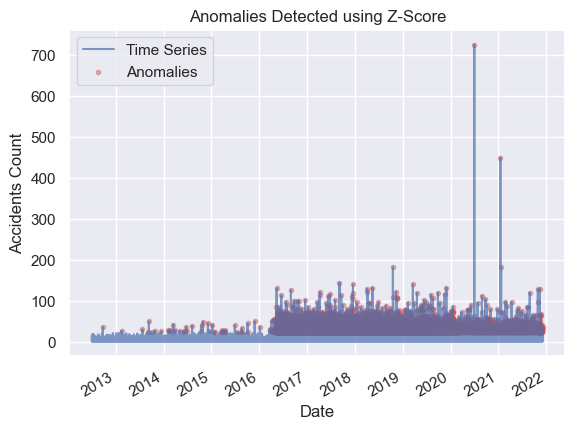

In [65]:
# Set a z-score threshold for anomaly detection
z_score_threshold = 2.0
data['anomaly_z_score'] = data.z_score.apply(lambda x: 1 if abs(x) > z_score_threshold else 0)

# Plot anomalies
plt.figure(figsize=(12, 6))
data.plot(
    y='accidents_count', label='Time Series',
    color=deep_colors[0], alpha=.7
)
plt.scatter(
    data.loc[data.anomaly_z_score == 1].index, 
    data.loc[data.anomaly_z_score == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.4,
    marker='.'
)
plt.title('Anomalies Detected using Z-Score')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()

There are 16k+ anomaly points in the dataset, which represent 4% of the accidents:

In [66]:
data.anomaly_z_score.sum(), data.shape[0], 

(15880, 372542)

In [67]:
data.anomaly_z_score.sum() / data.shape[0]

0.042626066322723345

Anomaly Detection Using Moving Average:

We'll use a rolling average and identify anomalies when data points deviate significantly from the moving average.

In [68]:
data = pd.DataFrame({'accidents_count': df.index.value_counts(), 'z_score':stats.zscore(df.index.value_counts().values)})
data.head()

accidents_count    z_score
crash_datetime                                 
2020-06-30 13:20:00              726  95.133657
2021-01-15 18:07:00              450  58.596381
2021-01-21 17:00:00              182  23.118156
2018-10-17 18:10:00              182  23.118156
2017-09-04 22:45:00              144  18.087661

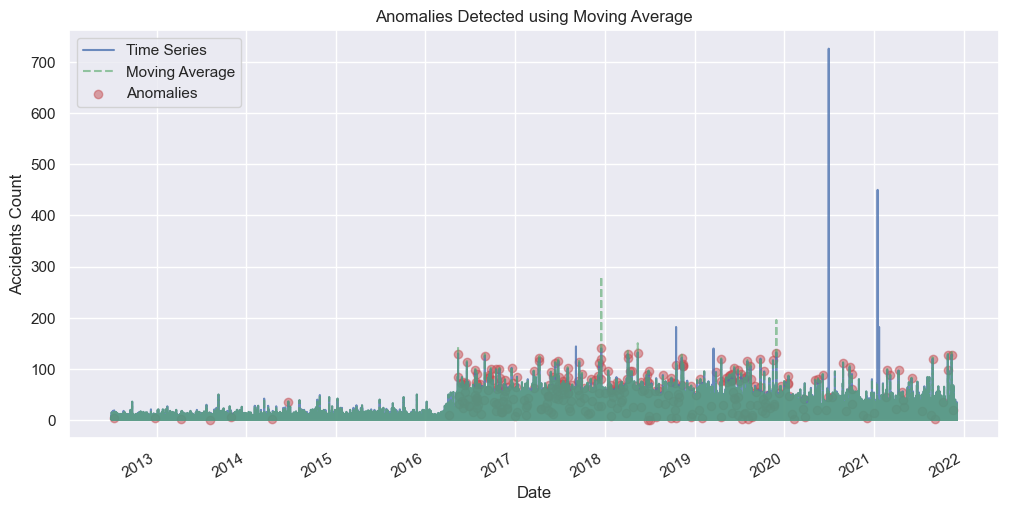

In [69]:
window_size = 7  # Adjust the window size as needed

# Calculate the moving average
data['moving_avg'] = data.accidents_count.rolling(window=window_size).mean()

# Set a threshold for anomaly detection
moving_avg_threshold = 0.5  # Adjust the threshold as needed
data['anomaly_moving_avg'] = data.accidents_count.sub(
    data.moving_avg
    ).abs().apply(lambda x: 1 if x > moving_avg_threshold else 0)

# Plot anomalies
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(
    y='accidents_count', label='Time Series',
    color=deep_colors[0], alpha=.8, ax =ax
    )
data.plot(
    y='moving_avg', label='Moving Average', linestyle='--', 
    color=deep_colors[1], alpha=.6, ax =ax
    )
ax.scatter(
    data.loc[data.anomaly_moving_avg == 1].index, 
    data.loc[data.anomaly_moving_avg == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.5
    )
plt.title('Anomalies Detected using Moving Average')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()

Exponential Smoothing:

We'll use exponential smoothing to create a smoothed version of the time series and identify anomalies when data points deviate from the smoothed values.

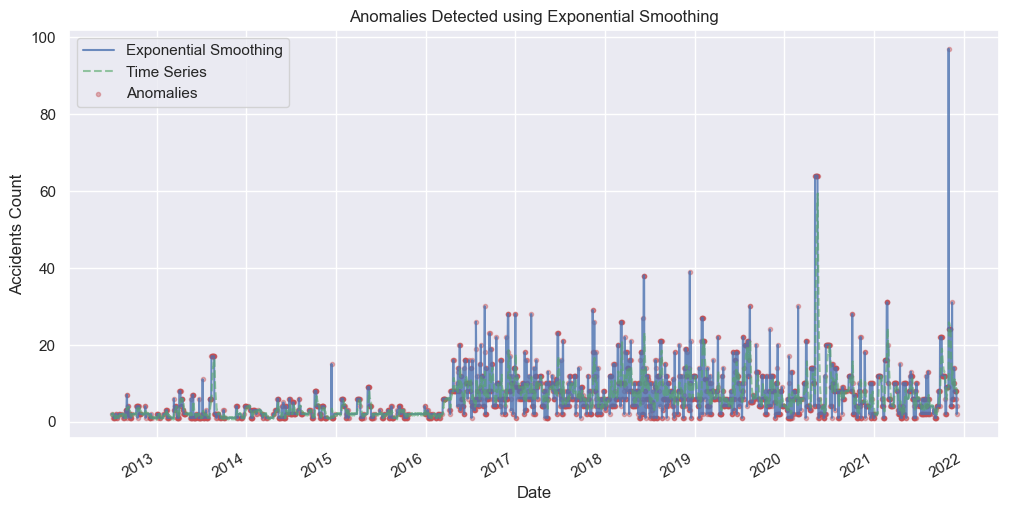

In [70]:
# Apply exponential smoothing
data2 = data.asfreq('D').bfill()
alpha = 0.2  # Smoothing parameter
data2['exponential_smoothed'] = ExponentialSmoothing(
    data2.accidents_count, trend='add', seasonal='add',
    seasonal_periods=7, initialization_method='estimated', 
    freq='D'
    ).fit(smoothing_level=alpha).fittedvalues

# Set a threshold for anomaly detection
exp_smoothing_threshold = 0.5
data2['anomaly_exp_smoothing'] = data2.accidents_count.sub(
    data2.exponential_smoothed
    ).abs().apply(lambda x: 1 if x > exp_smoothing_threshold else 0)

# Plot anomalies
fig, ax = plt.subplots(figsize=(12, 6))
data2.plot(
    y='accidents_count', label='Exponential Smoothing',
    color=deep_colors[0], alpha=.8, ax=ax
    )
data2.plot(
    y='exponential_smoothed', label='Time Series', linestyle='--',
    color=deep_colors[1], alpha=.6, ax=ax
    )
ax.scatter(
    data2.loc[data2.anomaly_exp_smoothing == 1].index, 
    data2.loc[data2.anomaly_exp_smoothing == 1].accidents_count, 
    color=deep_colors[2], label='Anomalies', alpha=.4, marker='.'
    )
plt.title('Anomalies Detected using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.legend()
plt.show()


4. Accident Trends over time

Plotting Time Series of Accidents by Borough

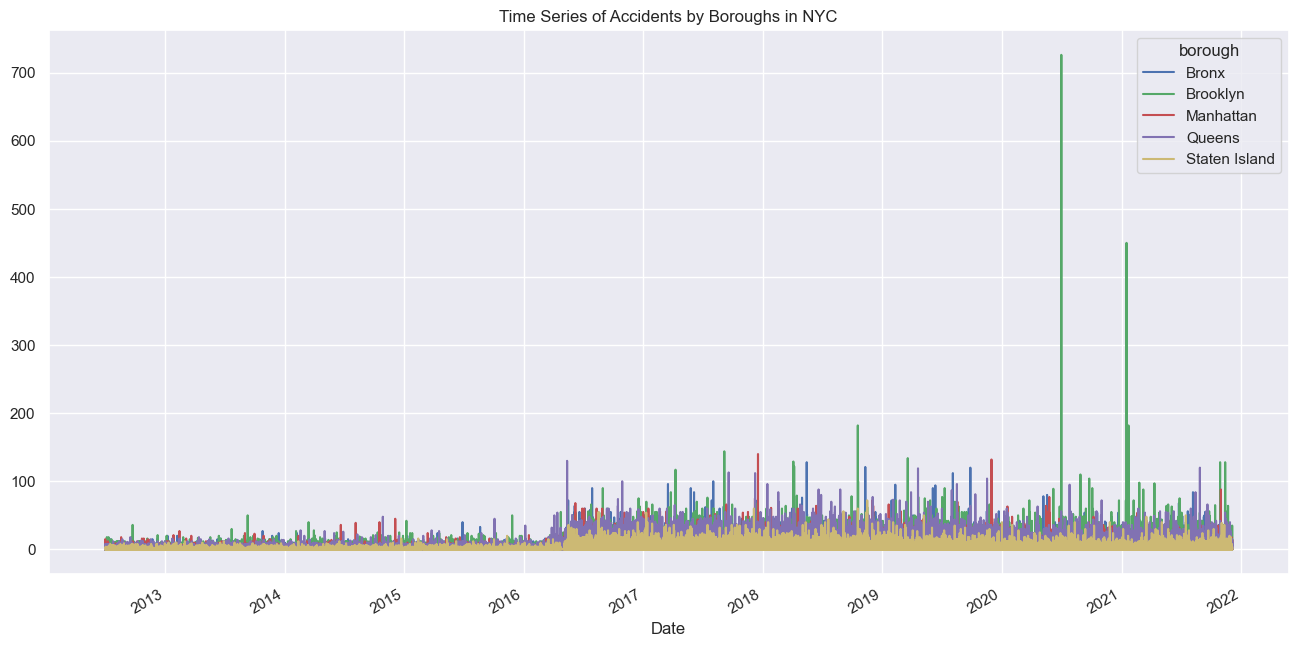

In [71]:
data = df.groupby([df.index, 'borough']).collision_id.size().unstack().fillna(0)

data.plot(
    figsize=(16, 8), title="Time Series of Accidents by Boroughs in NYC", color=deep_colors[:5]
)
plt.xlabel("Date");

Trend for Average Counts shows similar trends across boroughs. Trend seems to tend downwards after a sharp spike in 2016, although Manhattan & Queens saw more significant drops than others in 2020.

<Figure size 700x500 with 0 Axes>

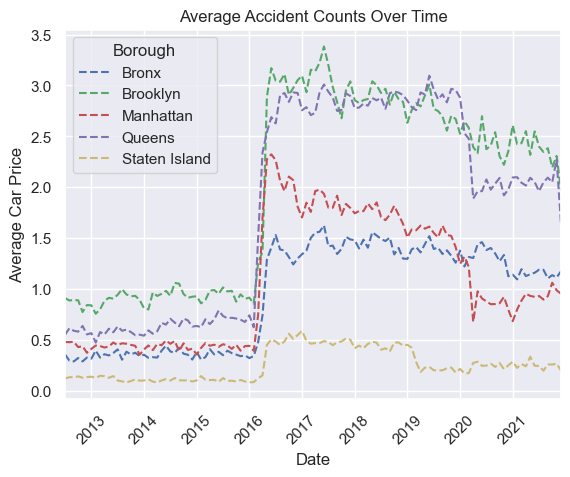

In [72]:
monthly_mean = data.resample('M').mean().interpolate()

plt.figure(figsize=(7, 5))
monthly_mean.plot(
    linestyle='--', color=deep_colors[:5],
    title='Average Accident Counts Over Time',
    xlabel='Date', ylabel='Average Car Price'
)
plt.xticks(rotation=45)
plt.legend(title='Borough')
plt.show()

**Numeric Distributions**

5. How many victims on average per accident?
6. Registration Year for cars in accidents.

In [73]:
victim_cols = [
    'number_of_persons_injured', 'number_of_persons_killed', 
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

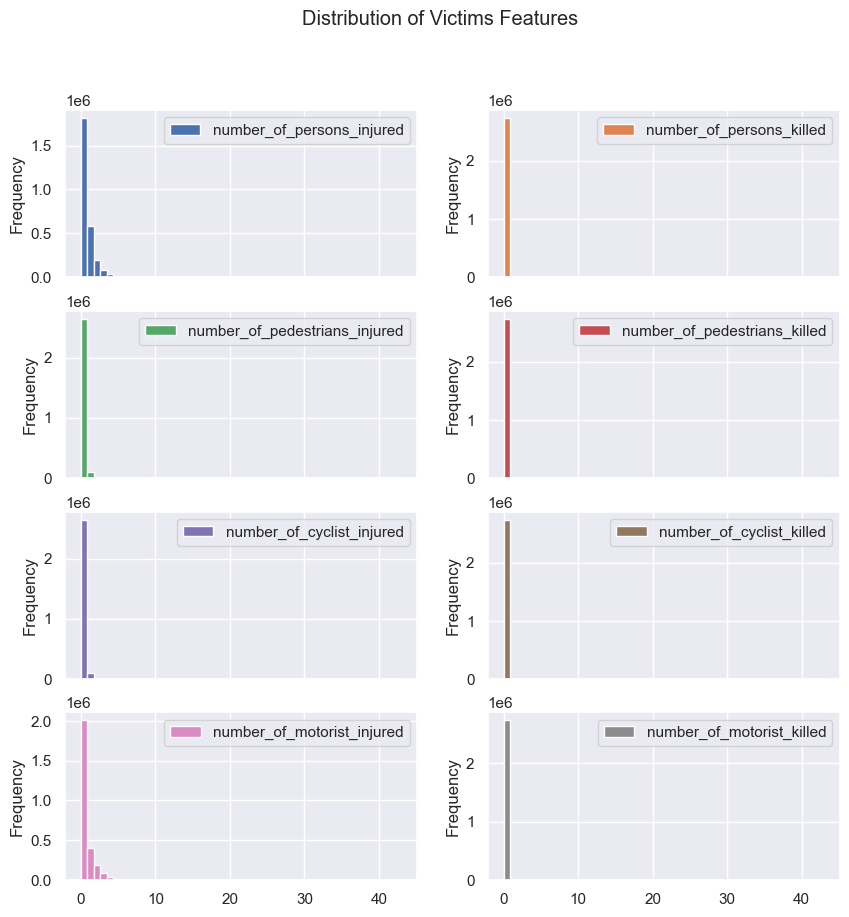

In [74]:
df[victim_cols].plot(
    subplots=True, layout=(4, 2), kind='hist', bins=50,
    figsize=(10, 10), title='Distribution of Victims Features'
);

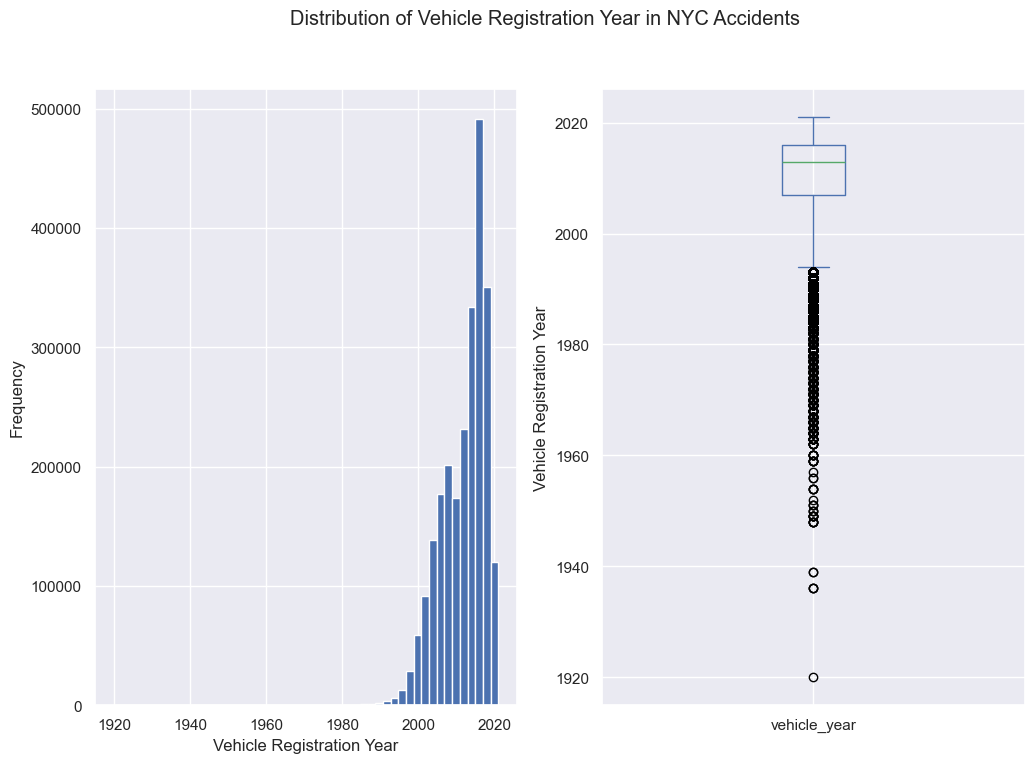

In [75]:
plt.figure(figsize=(12, 8))

plt.subplot(121)
df.vehicle_year.plot(kind='hist', bins=50, xlabel='Vehicle Registration Year')

plt.subplot(122)
df.vehicle_year.plot(kind='box', ylabel='Vehicle Registration Year')

plt.suptitle('Distribution of Vehicle Registration Year in NYC Accidents')
plt.show()

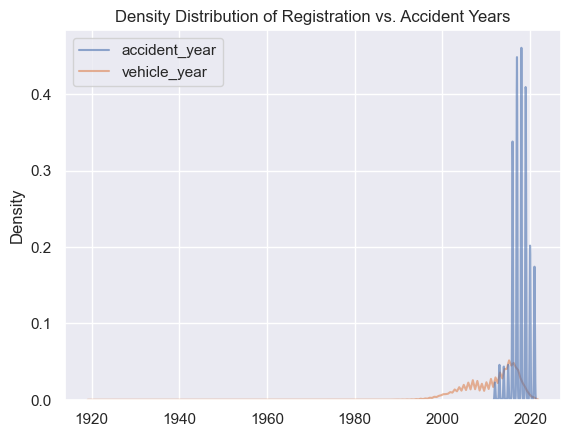

In [76]:
sns.kdeplot(
    data=df.assign(
        accident_year=lambda x: x.index.year
        )[['accident_year', 'vehicle_year']],
    color=deep_colors[-2:], alpha=.6,
    legend=True
)

plt.title('Density Distribution of Registration vs. Accident Years')
plt.show()

**Likelihood Analysis**

7. Using vehicle year, what is the likelihood that an accident will result in injury or death?

In [77]:
data = df[['vehicle_year', 'number_of_persons_injured', 'number_of_persons_killed']]
data.sample(5)

vehicle_year  number_of_persons_injured  \
crash_datetime                                                 
2020-02-25 20:50:00           NaN                          1   
2019-01-06 18:00:00        2011.0                          0   
2019-02-24 06:34:00        2018.0                          1   
2016-12-24 13:28:00        2004.0                          1   
2017-05-17 10:24:00        1999.0                          0   

                     number_of_persons_killed  
crash_datetime                                 
2020-02-25 20:50:00                         0  
2019-01-06 18:00:00                         0  
2019-02-24 06:34:00                         0  
2016-12-24 13:28:00                         0  
2017-05-17 10:24:00                         0

12% of the dataset does not have information for vehicle year. We'll replace it with the average:

In [78]:
df.vehicle_year.isnull().sum() / df.shape[0]

0.11645078428157621

In [79]:
df.vehicle_year.describe()

count    2.424945e+06
mean     2.011432e+03
std      5.817887e+00
min      1.920000e+03
25%      2.007000e+03
50%      2.013000e+03
75%      2.016000e+03
max      2.021000e+03
Name: vehicle_year, dtype: float64

If we replace the missing values with the average, we have a new mode, but otherwise, the spread is not oo different. We'll go ahead and apply the replacement.

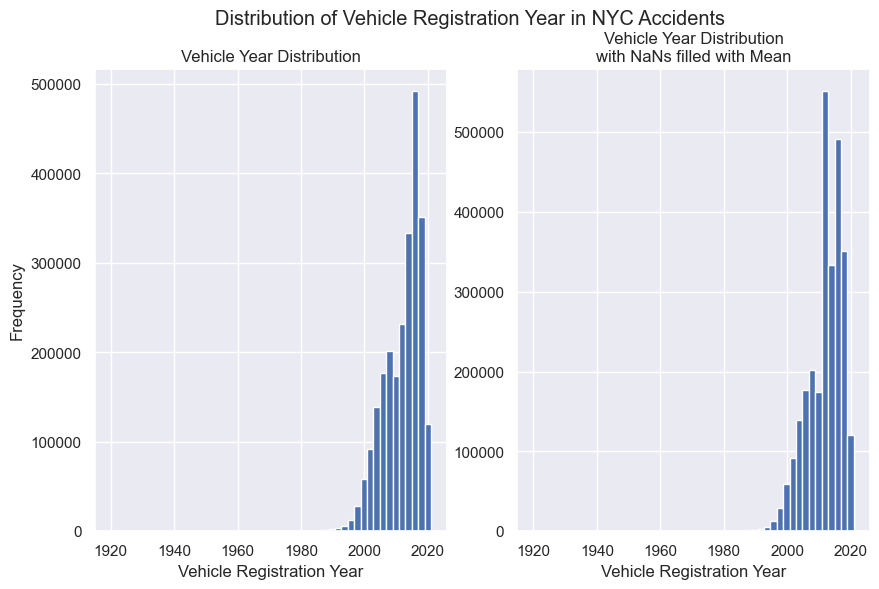

In [80]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
df.vehicle_year.plot(
    kind='hist', bins=50, 
    xlabel='Vehicle Registration Year',
    title='Vehicle Year Distribution'
    )

plt.subplot(122)
df.vehicle_year.fillna(int(df.vehicle_year.mean())).astype(float).plot(
    kind='hist', bins=50, 
    xlabel='Vehicle Registration Year',
    title='Vehicle Year Distribution\nwith NaNs filled with Mean',
    ylabel=''
)

plt.suptitle('Distribution of Vehicle Registration Year in NYC Accidents')
plt.show()

In [81]:
data['vehicle_year'] = data['vehicle_year'].fillna(int(data.vehicle_year.mean())).astype(float)
data.head()

/var/folders/t4/x7zw1vdd2gx4d5lg3pnpdnwm0000gn/T/ipykernel_25706/444811767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vehicle_year'] = data['vehicle_year'].fillna(int(data.vehicle_year.mean())).astype(float)


vehicle_year  number_of_persons_injured  \
crash_datetime                                                 
2012-07-01 00:30:00        2011.0                          1   
2012-07-01 00:30:00        2011.0                          1   
2012-07-01 00:37:00        2011.0                          1   
2012-07-01 00:37:00        2011.0                          1   
2012-07-01 01:00:00        2011.0                          1   

                     number_of_persons_killed  
crash_datetime                                 
2012-07-01 00:30:00                         0  
2012-07-01 00:30:00                         0  
2012-07-01 00:37:00                         0  
2012-07-01 00:37:00                         0  
2012-07-01 01:00:00                         0

In [82]:
grouped = data.groupby(by='vehicle_year')[
    ['number_of_persons_injured', 'number_of_persons_killed']
    ].agg(['mean', 'median', 'sum'])
grouped

number_of_persons_injured               number_of_persons_killed  \
                                  mean median    sum                     mean   
vehicle_year                                                                    
1920.0                        1.000000    1.0      1                 0.000000   
1936.0                        1.000000    1.0      3                 0.000000   
1939.0                        0.000000    0.0      0                 0.000000   
1948.0                        0.000000    0.0      0                 0.000000   
1949.0                        0.500000    0.5      3                 0.000000   
...                                ...    ...    ...                      ...   
2017.0                        0.435617    0.0  94335                 0.001445   
2018.0                        0.460085    0.0  61684                 0.001708   
2019.0                        0.543706    0.0  41643                 0.002298   
2020.0                        0.691241    0.0  21134                 0.004317   
2021.0                        0.764077    0.0   9784                 0.004061   

                          
             median  sum  
vehicle_year              
1920.0          0.0    0  
1936.0          0.0    0  
1939.0          0.0    0  
1948.0          0.0    0  
1949.0          0.0    0  
...             ...  ...  
2017.0          0.0  313  
2018.0          0.0  229  
2019.0          0.0  176  
2020.0          0.0  132  
2021.0          0.0   52  

[73 rows x 6 columns]

How does the distribution of accident severity vary by vehicle year?

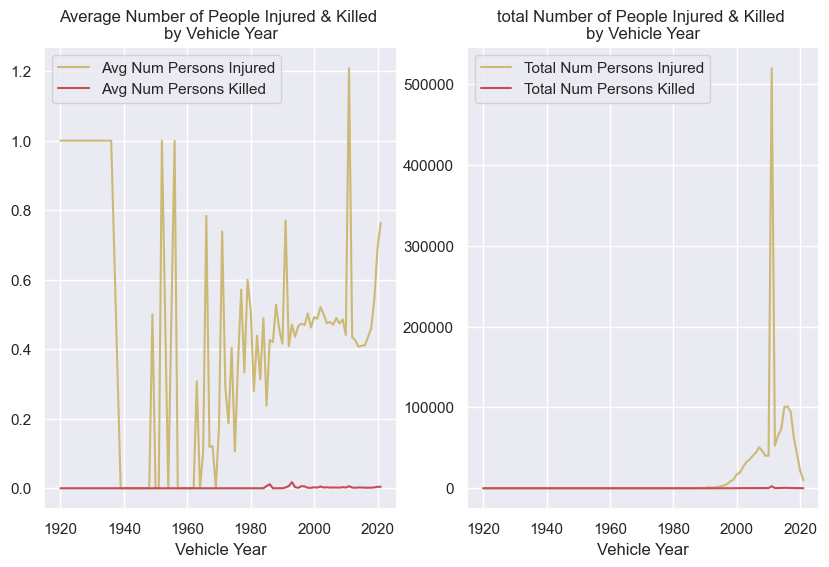

In [83]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
grouped[('number_of_persons_injured', 'mean')].plot(
    xlabel='Vehicle Year', color=deep_colors[4], legend=True, 
    label='Avg Num Persons Injured'
    )
grouped[('number_of_persons_killed', 'mean')].plot(
    xlabel='Vehicle Year', color=deep_colors[2], legend=True,
    label='Avg Num Persons Killed',
    title='Average Number of People Injured & Killed \nby Vehicle Year'
    )

plt.subplot(122)
grouped[('number_of_persons_injured', 'sum')].plot(
    xlabel='Vehicle Year', color=deep_colors[4], legend=True, 
    label='Total Num Persons Injured'
    )
grouped[('number_of_persons_killed', 'sum')].plot(
    xlabel='Vehicle Year', color=deep_colors[2], legend=True,
    label='Total Num Persons Killed',
    title='total Number of People Injured & Killed \nby Vehicle Year'
    )

plt.show()

Let's test the hypotheses presented in these charts:

In [84]:
formula = 'number_of_persons_injured ~ vehicle_year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     720.4
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):          1.17e-158
Time:                               21:07:17   Log-Likelihood:            -4.2093e+06
No. Observations:                    2744550   AIC:                         8.419e+06
Df Residuals:                        2744548   BIC:                         8.419e+06
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [85]:
formula = 'number_of_persons_injured ~ vehicle_year'
model = smf.ols(formula, data=data.assign(
    vehicle_year=lambda x: x.vehicle_year.astype(str)
))
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.061
Model:                                   OLS   Adj. R-squared:                  0.061
Method:                        Least Squares   F-statistic:                     2497.
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                               21:07:53   Log-Likelihood:            -4.1226e+06
No. Observations:                    2744550   AIC:                         8.245e+06
Df Residuals:                        2744477   BIC:                         8.246e+06
Df Model:                                 72                                         
Covariance Type:                   nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

**Text Analysis**

8. Reasons for accidents.

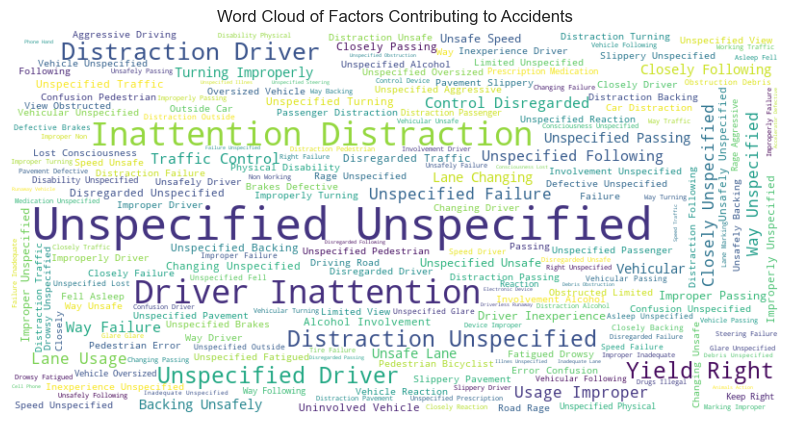

In [86]:
text = ' '.join(df['contributing_factor_1'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Factors Contributing to Accidents")
plt.show()

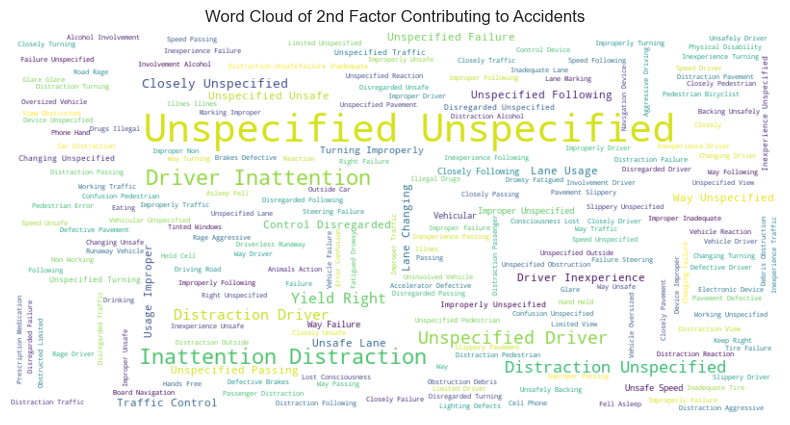

In [87]:
text = ' '.join(df['contributing_factor_2'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of 2nd Factor Contributing to Accidents")
plt.show()

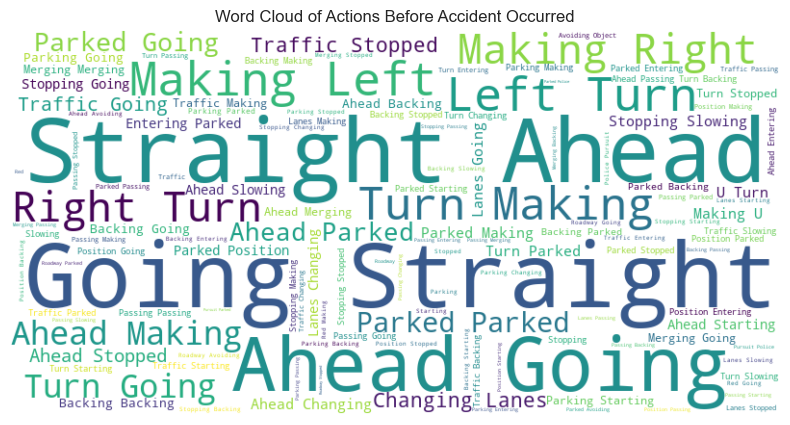

In [88]:
text = ' '.join(df['pre_crash'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Actions Before Accident Occurred")
plt.show()

**Most Popular Accident Intersections**

9. Which street corner / intersection is prone to accidents?

Most accidents occur around Flatbush Avenue Extension & Tillary Street (3708) in Brooklyn. This intersection is home to 2 hotels and a park. It has a traffic light and a speed limit of 25mph. The intersection is featured in a legal article on [dangerous intersections](https://www.thebarnesfirm.com/tillary-st-flatbush-ave-dangerous-intersections/#:~:text=drivers%20at%20risk.-,Speed,at%20risk%20of%20an%20accident).

Located just off I-278, this intersection has a lot of traffic coming from and going to the high-speed interstate; but these are surface streets with a 25mph speed limit. With nearby parks and hotels, this intersection also features a lot of foot traffic, making it even more dangerous for pedestrians crossing the street.

Since much of the traffic here is coming from the Manhattan Bridge or Interstate 278, many of the vehicles here may be moving much faster than what the speed limit permits.

The Bronx Borough has the majority of accident intersections.

In [89]:
combinations = df.groupby(['on_street_name', 'cross_street_name', 'borough']).size().reset_index(name='Count')

most_common = combinations.sort_values(
    by='Count', ascending=False
).assign(
    accident_intersection=lambda x: x.on_street_name + " - " +  x.cross_street_name,
).reset_index(drop=True)[
    ['accident_intersection', 'borough', 'Count']
]

top10 = most_common.head(10)
top10

accident_intersection   borough  Count
0  West Fordham Road - Major Deegan Expressway     Bronx   2843
1   Flatbush Avenue Extension - Tillary Street  Brooklyn   1948
2      Bruckner Boulevard - Hunts Point Avenue     Bronx   1904
3        Rockaway Boulevard - Brewer Boulevard    Queens   1893
4   Tillary Street - Flatbush Avenue Extension  Brooklyn   1722
5        North Conduit Avenue - Cohancy Street    Queens   1601
6     East Gun Hill Road - Bronx River Parkway     Bronx   1586
7       Rockaway Boulevard - Farmers Boulevard    Queens   1585
8            Atlantic Avenue - Eastern Parkway  Brooklyn   1403
9      Hunts Point Avenue - Bruckner Boulevard     Bronx   1392

In [90]:
top10.borough.value_counts()

borough
Bronx       4
Brooklyn    3
Queens      3
Name: count, dtype: int64

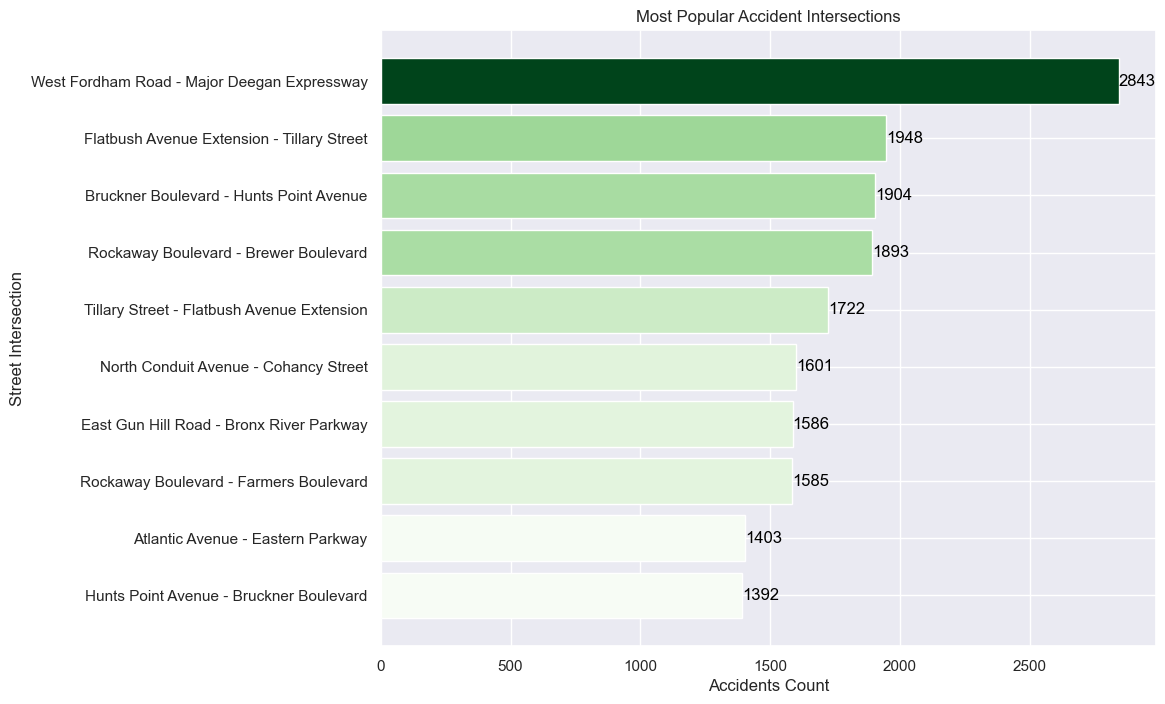

In [91]:
cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.figure(figsize=(10, 8))
plt.barh(
    top10.accident_intersection,
    top10.Count,
    color=cmap(normalize(top10.Count)), edgecolor='white'
)
for i, v in enumerate(top10.Count.tolist()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Street Intersection')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections')
plt.gca().invert_yaxis()
plt.show()

**Categorical Distributions**

10. Gender split for Accidents.
11. Which vehicles contribute the most to accidents?
12. Driver Licence jurisdictions and accidents.
13. Travel Direction and accidents.
14. Person Injury

In [92]:
obj_cols = df.select_dtypes('O').columns.tolist()
data = df[obj_cols]
data.head()

borough person_type person_sex person_injury  \
crash_datetime                                                        
2012-07-01 00:30:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:30:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:37:00  Manhattan    Occupant          U       Injured   
2012-07-01 00:37:00  Manhattan    Occupant          U       Injured   
2012-07-01 01:00:00      Bronx    Occupant          U       Injured   

                    state_registration                         vehicle_type  \
crash_datetime                                                                
2012-07-01 00:30:00                 Nj  Station Wagon/Sport Utility Vehicle   
2012-07-01 00:30:00                 Ny                                 Taxi   
2012-07-01 00:37:00                 Nj                    Passenger Vehicle   
2012-07-01 00:37:00                 Ny                                 Taxi   
2012-07-01 01:00:00                 Ny                    Passenger Vehicle   

                    travel_direction driver_sex driver_license_status  \
crash_datetime                                                          
2012-07-01 00:30:00          Unknown        NaN                   NaN   
2012-07-01 00:30:00          Unknown        NaN                   NaN   
2012-07-01 00:37:00          Unknown        NaN                   NaN   
2012-07-01 00:37:00          Unknown        NaN                   NaN   
2012-07-01 01:00:00          Unknown        NaN                   NaN   

                    driver_license_jurisdiction  ... vehicle_damage_3  \
crash_datetime                                   ...                    
2012-07-01 00:30:00                         NaN  ...              NaN   
2012-07-01 00:30:00                         NaN  ...              NaN   
2012-07-01 00:37:00                         NaN  ...              NaN   
2012-07-01 00:37:00                         NaN  ...              NaN   
2012-07-01 01:00:00                         NaN  ...              NaN   

                    public_property_damage           contributing_factor_1  \
crash_datetime                                                               
2012-07-01 00:30:00                    NaN  Driver Inattention/Distraction   
2012-07-01 00:30:00                    NaN                     Unspecified   
2012-07-01 00:37:00                    NaN                     Unspecified   
2012-07-01 00:37:00                    NaN                     Unspecified   
2012-07-01 01:00:00                    NaN             Physical Disability   

                    contributing_factor_2   on_street_name cross_street_name  \
crash_datetime                                                                 
2012-07-01 00:30:00                   NaN     Reade Street          Broadway   
2012-07-01 00:30:00                   NaN     Reade Street          Broadway   
2012-07-01 00:37:00                   NaN      Park Avenue    East 48 Street   
2012-07-01 00:37:00                   NaN      Park Avenue    East 48 Street   
2012-07-01 01:00:00                   NaN  East 165 Street    Findlay Avenue   

                    ejection emotional_status bodily_injury  \
crash_datetime                                                
2012-07-01 00:30:00      NaN              NaN           NaN   
2012-07-01 00:30:00      NaN              NaN           NaN   
2012-07-01 00:37:00      NaN              NaN           NaN   
2012-07-01 00:37:00      NaN              NaN           NaN   
2012-07-01 01:00:00      NaN              NaN           NaN   

                    position_in_vehicle  
crash_datetime                           
2012-07-01 00:30:00                 NaN  
2012-07-01 00:30:00                 NaN  
2012-07-01 00:37:00                 NaN  
2012-07-01 00:37:00                 NaN  
2012-07-01 01:00:00                 NaN  

[5 rows x 25 columns]

In [93]:
df.driver_sex.value_counts()

driver_sex
M    1659663
F     613643
U       5012
Name: count, dtype: int64

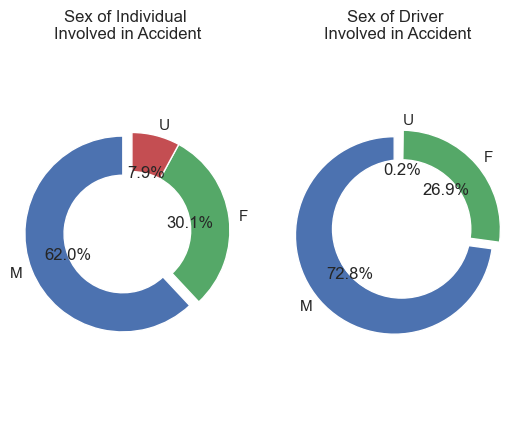

In [94]:
data2 = data.person_sex.value_counts()
labels = data2.index
counts = data2.values

fig, ax = plt.subplots(1, 2)
explode = (0.1, 0, 0)
ax[0].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[0].axis('equal')
ax[0].set_title("Sex of Individual \nInvolved in Accident")

data2 = data.person_sex.value_counts()
labels = data2.index
counts = data2.values

# Second Plot
data2 = data.driver_sex.value_counts()
labels = data2.index
counts = data2.values
explode = (0.1, 0, 0)
ax[1].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[1].axis('equal')
ax[1].set_title("Sex of Driver \nInvolved in Accident")
plt.show()


How distributed are accidents across Boroughs?

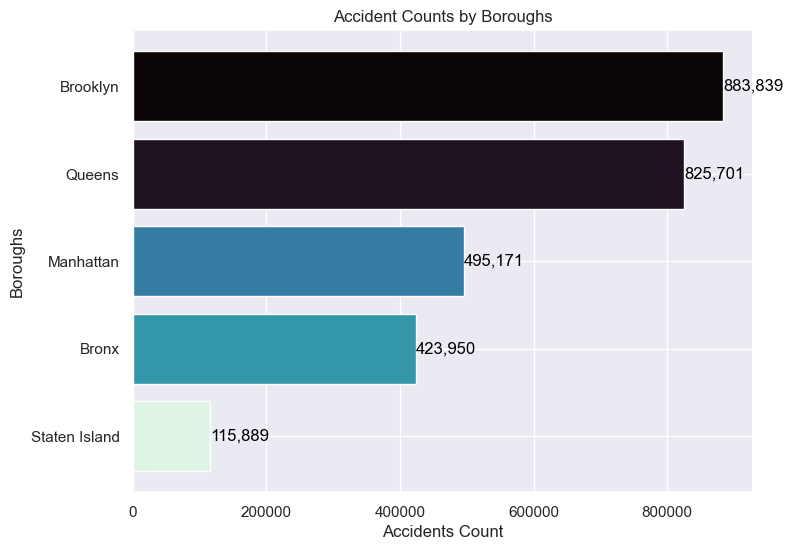

In [95]:
data2 = data.borough.value_counts()

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Boroughs')
plt.xlabel('Accidents Count')
plt.title('Accident Counts by Boroughs')
plt.gca().invert_yaxis()
plt.show()

Most recorded accidents affecct only the occupants of the accidented vehicle.

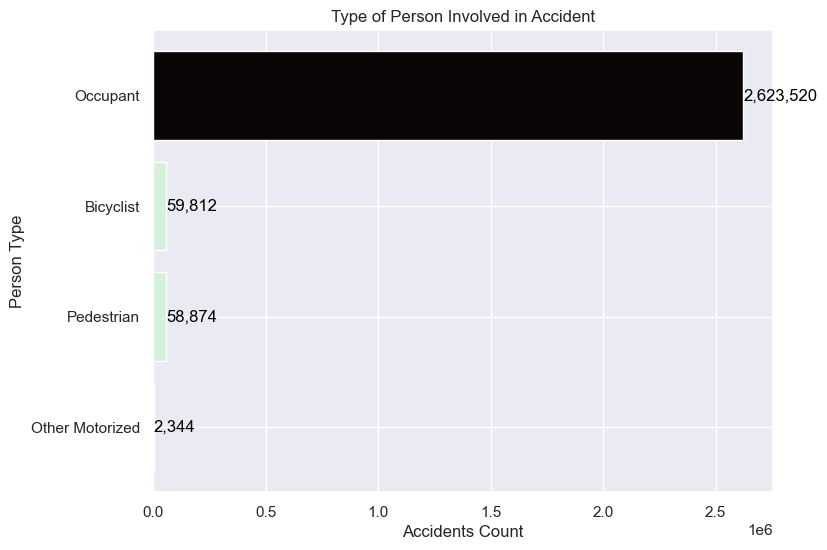

In [96]:
data2 = data.person_type.value_counts()

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Person Type')
plt.xlabel('Accidents Count')
plt.title('Type of Person Involved in Accident')
plt.gca().invert_yaxis()
plt.show()

Most victims have unspecified injuries and only 0.1% of accidents result in deaths. 

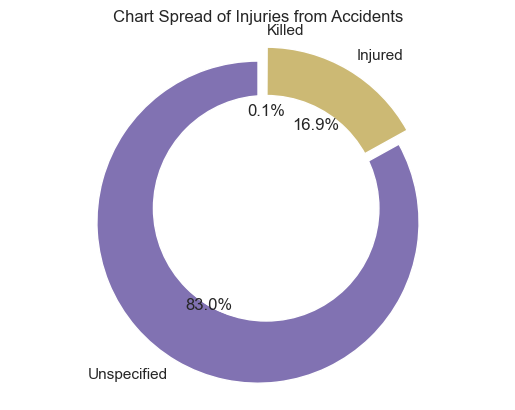

In [97]:
data2 = data.person_injury.value_counts()
labels = data2.index
counts = data2.values

fig, ax = plt.subplots()
explode = (0.1, 0, 0)
ax.pie(
    counts, labels=labels, colors=deep_colors[3:], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
ax.set_title("Chart Spread of Injuries from Accidents")
plt.show()

When we test for vehicles the registration of vehicles involved in accidents, mosst accidents invplve New York registered vehicles.

In [98]:
data2 = data.assign(
    state_registration=lambda x: x.state_registration.str.upper(),
    state_registration_bool=lambda x: x.state_registration.str.upper().apply(lambda i: 'In-State' if i=='NY' else 'Out-of-State'),
    driver_license_jurisdiction_bool=lambda x: x.driver_license_jurisdiction .str.upper().apply(lambda i: 'In-State' if i=='NY' else 'Unknown' if i is np.nan else 'Out-of-State')
)[['state_registration', 'state_registration_bool', 'driver_license_jurisdiction', 'driver_license_jurisdiction_bool']]

data2.head()

state_registration state_registration_bool  \
crash_datetime                                                   
2012-07-01 00:30:00                 NJ            Out-of-State   
2012-07-01 00:30:00                 NY                In-State   
2012-07-01 00:37:00                 NJ            Out-of-State   
2012-07-01 00:37:00                 NY                In-State   
2012-07-01 01:00:00                 NY                In-State   

                    driver_license_jurisdiction  \
crash_datetime                                    
2012-07-01 00:30:00                         NaN   
2012-07-01 00:30:00                         NaN   
2012-07-01 00:37:00                         NaN   
2012-07-01 00:37:00                         NaN   
2012-07-01 01:00:00                         NaN   

                    driver_license_jurisdiction_bool  
crash_datetime                                        
2012-07-01 00:30:00                          Unknown  
2012-07-01 00:30:00                          Unknown  
2012-07-01 00:37:00                          Unknown  
2012-07-01 00:37:00                          Unknown  
2012-07-01 01:00:00                          Unknown

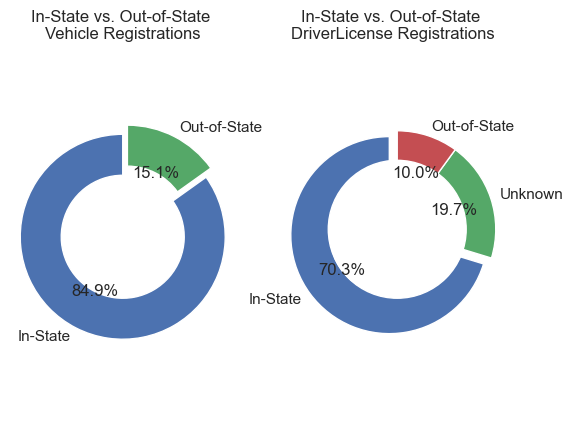

In [99]:
data3 = data2.state_registration_bool.value_counts()
labels = data3.index
counts = data3.values

fig, ax = plt.subplots(1, 2)
explode = (0.1, 0)
ax[0].pie(
    counts, labels=labels, colors=deep_colors[:2], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[0].axis('equal')
ax[0].set_title("In-State vs. Out-of-State \nVehicle Registrations")

# 2nd Plot
data3 = data2.driver_license_jurisdiction_bool.value_counts()
labels = data3.index
counts = data3.values

explode = (0.1, 0, 0)
ax[1].pie(
    counts, labels=labels, colors=deep_colors[:3], 
    autopct='%1.1f%%', startangle=90, 
    wedgeprops=dict(width=0.4), explode=explode
    )

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax[1].axis('equal')
ax[1].set_title("In-State vs. Out-of-State \nDriverLicense Registrations")

plt.show()

For vehicle types, the Sedan and the SUV are the cars most involved in accidents.

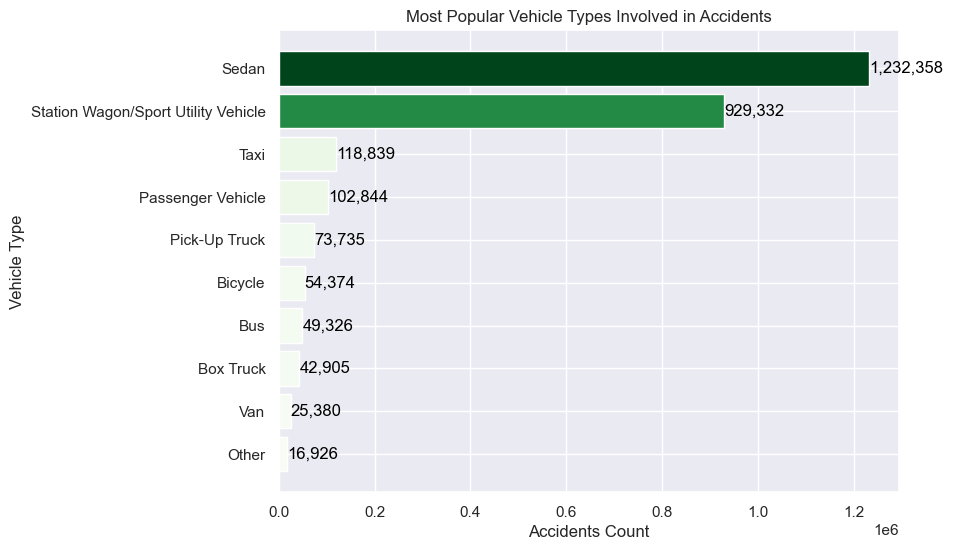

In [100]:
data2 = data.vehicle_type.value_counts(dropna=False).head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Vehicle Type')
plt.xlabel('Accidents Count')
plt.title('Most Popular Vehicle Types Involved in Accidents')
plt.gca().invert_yaxis()
plt.show()

Most accidents occur with Northbound drivers. However, the spread difference across travel directions is not very large.

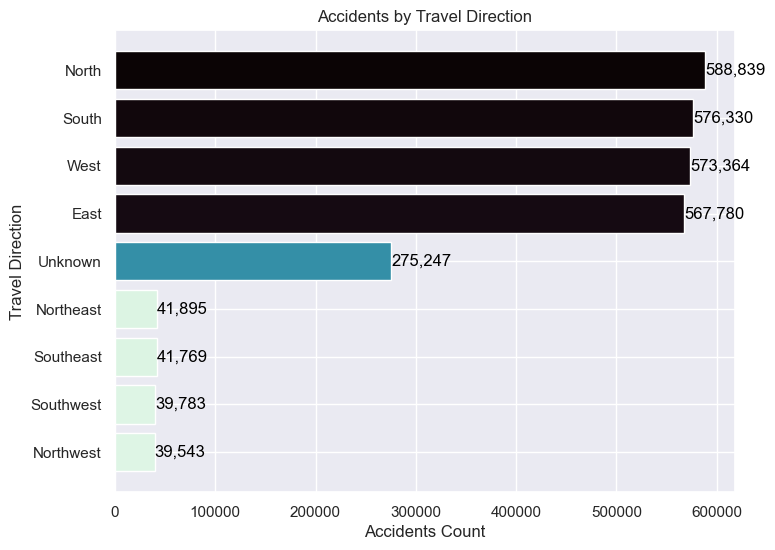

In [101]:
data2 = data.travel_direction.value_counts(dropna=False)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Travel Direction')
plt.xlabel('Accidents Count')
plt.title('Accidents by Travel Direction')
plt.gca().invert_yaxis()
plt.show()

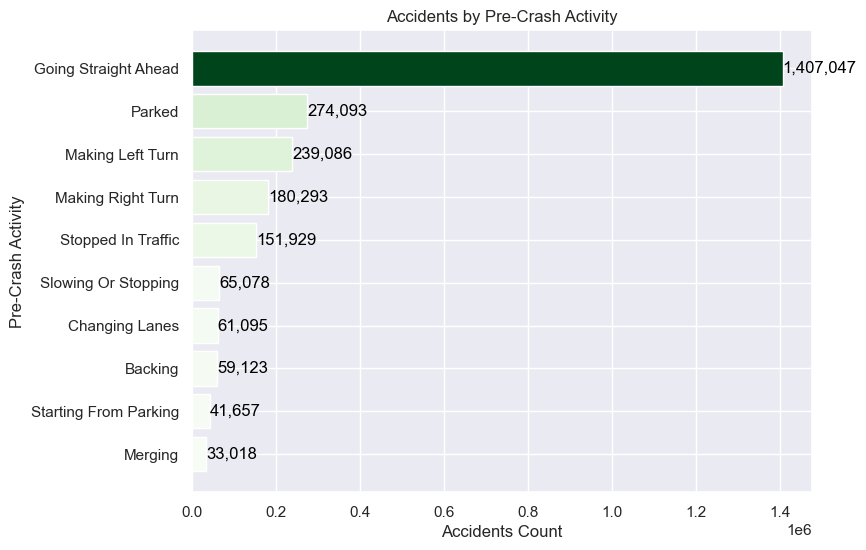

In [102]:
data2 = data.pre_crash.value_counts().head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Pre-Crash Activity')
plt.xlabel('Accidents Count')
plt.title('Accidents by Pre-Crash Activity')
plt.gca().invert_yaxis()
plt.show()

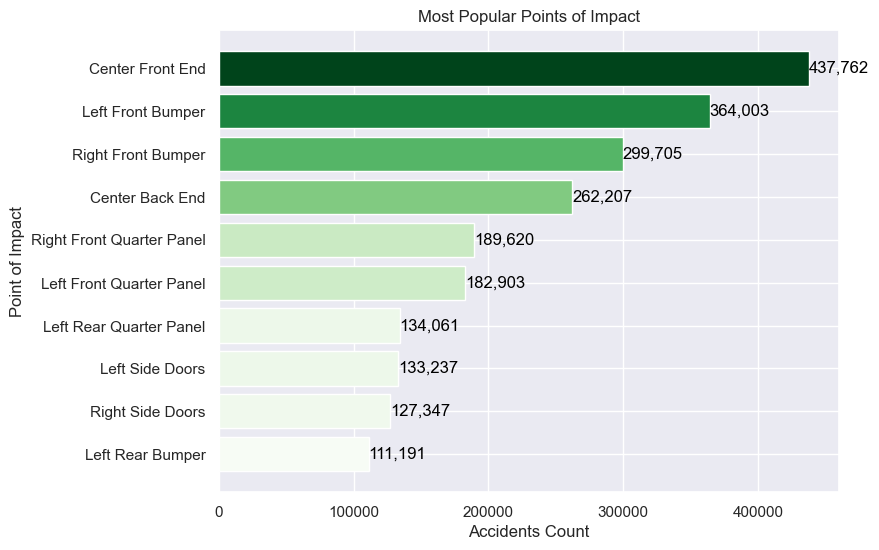

In [103]:
data2 = data.point_of_impact.value_counts().head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Point of Impact')
plt.xlabel('Accidents Count')
plt.title('Most Popular Points of Impact')
plt.gca().invert_yaxis()
plt.show()

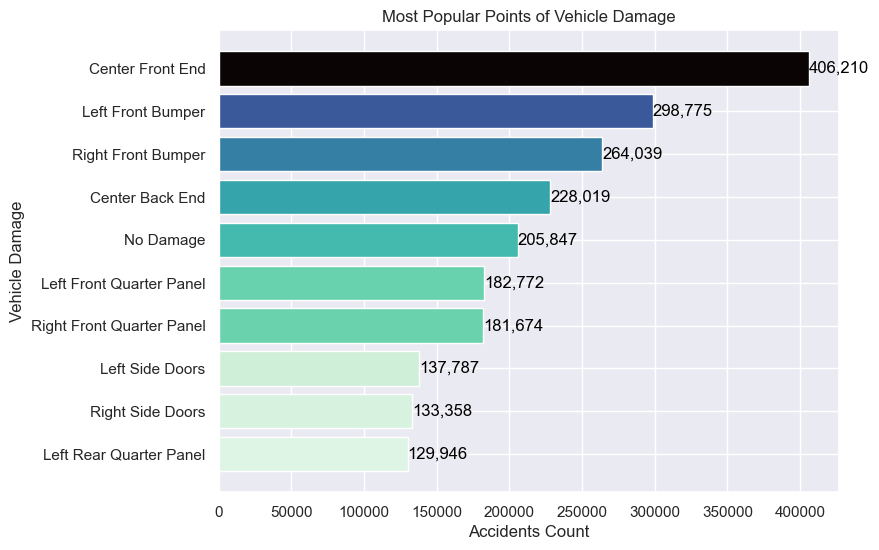

In [104]:
data2 = data.vehicle_damage.value_counts().head(10)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Vehicle Damage')
plt.xlabel('Accidents Count')
plt.title('Most Popular Points of Vehicle Damage')
plt.gca().invert_yaxis()
plt.show()

Most accidents do not result in damage to other vehicles and / or property. 

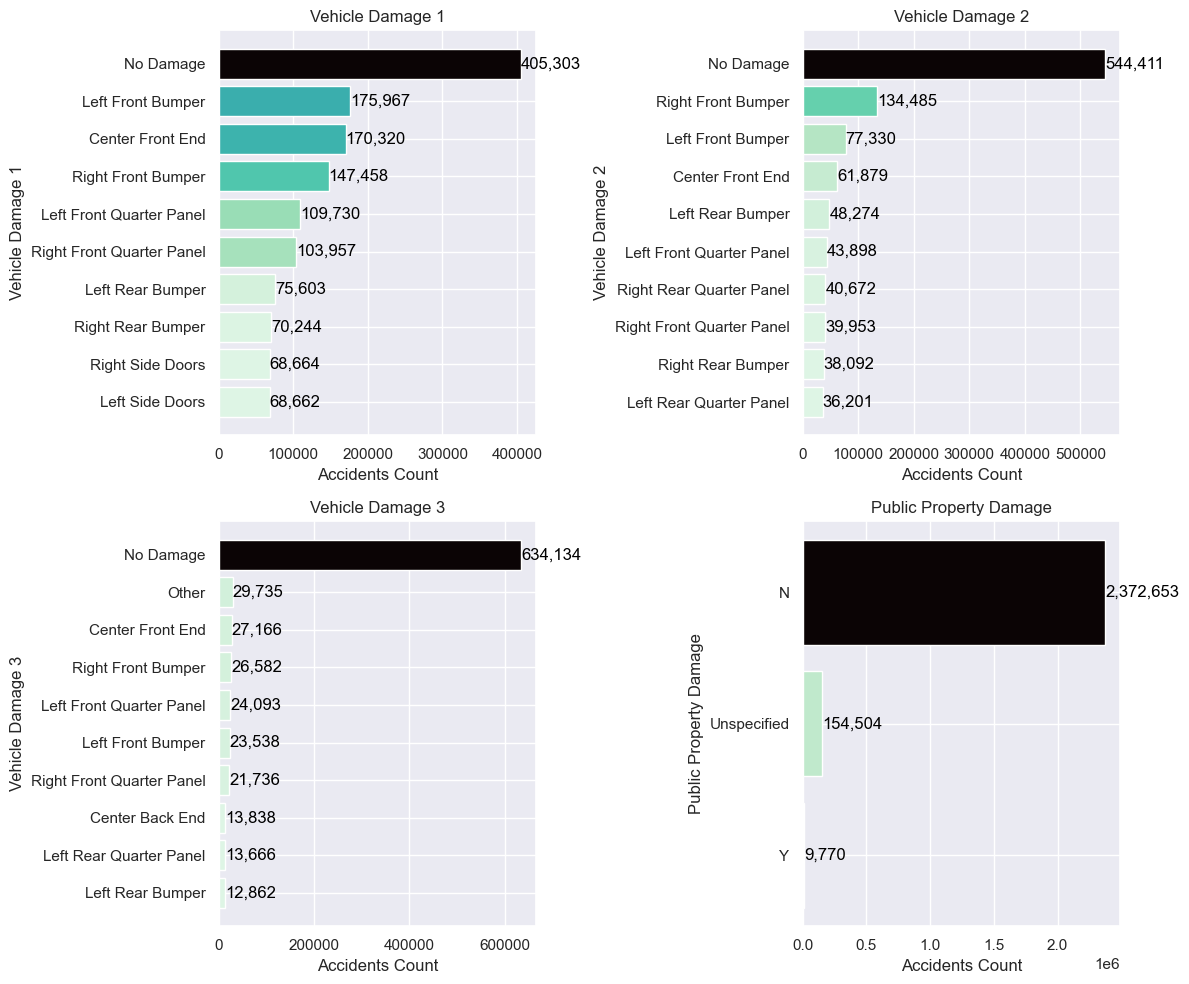

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
damage_cols = [
    'vehicle_damage_1', 'vehicle_damage_2', 
    'vehicle_damage_3', 'public_property_damage'
    ]

for col, ax in zip(damage_cols, axes.ravel()):
    data2 = data[col].value_counts().head(10)
    cmap = plt.get_cmap('mako_r')
    normalize = plt.Normalize(min(data2.values), max(data2.values))

    ax.barh(
        data2.index,
        data2.values,
        color=cmap(normalize(data2.values)), edgecolor='white'
    )
    ax.set_title(col.replace('_', ' ').title())
    ax.set_ylabel(col.replace('_', ' ').title())
    ax.set_xlabel('Accidents Count')
    ax.invert_yaxis()


    for i, v in enumerate(data2.values.tolist()):
        ax.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')
    
    sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sml.set_array([])

plt.tight_layout()
plt.show()

Unfortunately nearly all accidents do not have a specified contributing factor. For those that include specified factors, the most specified is Driver inattention or distraction. 

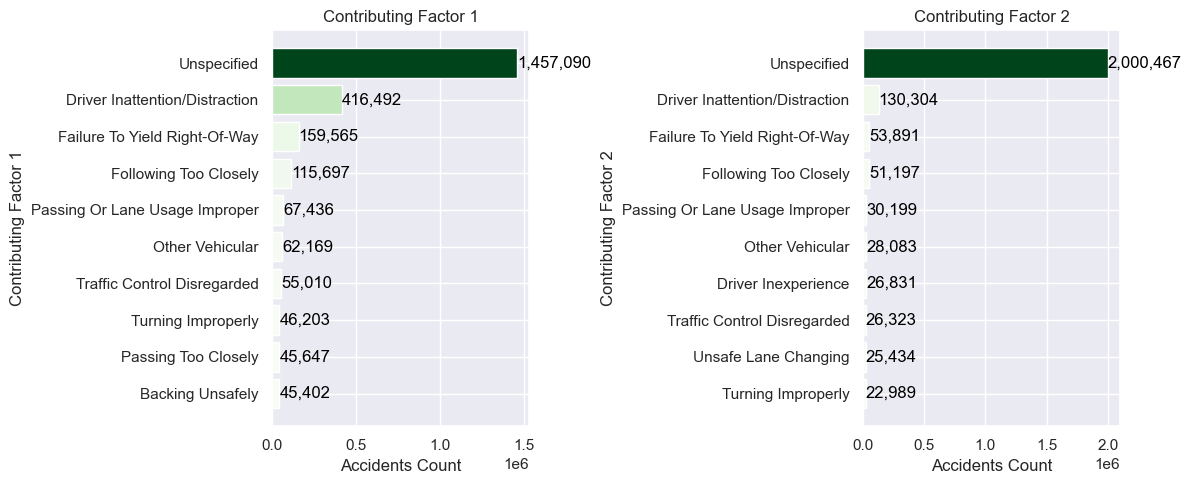

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
factor_cols = [
    'contributing_factor_1', 'contributing_factor_2'
    ]

for col, ax in zip(factor_cols, axes.ravel()):
    data2 = data[col].value_counts().head(10)
    cmap = plt.get_cmap('Greens')
    normalize = plt.Normalize(min(data2.values), max(data2.values))

    ax.barh(
        data2.index,
        data2.values,
        color=cmap(normalize(data2.values)), edgecolor='white'
    )
    ax.set_title(col.replace('_', ' ').title())
    ax.set_ylabel(col.replace('_', ' ').title())
    ax.set_xlabel('Accidents Count')
    ax.invert_yaxis()


    for i, v in enumerate(data2.values.tolist()):
        ax.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')
    
    sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sml.set_array([])

plt.tight_layout()
plt.show()

**Variable Relationships**

13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction


In [107]:
num_cols = df.select_dtypes('number').columns.tolist()
data = df[num_cols[1:]]
data.head()

zip_code   latitude  longitude  person_age  vehicle_year  \
crash_datetime                                                                  
2012-07-01 00:30:00     10007  40.714678 -74.005887          31           NaN   
2012-07-01 00:30:00     10007  40.714678 -74.005887          31           NaN   
2012-07-01 00:37:00     10017  40.755924 -73.974889          36           NaN   
2012-07-01 00:37:00     10017  40.755924 -73.974889          36           NaN   
2012-07-01 01:00:00     10456  40.828729 -73.914723          36           NaN   

                     vehicle_occupants  number_of_persons_injured  \
crash_datetime                                                      
2012-07-01 00:30:00                NaN                          1   
2012-07-01 00:30:00                NaN                          1   
2012-07-01 00:37:00                NaN                          1   
2012-07-01 00:37:00                NaN                          1   
2012-07-01 01:00:00                NaN                          1   

                     number_of_persons_killed  number_of_pedestrians_injured  \
crash_datetime                                                                 
2012-07-01 00:30:00                         0                              0   
2012-07-01 00:30:00                         0                              0   
2012-07-01 00:37:00                         0                              0   
2012-07-01 00:37:00                         0                              0   
2012-07-01 01:00:00                         0                              0   

                     number_of_pedestrians_killed  number_of_cyclist_injured  \
crash_datetime                                                                 
2012-07-01 00:30:00                             0                          0   
2012-07-01 00:30:00                             0                          0   
2012-07-01 00:37:00                             0                          0   
2012-07-01 00:37:00                             0                          0   
2012-07-01 01:00:00                             0                          0   

                     number_of_cyclist_killed  number_of_motorist_injured  \
crash_datetime                                                              
2012-07-01 00:30:00                         0                           1   
2012-07-01 00:30:00                         0                           1   
2012-07-01 00:37:00                         0                           1   
2012-07-01 00:37:00                         0                           1   
2012-07-01 01:00:00                         0                           1   

                     number_of_motorist_killed  
crash_datetime                                  
2012-07-01 00:30:00                          0  
2012-07-01 00:30:00                          0  
2012-07-01 00:37:00                          0  
2012-07-01 00:37:00                          0  
2012-07-01 01:00:00                          0

Most popular zip codes for accidents:

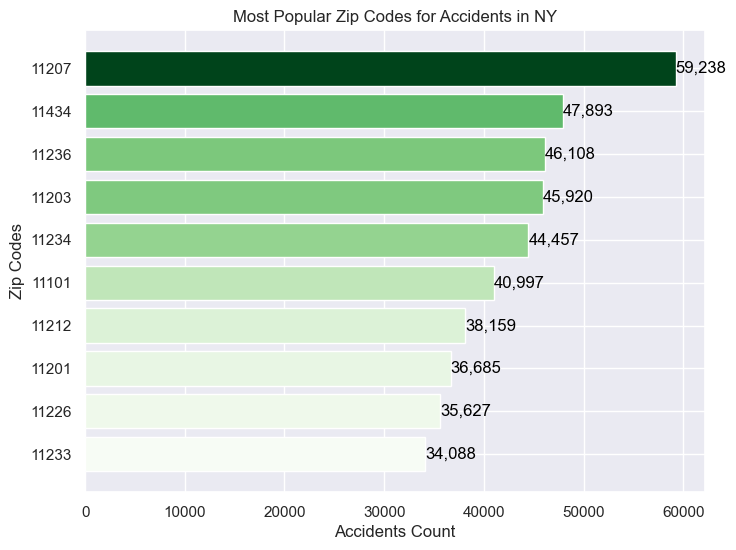

In [108]:
data2 = data.zip_code.astype(str).value_counts().head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Zip Codes')
plt.xlabel('Accidents Count')
plt.title('Most Popular Zip Codes for Accidents in NY')
plt.gca().invert_yaxis()
plt.show()

Most of the popular zip codes for accidents are in Brooklyn:

In [109]:
top10 = data.zip_code.value_counts().head(10)
for i in top10.index:
    print(i, ':', df.loc[df.zip_code==i, 'borough'].iloc[0])


11207 : Brooklyn
11434 : Queens
11236 : Brooklyn
11203 : Brooklyn
11234 : Brooklyn
11101 : Queens
11212 : Brooklyn
11201 : Brooklyn
11226 : Brooklyn
11233 : Brooklyn


Relationship between Vehicle Occupants and Number of Persons Injured

<Figure size 800x600 with 0 Axes>

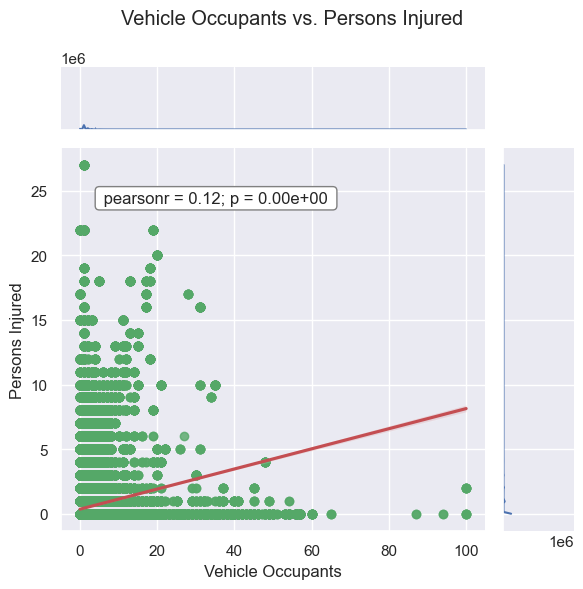

In [110]:
data = df[['vehicle_occupants', 'number_of_persons_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_persons_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_persons_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=25,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Persons Injured')
plt.suptitle('Vehicle Occupants vs. Persons Injured')
plt.tight_layout()
plt.show()

Relationship between Vehicle Occupants and Number of Persons Killed

<Figure size 800x600 with 0 Axes>

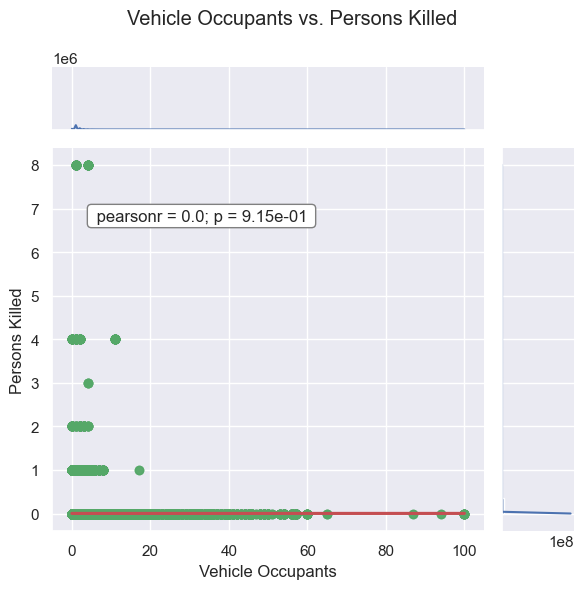

In [111]:
data = df[['vehicle_occupants', 'number_of_persons_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_persons_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_persons_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=7,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Persons Killed')
plt.suptitle('Vehicle Occupants vs. Persons Killed')
plt.tight_layout()
plt.show()

Relationship between Vehicle Occupants and Number of Pedestrians Injured

<Figure size 800x600 with 0 Axes>

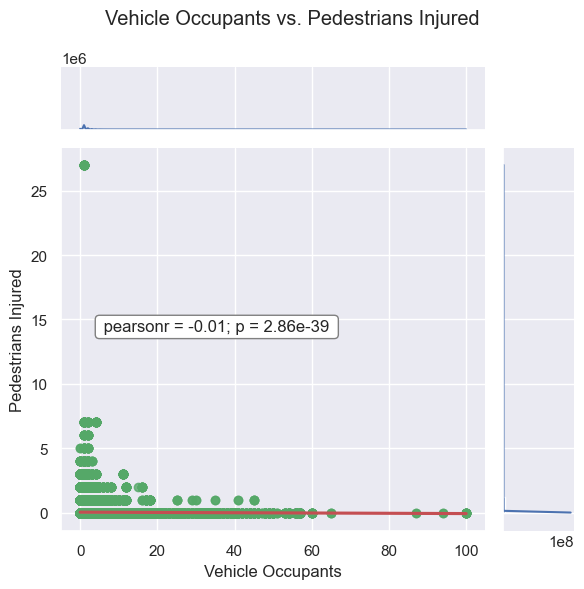

In [112]:
data = df[['vehicle_occupants', 'number_of_pedestrians_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_pedestrians_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_pedestrians_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=15,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Pedestrians Injured')
plt.suptitle('Vehicle Occupants vs. Pedestrians Injured')
plt.tight_layout()
plt.show()

Relationship between Vehicle Occupants and Number of Pedestrians Killed

<Figure size 800x600 with 0 Axes>

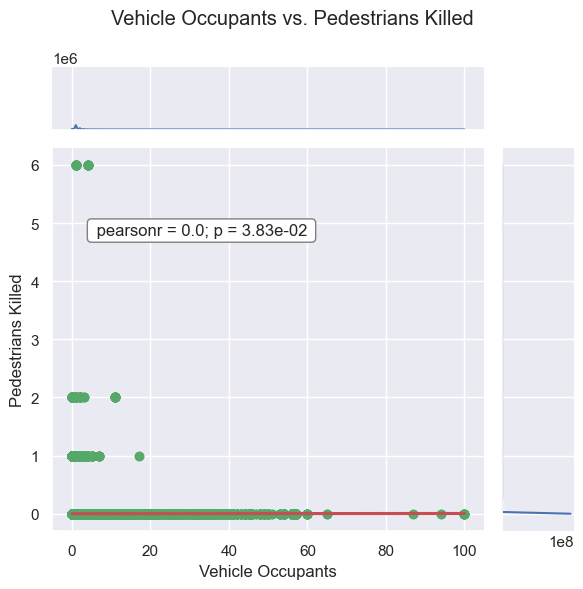

In [113]:
data = df[['vehicle_occupants', 'number_of_pedestrians_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_pedestrians_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_pedestrians_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Pedestrians Killed')
plt.suptitle('Vehicle Occupants vs. Pedestrians Killed')
plt.tight_layout()
plt.show()

Relationship between Vehicle Occupants and Number of Cyclists Injured

<Figure size 800x600 with 0 Axes>

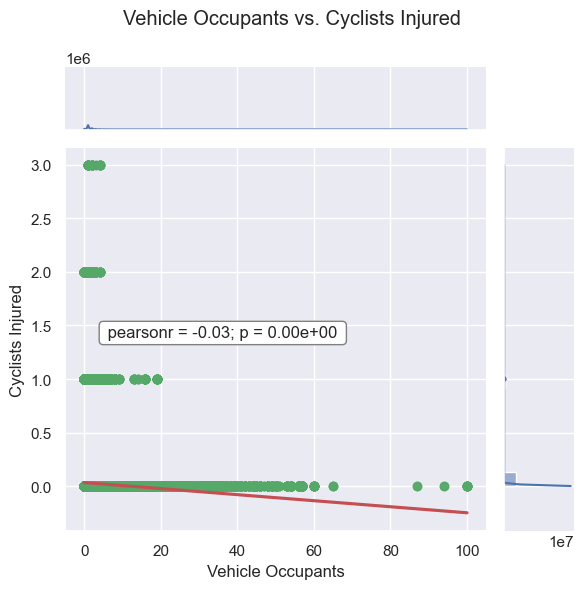

In [114]:
data = df[['vehicle_occupants', 'number_of_cyclist_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_cyclist_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_cyclist_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=1.5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Cyclists Injured')
plt.suptitle('Vehicle Occupants vs. Cyclists Injured')
plt.tight_layout()
plt.show()

Relationship between Vehicle Occupants and Number of Cyclists Killed

<Figure size 800x600 with 0 Axes>

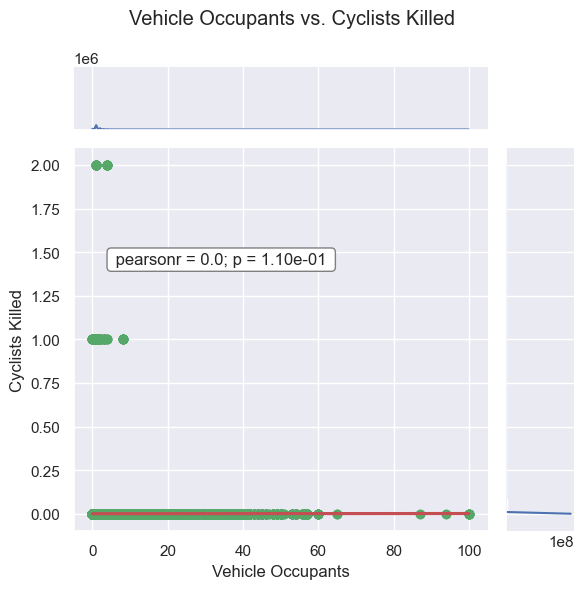

In [115]:
data = df[['vehicle_occupants', 'number_of_cyclist_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_occupants,
    data.number_of_cyclist_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_occupants',
    y='number_of_cyclist_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=5, y=1.5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Occupants')
plt.ylabel('Cyclists Killed')
plt.suptitle('Vehicle Occupants vs. Cyclists Killed')
plt.tight_layout()
plt.show()

Relationship between Vehicle Year and Number of Persons Injured

<Figure size 800x600 with 0 Axes>

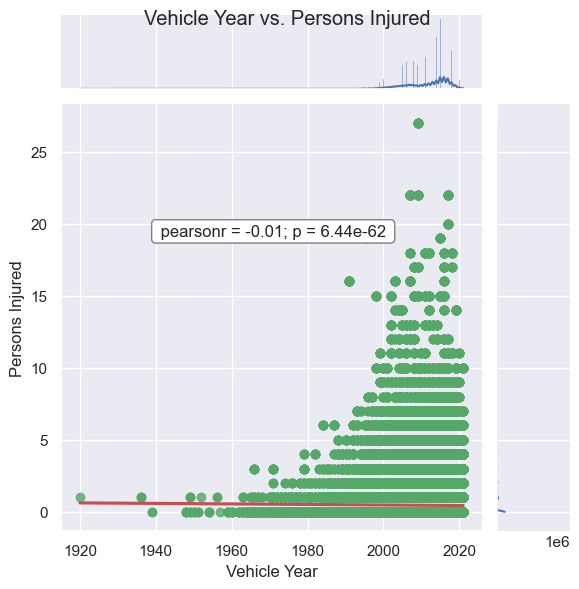

In [116]:
data = df[['vehicle_year', 'number_of_persons_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_persons_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_persons_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=20,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Persons Injured')
plt.suptitle('Vehicle Year vs. Persons Injured')
plt.show()

Relationship between Vehicle Year and Number of Persons Killed

<Figure size 800x600 with 0 Axes>

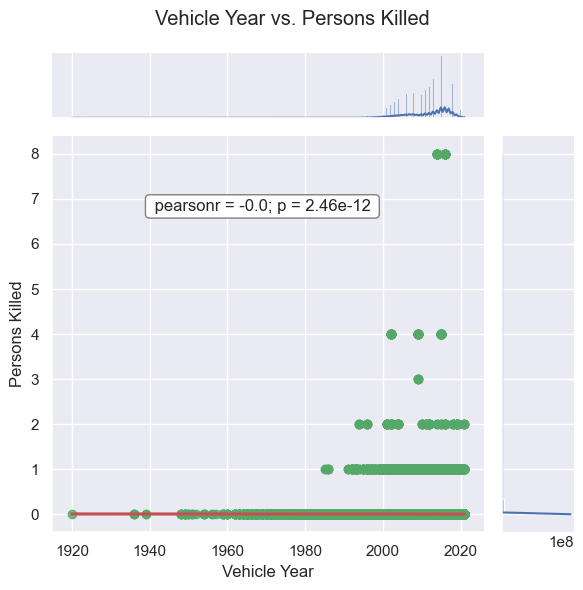

In [117]:
data = df[['vehicle_year', 'number_of_persons_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_persons_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_persons_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=7,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Persons Killed')
plt.suptitle('Vehicle Year vs. Persons Killed')
plt.tight_layout()
plt.show()

Relationship between Vehicle Year and Number of Pedestrians Injured

<Figure size 800x600 with 0 Axes>

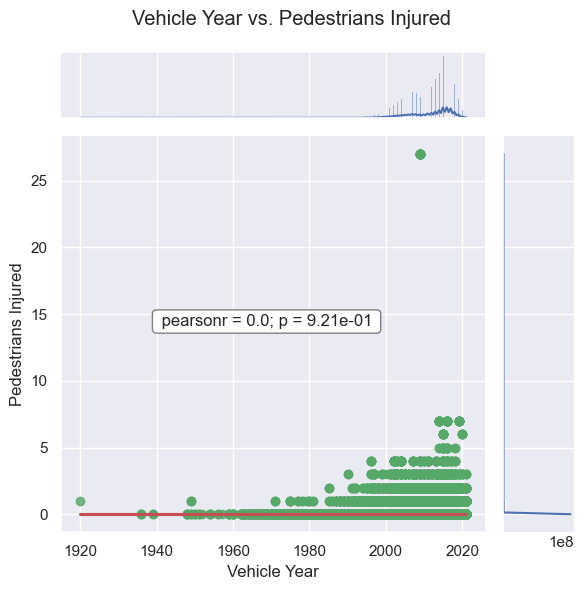

In [118]:
data = df[['vehicle_year', 'number_of_pedestrians_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_pedestrians_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_pedestrians_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=15,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Pedestrians Injured')
plt.suptitle('Vehicle Year vs. Pedestrians Injured')
plt.tight_layout()
plt.show()

Relationship between Vehicle Year and Number of Pedestrians Killed

<Figure size 800x600 with 0 Axes>

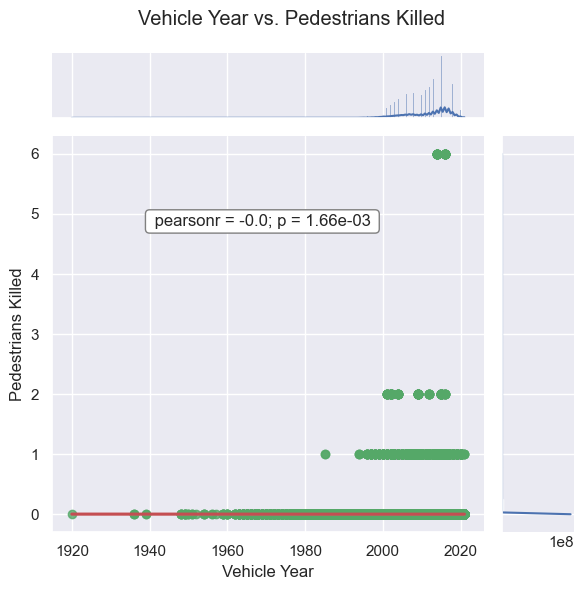

In [119]:
data = df[['vehicle_year', 'number_of_pedestrians_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_pedestrians_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_pedestrians_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Pedestrians Killed')
plt.suptitle('Vehicle Year vs. Pedestrians Killed')
plt.tight_layout()
plt.show()

Relationship between Vehicle Year and Number of Cyclists Injured

<Figure size 800x600 with 0 Axes>

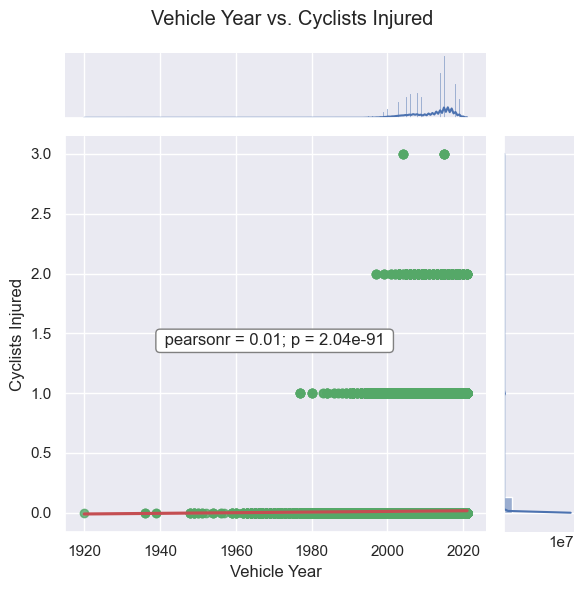

In [120]:
data = df[['vehicle_year', 'number_of_cyclist_injured', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_cyclist_injured
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_cyclist_injured', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=1.5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Cyclists Injured')
plt.suptitle('Vehicle Year vs. Cyclists Injured')
plt.tight_layout()
plt.show()

Relationship between Vehicle Year and Number of Cyclists Killed

<Figure size 800x600 with 0 Axes>

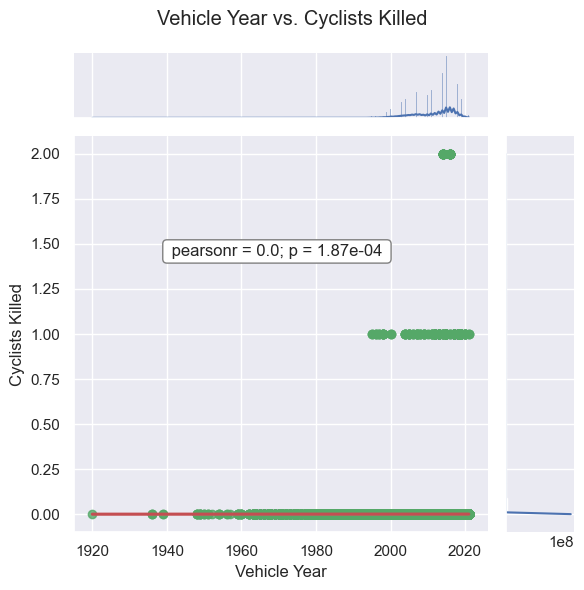

In [121]:
data = df[['vehicle_year', 'number_of_cyclist_killed', ]].dropna()

pearson, p = stats.pearsonr(
    data.vehicle_year,
    data.number_of_cyclist_killed
)
pearson = round(pearson, 2)
p = '{:.2e}'.format(p)

plt.figure(figsize=(8, 6))
sns.jointplot(
    x='vehicle_year',
    y='number_of_cyclist_killed', 
    data=data,
    kind="reg",
    joint_kws={'color':deep_colors[1]},
    line_kws={'color':deep_colors[2]}
).ax_joint.text(
    s=f' pearsonr = {pearson}; p = {p} ',
    ha='left', va='top', x=1940, y=1.5,
    bbox={
        'boxstyle':'round','pad':0.25,
        'facecolor':'white','edgecolor':'gray'
    }
)

plt.xlabel('Vehicle Year')
plt.ylabel('Cyclists Killed')
plt.suptitle('Vehicle Year vs. Cyclists Killed')
plt.tight_layout()
plt.show()

**Supplemental Analysis**

16. Understanding these features - Ejection, Emotional status, Bodily injury and

 Position in vehicle.

In [122]:
supp_cols = [
    'ejection', 'emotional_status', 
    'bodily_injury', 'position_in_vehicle'
]

df[supp_cols].dropna().head()

ejection emotional_status   bodily_injury  \
crash_datetime                                                      
2012-07-27 20:53:00  Not Ejected   Does Not Apply  Does Not Apply   
2012-07-27 20:53:00  Not Ejected   Does Not Apply  Does Not Apply   
2012-07-27 20:53:00  Not Ejected   Does Not Apply  Does Not Apply   
2012-07-27 20:53:00  Not Ejected   Does Not Apply  Does Not Apply   
2012-07-27 20:53:00  Not Ejected   Does Not Apply  Does Not Apply   

                                                   position_in_vehicle  
crash_datetime                                                          
2012-07-27 20:53:00                                             Driver  
2012-07-27 20:53:00  Front Passenger, If Two Or More Persons, Inclu...  
2012-07-27 20:53:00                                             Driver  
2012-07-27 20:53:00                                             Driver  
2012-07-27 20:53:00  Front Passenger, If Two Or More Persons, Inclu...

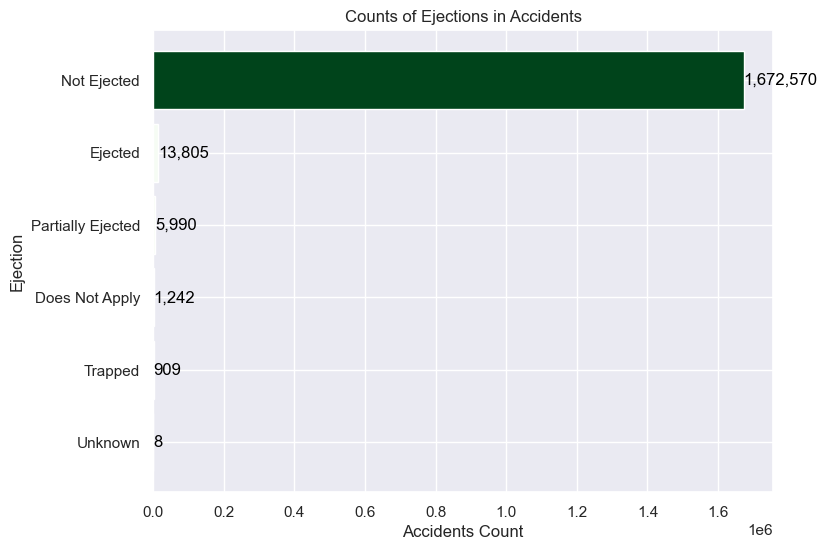

In [123]:
data2 = df.ejection.value_counts().head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Ejection')
plt.xlabel('Accidents Count')
plt.title('Counts of Ejections in Accidents')
plt.gca().invert_yaxis()
plt.show()

What's the likelihood of injury and death where occupant is ejected or trapped vs otherwise?

In [124]:
# Calculate the likelihood of injury & death given 'Ejected'
data2 = df.loc[df.ejection=='Ejected']
total_ejected = len(data2)
injury_given_ejected = (data2.number_of_persons_injured > 0).sum() / total_ejected
death_given_ejected = (data2.number_of_persons_killed > 0).sum() / total_ejected
print(f'Likelihood of injury given "Ejected": {injury_given_ejected:.2%}')
print(f'Likelihood of death given "Ejected": {death_given_ejected:.2%}')

# Calculate the likelihood of injury & death given 'Not Ejected'
data2 = df.loc[df.ejection=='Not Ejected']
total_not_ejected = len(data2)
injury_given_not_ejected = (data2.number_of_persons_injured > 0).sum() / total_not_ejected
death_given_not_ejected = (data2.number_of_persons_killed > 0).sum() / total_not_ejected
print(f'\nLikelihood of injury given "Not Ejected": {injury_given_not_ejected:.2%}')
print(f'Likelihood of death given "Not Ejected": {death_given_not_ejected:.2%}')

# Calculate the likelihood of injury & death given 'Partially Ejected'
data2 = df.loc[df.ejection=='Partially Ejected']
total_part_ejected = len(data2)
injury_given_part_ejected = (data2.number_of_persons_injured > 0).sum() / total_part_ejected
death_given_part_ejected = (data2.number_of_persons_killed > 0).sum() / total_part_ejected
print(f'\nLikelihood of injury given "Partially Ejected": {injury_given_part_ejected:.2%}')
print(f'Likelihood of death given "Partially Ejected": {death_given_part_ejected:.2%}')

# Calculate the likelihood of injury & death given 'Trapped'
data2 = df.loc[df.ejection=='Trapped']
total_trapped = len(data2)
injury_given_trapped = (data2.number_of_persons_injured > 0).sum() / total_trapped
death_given_trapped = (data2.number_of_persons_killed > 0).sum() / total_trapped
print(f'\nLikelihood of injury given "Trapped": {injury_given_trapped:.2%}')
print(f'Likelihood of death given "Trapped": {death_given_trapped:.2%}')


Likelihood of injury given "Ejected": 89.05%
Likelihood of death given "Ejected": 2.48%

Likelihood of injury given "Not Ejected": 28.09%
Likelihood of death given "Not Ejected": 0.14%

Likelihood of injury given "Partially Ejected": 59.97%
Likelihood of death given "Partially Ejected": 0.28%

Likelihood of injury given "Trapped": 67.22%
Likelihood of death given "Trapped": 5.39%


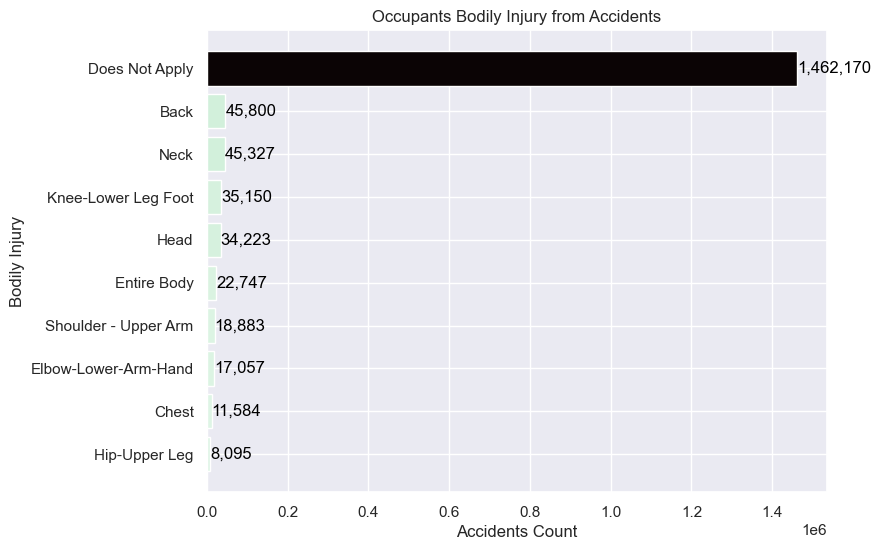

In [125]:
data2 = df.bodily_injury.value_counts().head(10)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Bodily Injury')
plt.xlabel('Accidents Count')
plt.title('Occupants Bodily Injury from Accidents')
plt.gca().invert_yaxis()
plt.show()

What is the likelihood of death where injury is to the back, neck, head or chest?

In [126]:
data2 = df.loc[df.bodily_injury=='Back']

total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'Likelihood of Death given "Back Injury": {death:.2%}')

data2 = df.loc[df.bodily_injury=='Neck']
total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of Death given "Neck Injury": {death:.2%}')

data2 = df.loc[df.bodily_injury=='Head']
total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of Death given "Head Injury": {death:.2%}')

data2 = df.loc[df.bodily_injury=='Chest']
total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of Death given "Chest Injury": {death:.2%}')

data2 = df.loc[df.bodily_injury=='Entire Body']
total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of Death given "Entire Body Injury": {death:.2%}')

data2 = df.loc[df.bodily_injury=='Knee-Lower Leg Foot']
total = len(data2)
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of Death given "Knee/Foot Injury": {death:.2%}')

Likelihood of Death given "Back Injury": 0.19%

Likelihood of Death given "Neck Injury": 0.37%

Likelihood of Death given "Head Injury": 2.27%

Likelihood of Death given "Chest Injury": 0.91%

Likelihood of Death given "Entire Body Injury": 1.83%

Likelihood of Death given "Knee/Foot Injury": 0.40%


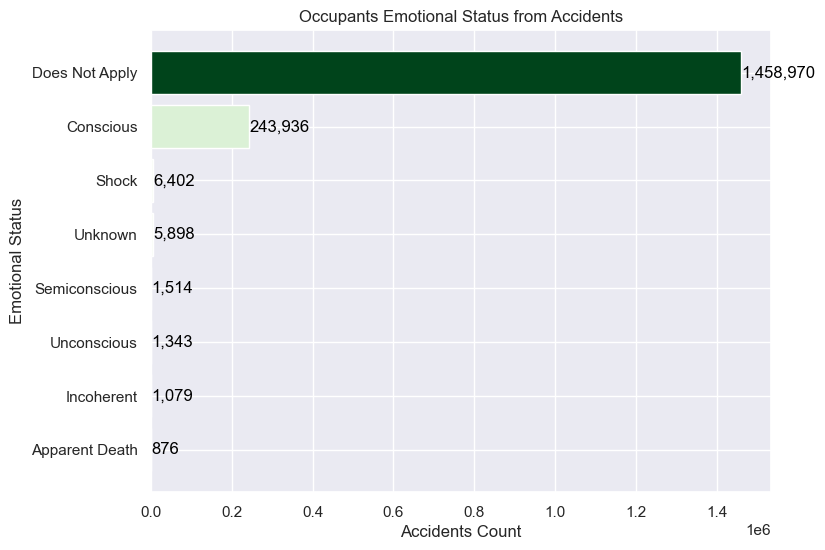

In [127]:
data2 = df.emotional_status.value_counts().head(10)

cmap = plt.get_cmap('Greens')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Emotional Status')
plt.xlabel('Accidents Count')
plt.title('Occupants Emotional Status from Accidents')
plt.gca().invert_yaxis()
plt.show()

In [128]:
# Calculate the likelihood of injury & death given 'Conscious'
data2 = df.loc[df.emotional_status=='Conscious']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'Likelihood of injury given "Conscious": {injury:.2%}')
print(f'Likelihood of death given "Conscious": {death:.2%}')

# Calculate the likelihood of injury & death given 'Shock'
data2 = df.loc[df.emotional_status=='Shock']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Shock": {injury:.2%}')
print(f'Likelihood of death given "Shock": {death:.2%}')

# Calculate the likelihood of injury & death given 'Semiconscious'
data2 = df.loc[df.emotional_status=='Semiconscious']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Semiconscious": {injury:.2%}')
print(f'Likelihood of death given "Semiconscious": {death:.2%}')

# Calculate the likelihood of injury & death given 'Unconscious'
data2 = df.loc[df.emotional_status=='Unconscious']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Unconscious": {injury:.2%}')
print(f'Likelihood of death given "Unconscious": {death:.2%}')

# Calculate the likelihood of injury & death given 'Incoherent'
data2 = df.loc[df.emotional_status=='Incoherent']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Incoherent": {injury:.2%}')
print(f'Likelihood of death given "Incoherent": {death:.2%}')

# Calculate the likelihood of injury & death given 'Apparent Death'
data2 = df.loc[df.emotional_status=='Apparent Death']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Apparent Death": {injury:.2%}')
print(f'Likelihood of death given "Apparent Death": {death:.2%}')


Likelihood of injury given "Conscious": 98.77%
Likelihood of death given "Conscious": 0.37%

Likelihood of injury given "Shock": 99.70%
Likelihood of death given "Shock": 0.20%

Likelihood of injury given "Semiconscious": 98.08%
Likelihood of death given "Semiconscious": 3.30%

Likelihood of injury given "Unconscious": 86.82%
Likelihood of death given "Unconscious": 21.89%

Likelihood of injury given "Incoherent": 98.52%
Likelihood of death given "Incoherent": 1.11%

Likelihood of injury given "Apparent Death": 37.56%
Likelihood of death given "Apparent Death": 80.71%


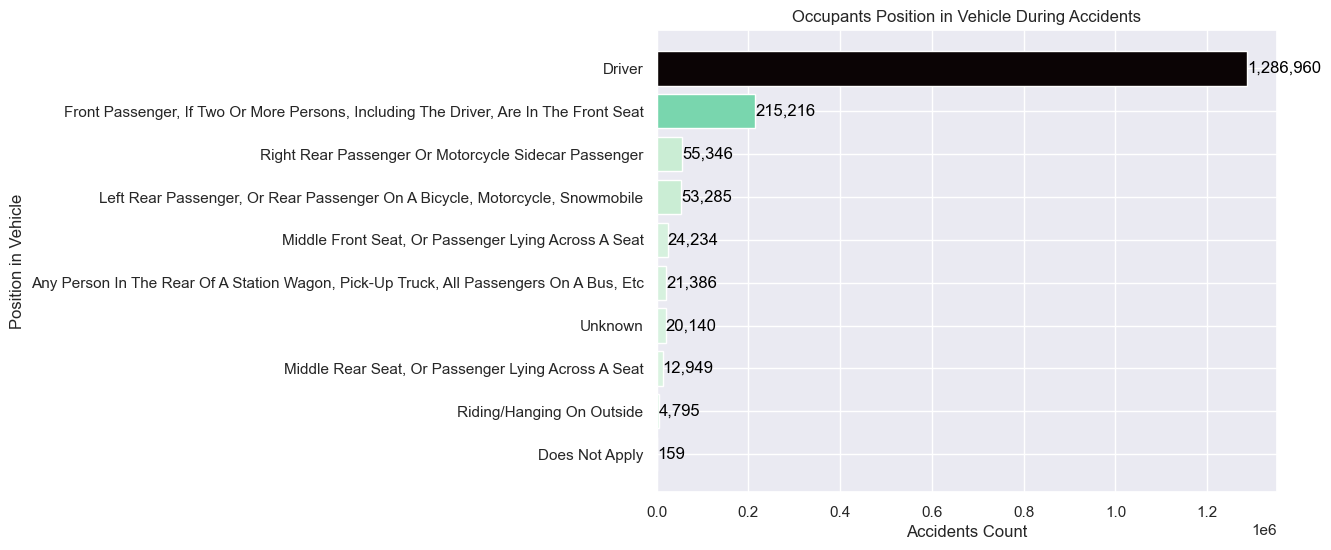

In [129]:
data2 = df.position_in_vehicle.value_counts().head(10)

cmap = plt.get_cmap('mako_r')
normalize = plt.Normalize(min(data2.values), max(data2.values))

plt.figure(figsize=(8, 6))
plt.barh(
    data2.index,
    data2.values,
    color=cmap(normalize(data2.values)), edgecolor='white'
)
for i, v in enumerate(data2.values.tolist()):
    plt.text(v + 0.5, i, str(f'{v:,.0f}'), color='black', va='center')


sml = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sml.set_array([])

plt.ylabel('Position in Vehicle')
plt.xlabel('Accidents Count')
plt.title('Occupants Position in Vehicle During Accidents')
plt.gca().invert_yaxis()
plt.show()

What is the likelihood of injury given occupant's position in the vehicle?

In [130]:
# Calculate the likelihood of injury & death given 'Driver'
data2 = df.loc[df.position_in_vehicle=='Driver']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'Likelihood of injury given "Driver": {injury:.2%}')
print(f'Likelihood of death given "Driver": {death:.2%}')

# Calculate the likelihood of injury & death given 'Front'
data2 = df.loc[df.position_in_vehicle=='Front Passenger, If Two Or More Persons, Including The Driver, Are In The Front Seat']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Front Passenger": {injury:.2%}')
print(f'Likelihood of death given "Front Passenger": {death:.2%}')

# Calculate the likelihood of injury & death given 'Right Rear'
data2 = df.loc[df.position_in_vehicle=='Right Rear Passenger Or Motorcycle Sidecar Passenger']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Right Rear/Motorcycle Sidecar Passenger": {injury:.2%}')
print(f'Likelihood of death given "Right Rear/Motorcycle Sidecar Passenger": {death:.2%}')

# Calculate the likelihood of injury & death given 'Left Rear'
data2 = df.loc[df.position_in_vehicle=='Left Rear Passenger, Or Rear Passenger On A Bicycle, Motorcycle, Snowmobile']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Left Rear/Bicycle/Motorcycle/Snowmobile Passenger": {injury:.2%}')
print(f'Likelihood of death given "Left Rear/Bicycle/Motorcycle/Snowmobile Passenger": {death:.2%}')

# Calculate the likelihood of injury & death given 'Middle Front Seat'
data2 = df.loc[df.position_in_vehicle=='Middle Front Seat, Or Passenger Lying Across A Seat']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Middle Front Seat/Passenger Lying Across A Seat": {injury:.2%}')
print(f'Likelihood of death given "Middle Front Seat/Passenger Lying Across A Seat": {death:.2%}')

# Calculate the likelihood of injury & death given 'Rear Station Wagon, Truck, Bus'
data2 = df.loc[df.position_in_vehicle=='Any Person In The Rear Of A Station Wagon, Pick-Up Truck, All Passengers On A Bus, Etc']
total = len(data2)
injury = (data2.number_of_persons_injured > 0).sum() / total
death = (data2.number_of_persons_killed > 0).sum() / total
print(f'\nLikelihood of injury given "Rear Station Wagon/Pick-Up Truck/Bus": {injury:.2%}')
print(f'Likelihood of death given "Rear Station Wagon/Pick-Up Truck/Bus": {death:.2%}')


Likelihood of injury given "Driver": 26.46%
Likelihood of death given "Driver": 0.14%

Likelihood of injury given "Front Passenger": 32.65%
Likelihood of death given "Front Passenger": 0.20%

Likelihood of injury given "Right Rear/Motorcycle Sidecar Passenger": 44.43%
Likelihood of death given "Right Rear/Motorcycle Sidecar Passenger": 0.21%

Likelihood of injury given "Left Rear/Bicycle/Motorcycle/Snowmobile Passenger": 43.01%
Likelihood of death given "Left Rear/Bicycle/Motorcycle/Snowmobile Passenger": 0.20%

Likelihood of injury given "Middle Front Seat/Passenger Lying Across A Seat": 29.59%
Likelihood of death given "Middle Front Seat/Passenger Lying Across A Seat": 0.02%

Likelihood of injury given "Rear Station Wagon/Pick-Up Truck/Bus": 31.55%
Likelihood of death given "Rear Station Wagon/Pick-Up Truck/Bus": 0.70%


### Statistical Analysis

Which features are likely to affect the possiblity of death or injury resulting from an accident?

In [131]:
data = df.assign(
    year=lambda x: x.index.year, 
    hour=lambda x: x.index.hour
    )
data.columns

Index(['collision_id', 'borough', 'zip_code', 'latitude', 'longitude',
       'person_type', 'person_sex', 'person_injury', 'person_age',
       'state_registration', 'vehicle_type', 'vehicle_year',
       'travel_direction', 'vehicle_occupants', 'driver_sex',
       'driver_license_status', 'driver_license_jurisdiction', 'pre_crash',
       'point_of_impact', 'vehicle_damage', 'vehicle_damage_1',
       'vehicle_damage_2', 'vehicle_damage_3', 'public_property_damage',
       'contributing_factor_1', 'contributing_factor_2', 'on_street_name',
       'cross_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'ejection', 'emotional_status',
       'bodily_injury', 'position_in_vehicle', 'year', 'hour'],
      dtype='object')

* How much variance in number of persons injured can be explained by year of accident?

T-test:

In [132]:
t_stat, p_value = stats.ttest_ind(data.year, data.number_of_persons_injured)
print(f'T-stat: {t_stat:,.2f}')
print(f'P-value: {p_value:,.4f}')

T-stat: 1,541,581.97
P-value: 0.0000


Using t-test, we find that there is a significant difference between the means of the accident year variable and the number of injursed persons variable. This difference is also statistically significant implying that the number of persons injured increased as the year increased.

This stat is confirmed in this chart:

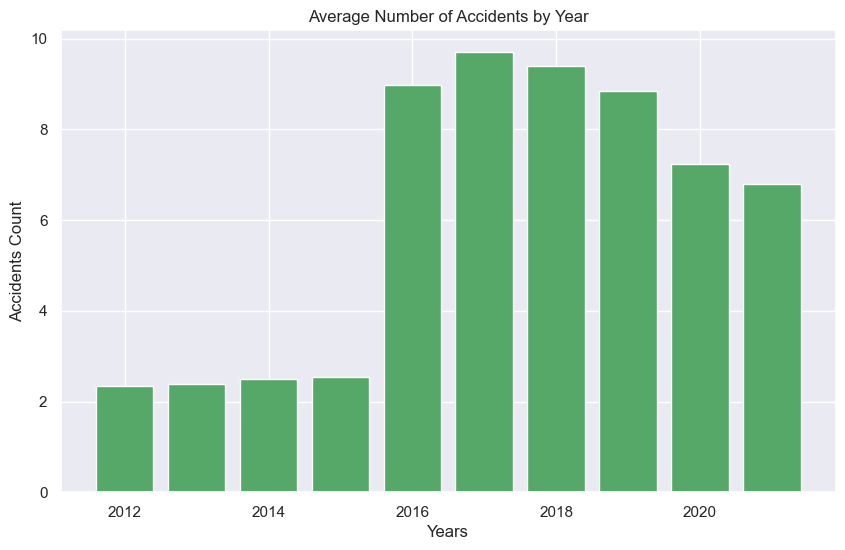

In [133]:
data2 = df.index.value_counts()
data_mean = data2.groupby(data2.index.year).mean()

plt.figure(figsize=(10, 6))
plt.bar(data_mean.index, data_mean, color=deep_colors[1])
plt.xlabel('Years')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Year')
plt.show()

One way ANOVA:

The result from the t-test is confirmed in the one-way ANOVA. 

In [134]:
f_stat, p_value = stats.f_oneway(data.year, data.hour, data.number_of_persons_injured)
print(f'F-stat: {f_stat:,.2f}')
print(f'P-value: {p_value:,.4f}')

F-stat: 290,202,601,794.84
P-value: 0.0000


Using Linear Regression to analyze the relationship between datetime of accident and number of persons injured: 

In [135]:
X = data.reset_index(drop=True)[['year', 'hour', 'person_age', 'vehicle_year']].dropna()
y = data.reset_index(drop=True).loc[X.index, 'number_of_persons_injured']
X = sm.add_constant(X)  # Add an intercept

model = sm.OLS(y, X).fit()

In [136]:
# 1. Check Model Fit
print("R-squared:", model.rsquared)
print("Adjusted R-squared:", model.rsquared_adj)
print("F-statistic:", model.fvalue)
print("F-statistic p-value:", model.f_pvalue)

R-squared: 0.012652174359933266
Adjusted R-squared: 0.012650545704666616
F-statistic: 7768.479074860797
F-statistic p-value: 0.0


In [137]:
# 2. Interpret Coefficients
coefficients = model.params
p_values = model.pvalues
print("Regression Coefficients:")
print(coefficients)
print("\nP-values:")
print(p_values)

Regression Coefficients:
const          -124.821215
year              0.067951
hour              0.001903
person_age       -0.003158
vehicle_year     -0.005841
dtype: float64

P-values:
const           0.000000e+00
year            0.000000e+00
hour            1.217947e-67
person_age      0.000000e+00
vehicle_year    0.000000e+00
dtype: float64


In [138]:
# 3. Hypothesis Testing
alpha = 0.05  # Significance level
significant_vars = [var for var, p in zip(X.columns, p_values) if p < alpha]
print("Significant Variables:", significant_vars)

Significant Variables: ['const', 'year', 'hour', 'person_age', 'vehicle_year']


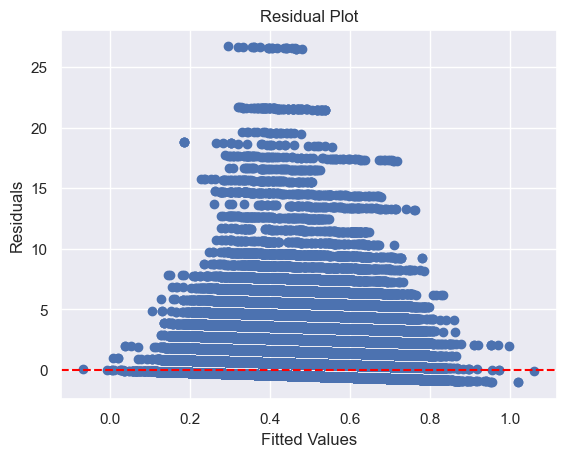

In [139]:
# 4. Assess Residuals
residuals = model.resid

# Create a residual plot
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


In [140]:
# Autocorrelation Tests
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(model.resid)
print('Durbin-Watson:', dw_statistic)

Durbin-Watson: 0.4207622080604775


In [141]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_statistic, p_values = acorr_ljungbox(model.resid, lags=[1, 5, 10])

pd.DataFrame({'Lags':[1, 5, 10], 'Ljung-Box Stat':lb_statistic, 'P-value':p_values})

Lags Ljung-Box Stat    P-value
0     1        lb_stat  lb_pvalue
1     5        lb_stat  lb_pvalue
2    10        lb_stat  lb_pvalue

In [142]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
_, bp_pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
print(bp_pvalue)

0.0


In [143]:
# 5. Multicollinearity
# High correlations between independent variables can indicate multicollinearity.
correlation_matrix = X.corr()
correlation_matrix

const      year      hour  person_age  vehicle_year
const           NaN       NaN       NaN         NaN           NaN
year            NaN  1.000000 -0.008576   -0.020428      0.209415
hour            NaN -0.008576  1.000000   -0.009976     -0.004233
person_age      NaN -0.020428 -0.009976    1.000000     -0.050107
vehicle_year    NaN  0.209415 -0.004233   -0.050107      1.000000

In [144]:
# 6. Variable Importance 
# Standardize independent variables
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Fit the linear regression model with standardized variables
model_s = sm.OLS(y, X_standardized).fit()

# Get standardized coefficients (beta values)
beta_values = model_s.params
beta_values

const    0.000000
x1       0.100435
x2       0.010964
x3      -0.049034
x4      -0.033985
dtype: float64

In [145]:
# Calculate permutation importance
model_s = LinearRegression().fit(X, y)

perm_importance = permutation_importance(model_s, X, y, n_repeats=30, random_state=0)

In [146]:
perm_importance.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [147]:
pd.DataFrame(perm_importance['importances'])

0         1         2         3         4         5         6   \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.020724  0.020548  0.020673  0.020581  0.020679  0.020687  0.020633   
2  0.000240  0.000263  0.000241  0.000255  0.000250  0.000251  0.000244   
3  0.004885  0.004884  0.004917  0.004944  0.004832  0.004819  0.004891   
4  0.002296  0.002387  0.002399  0.002295  0.002393  0.002365  0.002432   

         7         8         9   ...        20        21        22        23  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.020406  0.020446  0.020894  ...  0.020726  0.020935  0.020756  0.020589   
2  0.000210  0.000255  0.000269  ...  0.000225  0.000251  0.000235  0.000236   
3  0.004820  0.005082  0.004925  ...  0.004848  0.004963  0.004813  0.004879   
4  0.002392  0.002446  0.002441  ...  0.002320  0.002381  0.002380  0.002381   

         24        25        26        27        28        29  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.020579  0.020646  0.020545  0.020701  0.020580  0.020654  
2  0.000255  0.000262  0.000248  0.000240  0.000257  0.000256  
3  0.004994  0.004884  0.004915  0.004879  0.004908  0.004919  
4  0.002422  0.002350  0.002319  0.002342  0.002414  0.002327  

[5 rows x 30 columns]

In [148]:
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

Variable           VIF
0         const  1.869343e+06
1          year  1.046041e+00
2          hour  1.000186e+00
3    person_age  1.002727e+00
4  vehicle_year  1.048179e+00

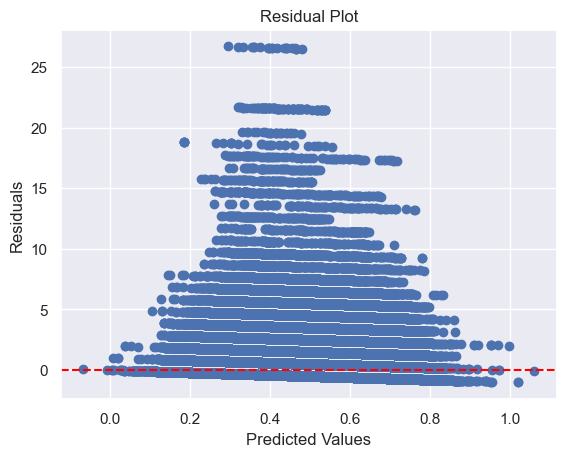

In [149]:
# 7. Model Assumptions
# check for linearity

# Calculate predicted (fitted) values
predicted_values = model.predict(X)

# Calculate residuals
residuals = y - predicted_values

# Create a residual plot
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

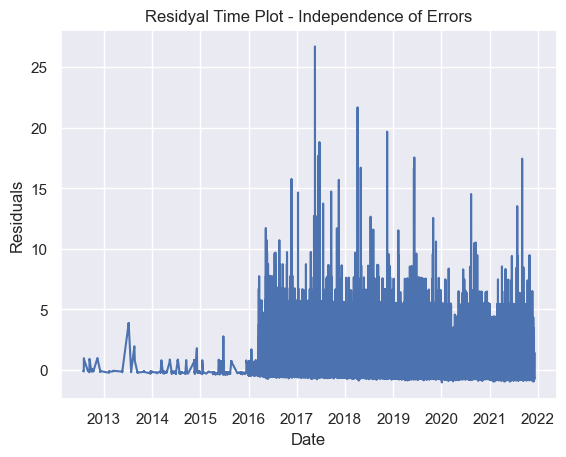

In [150]:
# independence of errors
plt.plot(data[['year', 'hour', 'person_age', 'vehicle_year']].dropna().index, residuals)
plt.title('Residyal Time Plot - Independence of Errors')
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

In [151]:
for ind, col in enumerate(X.columns):
    print(ind, col)

0 const
1 year
2 hour
3 person_age
4 vehicle_year


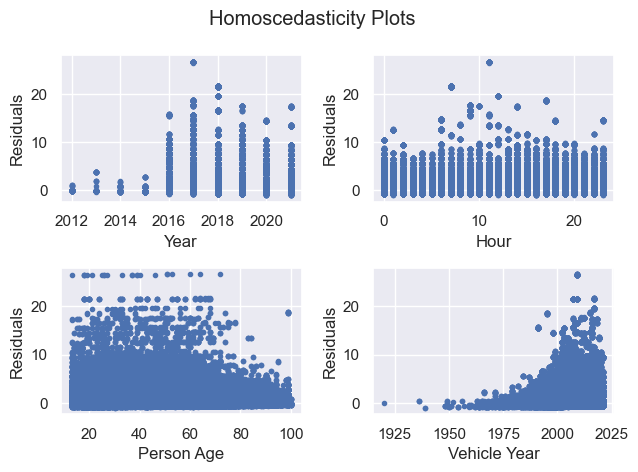

In [152]:
# homoscedasticity
for ind, col in enumerate(X.columns[1:]):
    plt.subplot(2, 2, ind+1)
    plt.scatter(X[col], residuals, marker='.')
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Residuals")

plt.suptitle('Homoscedasticity Plots')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Q-Q Plot')

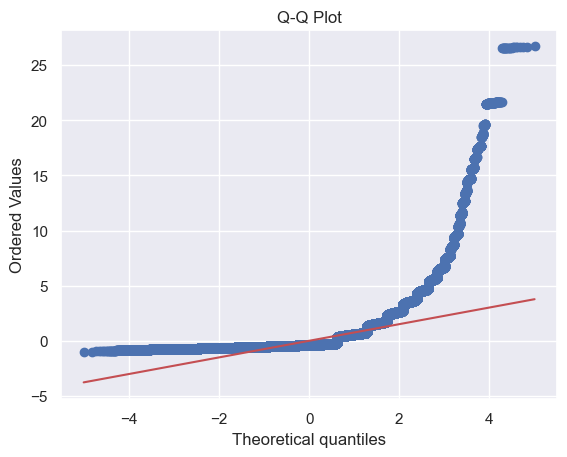

In [153]:
# normality of residuals
# Check normality using a Q-Q plot
fig, ax = plt.subplots()
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot")

In [154]:
# Model summary
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     number_of_persons_injured   R-squared:                       0.013
Model:                                   OLS   Adj. R-squared:                  0.013
Method:                        Least Squares   F-statistic:                     7768.
Date:                       Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                               21:58:33   Log-Likelihood:            -3.3977e+06
No. Observations:                    2424945   AIC:                         6.795e+06
Df Residuals:                        2424940   BIC:                         6.795e+06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [155]:
# Quantile regression
# Fit quantile regression for the 25th percentile
quantile = 0.25
model_25th = QuantReg(y, X).fit(q=quantile)

# View regression results
print("25th Percentile:")
print(model_25th.summary())

25th Percentile:
                             QuantReg Regression Results                             
Dep. Variable:     number_of_persons_injured   Pseudo R-squared:           -5.143e-07
Model:                              QuantReg   Bandwidth:                     0.02353
Method:                        Least Squares   Sparsity:                      0.04305
Date:                       Wed, 15 Nov 2023   No. Observations:              2424945
Time:                               21:58:35   Df Residuals:                  2424940
                                               Df Model:                            4
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.618e-05      0.024     -0.002      0.998      -0.047       0.047
year          2.993e-08   1.21e-05      0.002      0.998   -2.36e-05    2.37e-05
hour           8.59e-10   3.08e-06      0.000      1.000 

In [156]:
quantile = 0.75
model_75th = QuantReg(y, X).fit(q=quantile)
print("75th Percentile:")
print(model_75th.summary())

75th Percentile:
                             QuantReg Regression Results                             
Dep. Variable:     number_of_persons_injured   Pseudo R-squared:              0.02057
Model:                              QuantReg   Bandwidth:                     0.01507
Method:                        Least Squares   Sparsity:                        3.166
Date:                       Wed, 15 Nov 2023   No. Observations:              2424945
Time:                               21:58:52   Df Residuals:                  2424940
                                               Df Model:                            4
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -393.9076      1.206   -326.549      0.000    -396.272    -391.543
year             0.2096      0.001    345.189      0.000       0.208       0.211
hour             0.0035      0.000     21.883      0.000 

In [157]:
# 8. Predictive Power (if applicable)
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9650389467173425


In [158]:
# 9. Report Findings (summarize and communicate your results and insights).


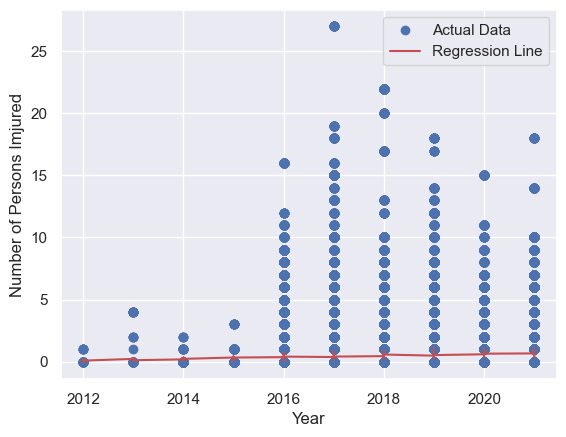

In [159]:
# Example of plotting the regression line
plt.scatter(X.year, y, label='Actual Data', color=deep_colors[0])
plt.plot(X.year, y_pred, label='Regression Line', color=deep_colors[2])
plt.xlabel('Year')
plt.ylabel('Number of Persons Imjured')
plt.legend()
plt.show()

### Conclusion & Recommendations

17. Provide recommendations to reduce the occurrence of accidents